# Task 1: Splicing Prediction Training
## Enhanced with Experiment Tracking & Metrics

### 1) Configuration & Setup

In [1]:
import os
import json
import torch
import pandas as pd
from config import (
    DATA_DIR, SAVE_ROOT, BATCH_SIZE, LR, EPOCHS, PATIENCE,
    HIDDEN_DIMS, DROPOUT, NUM_CLASSES, SEED, WEIGHT_DECAY
)

print(f"  Configuration loaded:")
print(f"  Data dir: {DATA_DIR}")
print(f"  Save root: {SAVE_ROOT}")
#print(f"  Batch size: {BATCH_SIZE}, LR: {LR}, Epochs: {EPOCHS}")
print(f"  Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")


  Configuration loaded:
  Data dir: D:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\data_preparation\train_val
  Save root: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models
  Device: cuda


### 2) Train Splicing Models with Experiment Tracking

In [2]:
import argparse
from train import main as train_main

# Create argument parser (simulating command-line args in notebook)
parser = argparse.ArgumentParser(description="Task 1 Splicing Prediction Training")
parser.add_argument("--batch-size", type=int, default=2048)
parser.add_argument("--lr", type=float, default=LR)
parser.add_argument('--weight-decay', type=float, default=WEIGHT_DECAY)
parser.add_argument("--epochs", type=int, default=EPOCHS)
parser.add_argument("--patience", type=int, default=PATIENCE)
parser.add_argument("--dropout", type=float, default=DROPOUT)
parser.add_argument("--device", type=str, default='cuda' if torch.cuda.is_available() else 'cpu')
parser.add_argument("--seed", type=int, default=SEED)
parser.add_argument("--data-dir", type=str, default=DATA_DIR)
parser.add_argument("--save-root", type=str, default=SAVE_ROOT)
parser.add_argument("--exp-num", type=int, default=None)
parser.add_argument("--ratio", type=str, default=None, help="Specific ratio (e.g., 'ratio_10_80_10'). If not specified, train all ratios.")
parser.add_argument("--set", type=str, default=None, help="Specific set (e.g., 'set_1'). If not specified, train all sets.")

# Parse empty args to use defaults, or modify as needed
args = parser.parse_args([])

# Run training
train_main(args)


c:\Users\Dung\anaconda3\envs\stable\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



EXPERIMENT 7: SPLICING PREDICTION TRAINING
TRAINING CONFIGURATION:
  Timestamp:           2026-02-02T02:51:36.768142
  Experiment dir:      d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7
  Data dir:            D:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\data_preparation\train_val
  Device:              cuda
  Seed:                42
  Batch size:          2048
  Learning rate:       0.001
  Weight decay:        0.0001
  Epochs:              50
  Patience:            7
  Dropout:             0.3
  Hidden dims:         [512, 256]
  Num classes:         3
  Embedding dim:       auto-detected

  ✅ Config.py copied to d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7/config.py
Configuration saved to d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7/config.json
Arguments saved to d:\Bio_sequence_Research_AITALAB\t

[Epoch 1] Train Loss=0.2622 | Val Loss=0.2341 | accuracy=0.9093 | precision=0.9111 | recall=0.9095 | specificity=0.9546 | f1=0.9100 | mcc=0.8643 | auc=0.9829 | balanced_acc=0.9095
  → New best model saved!


[Epoch 2] Train Loss=0.2223 | Val Loss=0.2229 | accuracy=0.9136 | precision=0.9132 | recall=0.9138 | specificity=0.9568 | f1=0.9133 | mcc=0.8706 | auc=0.9843 | balanced_acc=0.9138
  → New best model saved!


[Epoch 3] Train Loss=0.2107 | Val Loss=0.2160 | accuracy=0.9165 | precision=0.9165 | recall=0.9166 | specificity=0.9582 | f1=0.9166 | mcc=0.8748 | auc=0.9850 | balanced_acc=0.9166
  → New best model saved!


[Epoch 4] Train Loss=0.2016 | Val Loss=0.2255 | accuracy=0.9143 | precision=0.9158 | recall=0.9142 | specificity=0.9571 | f1=0.9147 | mcc=0.8717 | auc=0.9844 | balanced_acc=0.9142


[Epoch 5] Train Loss=0.1943 | Val Loss=0.2140 | accuracy=0.9181 | precision=0.9180 | recall=0.9182 | specificity=0.9590 | f1=0.9181 | mcc=0.8771 | auc=0.9853 | balanced_acc=0.9182
  → New best model saved!


[Epoch 6] Train Loss=0.1877 | Val Loss=0.2157 | accuracy=0.9182 | precision=0.9192 | recall=0.9182 | specificity=0.9590 | f1=0.9186 | mcc=0.8774 | auc=0.9852 | balanced_acc=0.9182


[Epoch 7] Train Loss=0.1810 | Val Loss=0.2176 | accuracy=0.9177 | precision=0.9184 | recall=0.9179 | specificity=0.9589 | f1=0.9180 | mcc=0.8767 | auc=0.9850 | balanced_acc=0.9179


[Epoch 8] Train Loss=0.1739 | Val Loss=0.2190 | accuracy=0.9171 | precision=0.9178 | recall=0.9171 | specificity=0.9585 | f1=0.9174 | mcc=0.8757 | auc=0.9851 | balanced_acc=0.9171


[Epoch 9] Train Loss=0.1680 | Val Loss=0.2170 | accuracy=0.9178 | precision=0.9179 | recall=0.9179 | specificity=0.9589 | f1=0.9179 | mcc=0.8766 | auc=0.9852 | balanced_acc=0.9179


[Epoch 10] Train Loss=0.1618 | Val Loss=0.2202 | accuracy=0.9172 | precision=0.9169 | recall=0.9174 | specificity=0.9586 | f1=0.9170 | mcc=0.8759 | auc=0.9849 | balanced_acc=0.9174


[Epoch 11] Train Loss=0.1554 | Val Loss=0.2240 | accuracy=0.9166 | precision=0.9163 | recall=0.9169 | specificity=0.9583 | f1=0.9164 | mcc=0.8751 | auc=0.9848 | balanced_acc=0.9169


[Epoch 12] Train Loss=0.1511 | Val Loss=0.2308 | accuracy=0.9164 | precision=0.9165 | recall=0.9165 | specificity=0.9582 | f1=0.9165 | mcc=0.8746 | auc=0.9843 | balanced_acc=0.9165
Early stopping at epoch 12

  Training 1_1_1/set_10
  Embedding dim: 1280
  Save dir: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\1_1_1\set_10

  Model Architecture:
  --------------------------------------------------
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SpliceSiteClassifier                     [2048, 1280]              [2048, 3]                 --
├─Sequential: 1-1                        [2048, 1280]              [2048, 3]                 --
│    └─Linear: 2-1                       [2048, 1280]              [2048, 512]               655,872
│    └─BatchNorm1d: 2-2                  [2048, 512]               [2048, 512]               1,024
│    └─ReLU: 2-3                         [2048, 5

[Epoch 1] Train Loss=0.2617 | Val Loss=0.2261 | accuracy=0.9143 | precision=0.9149 | recall=0.9144 | specificity=0.9571 | f1=0.9146 | mcc=0.8715 | auc=0.9836 | balanced_acc=0.9144
  → New best model saved!


[Epoch 2] Train Loss=0.2221 | Val Loss=0.2163 | accuracy=0.9179 | precision=0.9185 | recall=0.9180 | specificity=0.9589 | f1=0.9182 | mcc=0.8769 | auc=0.9849 | balanced_acc=0.9180
  → New best model saved!


[Epoch 3] Train Loss=0.2105 | Val Loss=0.2134 | accuracy=0.9182 | precision=0.9181 | recall=0.9183 | specificity=0.9591 | f1=0.9182 | mcc=0.8772 | auc=0.9853 | balanced_acc=0.9183
  → New best model saved!


[Epoch 4] Train Loss=0.2023 | Val Loss=0.2141 | accuracy=0.9189 | precision=0.9187 | recall=0.9191 | specificity=0.9594 | f1=0.9188 | mcc=0.8785 | auc=0.9854 | balanced_acc=0.9191


[Epoch 5] Train Loss=0.1944 | Val Loss=0.2160 | accuracy=0.9181 | precision=0.9180 | recall=0.9182 | specificity=0.9590 | f1=0.9181 | mcc=0.8773 | auc=0.9852 | balanced_acc=0.9182


[Epoch 6] Train Loss=0.1877 | Val Loss=0.2112 | accuracy=0.9203 | precision=0.9203 | recall=0.9204 | specificity=0.9601 | f1=0.9203 | mcc=0.8804 | auc=0.9856 | balanced_acc=0.9204
  → New best model saved!


[Epoch 7] Train Loss=0.1818 | Val Loss=0.2097 | accuracy=0.9211 | precision=0.9211 | recall=0.9213 | specificity=0.9606 | f1=0.9211 | mcc=0.8818 | auc=0.9858 | balanced_acc=0.9213
  → New best model saved!


[Epoch 8] Train Loss=0.1750 | Val Loss=0.2162 | accuracy=0.9190 | precision=0.9191 | recall=0.9192 | specificity=0.9595 | f1=0.9189 | mcc=0.8788 | auc=0.9853 | balanced_acc=0.9192


[Epoch 9] Train Loss=0.1684 | Val Loss=0.2243 | accuracy=0.9170 | precision=0.9176 | recall=0.9173 | specificity=0.9585 | f1=0.9171 | mcc=0.8758 | auc=0.9846 | balanced_acc=0.9173


[Epoch 10] Train Loss=0.1631 | Val Loss=0.2169 | accuracy=0.9193 | precision=0.9193 | recall=0.9195 | specificity=0.9596 | f1=0.9193 | mcc=0.8790 | auc=0.9854 | balanced_acc=0.9195


[Epoch 11] Train Loss=0.1569 | Val Loss=0.2198 | accuracy=0.9187 | precision=0.9187 | recall=0.9188 | specificity=0.9593 | f1=0.9188 | mcc=0.8781 | auc=0.9853 | balanced_acc=0.9188


[Epoch 12] Train Loss=0.1514 | Val Loss=0.2204 | accuracy=0.9193 | precision=0.9192 | recall=0.9194 | specificity=0.9596 | f1=0.9193 | mcc=0.8790 | auc=0.9851 | balanced_acc=0.9194


[Epoch 13] Train Loss=0.1463 | Val Loss=0.2262 | accuracy=0.9179 | precision=0.9179 | recall=0.9182 | specificity=0.9590 | f1=0.9179 | mcc=0.8771 | auc=0.9847 | balanced_acc=0.9182


[Epoch 14] Train Loss=0.1414 | Val Loss=0.2297 | accuracy=0.9182 | precision=0.9184 | recall=0.9183 | specificity=0.9591 | f1=0.9183 | mcc=0.8773 | auc=0.9845 | balanced_acc=0.9183
Early stopping at epoch 14

  Training 1_1_1/set_2
  Embedding dim: 1280
  Save dir: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\1_1_1\set_2

  Model Architecture:
  --------------------------------------------------
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SpliceSiteClassifier                     [2048, 1280]              [2048, 3]                 --
├─Sequential: 1-1                        [2048, 1280]              [2048, 3]                 --
│    └─Linear: 2-1                       [2048, 1280]              [2048, 512]               655,872
│    └─BatchNorm1d: 2-2                  [2048, 512]               [2048, 512]               1,024
│    └─ReLU: 2-3                         [2048, 512

[Epoch 1] Train Loss=0.2619 | Val Loss=0.2250 | accuracy=0.9132 | precision=0.9131 | recall=0.9131 | specificity=0.9566 | f1=0.9131 | mcc=0.8698 | auc=0.9841 | balanced_acc=0.9131
  → New best model saved!


[Epoch 2] Train Loss=0.2213 | Val Loss=0.2211 | accuracy=0.9138 | precision=0.9137 | recall=0.9139 | specificity=0.9569 | f1=0.9131 | mcc=0.8714 | auc=0.9852 | balanced_acc=0.9139
  → New best model saved!


[Epoch 3] Train Loss=0.2098 | Val Loss=0.2146 | accuracy=0.9171 | precision=0.9189 | recall=0.9171 | specificity=0.9586 | f1=0.9176 | mcc=0.8760 | auc=0.9858 | balanced_acc=0.9171
  → New best model saved!


[Epoch 4] Train Loss=0.2013 | Val Loss=0.2092 | accuracy=0.9192 | precision=0.9188 | recall=0.9192 | specificity=0.9596 | f1=0.9188 | mcc=0.8789 | auc=0.9860 | balanced_acc=0.9192
  → New best model saved!


[Epoch 5] Train Loss=0.1937 | Val Loss=0.2062 | accuracy=0.9210 | precision=0.9207 | recall=0.9210 | specificity=0.9605 | f1=0.9207 | mcc=0.8816 | auc=0.9864 | balanced_acc=0.9210
  → New best model saved!


[Epoch 6] Train Loss=0.1866 | Val Loss=0.2084 | accuracy=0.9205 | precision=0.9203 | recall=0.9206 | specificity=0.9603 | f1=0.9202 | mcc=0.8810 | auc=0.9863 | balanced_acc=0.9206


[Epoch 7] Train Loss=0.1800 | Val Loss=0.2067 | accuracy=0.9211 | precision=0.9212 | recall=0.9212 | specificity=0.9606 | f1=0.9211 | mcc=0.8817 | auc=0.9862 | balanced_acc=0.9212


[Epoch 8] Train Loss=0.1737 | Val Loss=0.2084 | accuracy=0.9214 | precision=0.9216 | recall=0.9214 | specificity=0.9607 | f1=0.9215 | mcc=0.8821 | auc=0.9862 | balanced_acc=0.9214


[Epoch 9] Train Loss=0.1676 | Val Loss=0.2155 | accuracy=0.9189 | precision=0.9189 | recall=0.9190 | specificity=0.9595 | f1=0.9187 | mcc=0.8787 | auc=0.9858 | balanced_acc=0.9190


[Epoch 10] Train Loss=0.1616 | Val Loss=0.2152 | accuracy=0.9201 | precision=0.9206 | recall=0.9201 | specificity=0.9601 | f1=0.9203 | mcc=0.8802 | auc=0.9858 | balanced_acc=0.9201


[Epoch 11] Train Loss=0.1554 | Val Loss=0.2134 | accuracy=0.9206 | precision=0.9207 | recall=0.9206 | specificity=0.9603 | f1=0.9206 | mcc=0.8809 | auc=0.9858 | balanced_acc=0.9206


[Epoch 12] Train Loss=0.1496 | Val Loss=0.2157 | accuracy=0.9195 | precision=0.9193 | recall=0.9195 | specificity=0.9598 | f1=0.9194 | mcc=0.8793 | auc=0.9856 | balanced_acc=0.9195
Early stopping at epoch 12

  Training 1_1_1/set_3
  Embedding dim: 1280
  Save dir: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\1_1_1\set_3

  Model Architecture:
  --------------------------------------------------
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SpliceSiteClassifier                     [2048, 1280]              [2048, 3]                 --
├─Sequential: 1-1                        [2048, 1280]              [2048, 3]                 --
│    └─Linear: 2-1                       [2048, 1280]              [2048, 512]               655,872
│    └─BatchNorm1d: 2-2                  [2048, 512]               [2048, 512]               1,024
│    └─ReLU: 2-3                         [2048, 512

[Epoch 1] Train Loss=0.2613 | Val Loss=0.2325 | accuracy=0.9121 | precision=0.9118 | recall=0.9122 | specificity=0.9560 | f1=0.9114 | mcc=0.8687 | auc=0.9835 | balanced_acc=0.9122
  → New best model saved!


[Epoch 2] Train Loss=0.2215 | Val Loss=0.2149 | accuracy=0.9192 | precision=0.9192 | recall=0.9193 | specificity=0.9596 | f1=0.9192 | mcc=0.8789 | auc=0.9850 | balanced_acc=0.9193
  → New best model saved!


[Epoch 3] Train Loss=0.2097 | Val Loss=0.2155 | accuracy=0.9177 | precision=0.9181 | recall=0.9176 | specificity=0.9588 | f1=0.9178 | mcc=0.8765 | auc=0.9852 | balanced_acc=0.9176


[Epoch 4] Train Loss=0.2008 | Val Loss=0.2124 | accuracy=0.9197 | precision=0.9194 | recall=0.9197 | specificity=0.9599 | f1=0.9195 | mcc=0.8797 | auc=0.9856 | balanced_acc=0.9197
  → New best model saved!


[Epoch 5] Train Loss=0.1930 | Val Loss=0.2092 | accuracy=0.9213 | precision=0.9211 | recall=0.9213 | specificity=0.9606 | f1=0.9212 | mcc=0.8820 | auc=0.9858 | balanced_acc=0.9213
  → New best model saved!


[Epoch 6] Train Loss=0.1860 | Val Loss=0.2136 | accuracy=0.9198 | precision=0.9194 | recall=0.9198 | specificity=0.9599 | f1=0.9194 | mcc=0.8799 | auc=0.9856 | balanced_acc=0.9198


[Epoch 7] Train Loss=0.1792 | Val Loss=0.2148 | accuracy=0.9198 | precision=0.9201 | recall=0.9199 | specificity=0.9599 | f1=0.9199 | mcc=0.8799 | auc=0.9854 | balanced_acc=0.9199


[Epoch 8] Train Loss=0.1731 | Val Loss=0.2137 | accuracy=0.9206 | precision=0.9208 | recall=0.9206 | specificity=0.9603 | f1=0.9207 | mcc=0.8809 | auc=0.9856 | balanced_acc=0.9206


[Epoch 9] Train Loss=0.1670 | Val Loss=0.2185 | accuracy=0.9199 | precision=0.9197 | recall=0.9200 | specificity=0.9600 | f1=0.9195 | mcc=0.8802 | auc=0.9854 | balanced_acc=0.9200


[Epoch 10] Train Loss=0.1604 | Val Loss=0.2178 | accuracy=0.9200 | precision=0.9202 | recall=0.9201 | specificity=0.9600 | f1=0.9201 | mcc=0.8801 | auc=0.9852 | balanced_acc=0.9201


[Epoch 11] Train Loss=0.1546 | Val Loss=0.2247 | accuracy=0.9193 | precision=0.9205 | recall=0.9193 | specificity=0.9597 | f1=0.9197 | mcc=0.8792 | auc=0.9850 | balanced_acc=0.9193


[Epoch 12] Train Loss=0.1500 | Val Loss=0.2230 | accuracy=0.9204 | precision=0.9204 | recall=0.9204 | specificity=0.9602 | f1=0.9204 | mcc=0.8806 | auc=0.9850 | balanced_acc=0.9204
Early stopping at epoch 12

  Training 1_1_1/set_4
  Embedding dim: 1280
  Save dir: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\1_1_1\set_4

  Model Architecture:
  --------------------------------------------------
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SpliceSiteClassifier                     [2048, 1280]              [2048, 3]                 --
├─Sequential: 1-1                        [2048, 1280]              [2048, 3]                 --
│    └─Linear: 2-1                       [2048, 1280]              [2048, 512]               655,872
│    └─BatchNorm1d: 2-2                  [2048, 512]               [2048, 512]               1,024
│    └─ReLU: 2-3                         [2048, 512

[Epoch 1] Train Loss=0.2610 | Val Loss=0.2284 | accuracy=0.9134 | precision=0.9136 | recall=0.9135 | specificity=0.9567 | f1=0.9135 | mcc=0.8702 | auc=0.9837 | balanced_acc=0.9135
  → New best model saved!


[Epoch 2] Train Loss=0.2217 | Val Loss=0.2197 | accuracy=0.9155 | precision=0.9153 | recall=0.9159 | specificity=0.9578 | f1=0.9150 | mcc=0.8738 | auc=0.9852 | balanced_acc=0.9159
  → New best model saved!


[Epoch 3] Train Loss=0.2098 | Val Loss=0.2120 | accuracy=0.9191 | precision=0.9197 | recall=0.9193 | specificity=0.9595 | f1=0.9194 | mcc=0.8787 | auc=0.9855 | balanced_acc=0.9193
  → New best model saved!


[Epoch 4] Train Loss=0.2013 | Val Loss=0.2091 | accuracy=0.9204 | precision=0.9206 | recall=0.9204 | specificity=0.9601 | f1=0.9205 | mcc=0.8805 | auc=0.9859 | balanced_acc=0.9204
  → New best model saved!


[Epoch 5] Train Loss=0.1940 | Val Loss=0.2091 | accuracy=0.9201 | precision=0.9200 | recall=0.9204 | specificity=0.9601 | f1=0.9201 | mcc=0.8803 | auc=0.9859 | balanced_acc=0.9204
  → New best model saved!


[Epoch 6] Train Loss=0.1873 | Val Loss=0.2130 | accuracy=0.9187 | precision=0.9186 | recall=0.9192 | specificity=0.9594 | f1=0.9184 | mcc=0.8786 | auc=0.9860 | balanced_acc=0.9192


[Epoch 7] Train Loss=0.1809 | Val Loss=0.2087 | accuracy=0.9214 | precision=0.9216 | recall=0.9217 | specificity=0.9607 | f1=0.9215 | mcc=0.8822 | auc=0.9859 | balanced_acc=0.9217
  → New best model saved!


[Epoch 8] Train Loss=0.1748 | Val Loss=0.2104 | accuracy=0.9204 | precision=0.9201 | recall=0.9206 | specificity=0.9602 | f1=0.9203 | mcc=0.8806 | auc=0.9859 | balanced_acc=0.9206


[Epoch 9] Train Loss=0.1684 | Val Loss=0.2119 | accuracy=0.9208 | precision=0.9210 | recall=0.9209 | specificity=0.9603 | f1=0.9209 | mcc=0.8812 | auc=0.9856 | balanced_acc=0.9209


[Epoch 10] Train Loss=0.1624 | Val Loss=0.2136 | accuracy=0.9202 | precision=0.9201 | recall=0.9204 | specificity=0.9601 | f1=0.9202 | mcc=0.8803 | auc=0.9857 | balanced_acc=0.9204


[Epoch 11] Train Loss=0.1561 | Val Loss=0.2156 | accuracy=0.9199 | precision=0.9202 | recall=0.9201 | specificity=0.9599 | f1=0.9201 | mcc=0.8799 | auc=0.9854 | balanced_acc=0.9201


[Epoch 12] Train Loss=0.1510 | Val Loss=0.2184 | accuracy=0.9197 | precision=0.9195 | recall=0.9200 | specificity=0.9598 | f1=0.9196 | mcc=0.8797 | auc=0.9855 | balanced_acc=0.9200


[Epoch 13] Train Loss=0.1464 | Val Loss=0.2218 | accuracy=0.9188 | precision=0.9187 | recall=0.9192 | specificity=0.9594 | f1=0.9188 | mcc=0.8784 | auc=0.9852 | balanced_acc=0.9192


[Epoch 14] Train Loss=0.1415 | Val Loss=0.2240 | accuracy=0.9195 | precision=0.9193 | recall=0.9197 | specificity=0.9597 | f1=0.9194 | mcc=0.8793 | auc=0.9852 | balanced_acc=0.9197
Early stopping at epoch 14

  Training 1_1_1/set_5
  Embedding dim: 1280
  Save dir: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\1_1_1\set_5

  Model Architecture:
  --------------------------------------------------
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SpliceSiteClassifier                     [2048, 1280]              [2048, 3]                 --
├─Sequential: 1-1                        [2048, 1280]              [2048, 3]                 --
│    └─Linear: 2-1                       [2048, 1280]              [2048, 512]               655,872
│    └─BatchNorm1d: 2-2                  [2048, 512]               [2048, 512]               1,024
│    └─ReLU: 2-3                         [2048, 512

[Epoch 1] Train Loss=0.2618 | Val Loss=0.2250 | accuracy=0.9143 | precision=0.9146 | recall=0.9145 | specificity=0.9571 | f1=0.9145 | mcc=0.8715 | auc=0.9839 | balanced_acc=0.9145
  → New best model saved!


[Epoch 2] Train Loss=0.2214 | Val Loss=0.2232 | accuracy=0.9144 | precision=0.9148 | recall=0.9147 | specificity=0.9572 | f1=0.9143 | mcc=0.8720 | auc=0.9845 | balanced_acc=0.9147
  → New best model saved!


[Epoch 3] Train Loss=0.2096 | Val Loss=0.2134 | accuracy=0.9187 | precision=0.9185 | recall=0.9189 | specificity=0.9593 | f1=0.9187 | mcc=0.8780 | auc=0.9853 | balanced_acc=0.9189
  → New best model saved!


[Epoch 4] Train Loss=0.2009 | Val Loss=0.2124 | accuracy=0.9182 | precision=0.9180 | recall=0.9184 | specificity=0.9591 | f1=0.9181 | mcc=0.8774 | auc=0.9856 | balanced_acc=0.9184
  → New best model saved!


[Epoch 5] Train Loss=0.1934 | Val Loss=0.2100 | accuracy=0.9201 | precision=0.9206 | recall=0.9202 | specificity=0.9600 | f1=0.9203 | mcc=0.8801 | auc=0.9857 | balanced_acc=0.9202
  → New best model saved!


[Epoch 6] Train Loss=0.1869 | Val Loss=0.2123 | accuracy=0.9194 | precision=0.9203 | recall=0.9194 | specificity=0.9596 | f1=0.9198 | mcc=0.8791 | auc=0.9856 | balanced_acc=0.9194


[Epoch 7] Train Loss=0.1795 | Val Loss=0.2108 | accuracy=0.9198 | precision=0.9202 | recall=0.9200 | specificity=0.9599 | f1=0.9201 | mcc=0.8797 | auc=0.9858 | balanced_acc=0.9200


[Epoch 8] Train Loss=0.1734 | Val Loss=0.2144 | accuracy=0.9191 | precision=0.9189 | recall=0.9193 | specificity=0.9595 | f1=0.9190 | mcc=0.8787 | auc=0.9855 | balanced_acc=0.9193


[Epoch 9] Train Loss=0.1673 | Val Loss=0.2182 | accuracy=0.9185 | precision=0.9182 | recall=0.9187 | specificity=0.9592 | f1=0.9183 | mcc=0.8778 | auc=0.9854 | balanced_acc=0.9187


[Epoch 10] Train Loss=0.1608 | Val Loss=0.2251 | accuracy=0.9159 | precision=0.9156 | recall=0.9162 | specificity=0.9580 | f1=0.9155 | mcc=0.8743 | auc=0.9851 | balanced_acc=0.9162


[Epoch 11] Train Loss=0.1559 | Val Loss=0.2246 | accuracy=0.9173 | precision=0.9178 | recall=0.9174 | specificity=0.9586 | f1=0.9175 | mcc=0.8760 | auc=0.9848 | balanced_acc=0.9174


[Epoch 12] Train Loss=0.1501 | Val Loss=0.2237 | accuracy=0.9182 | precision=0.9183 | recall=0.9184 | specificity=0.9591 | f1=0.9183 | mcc=0.8774 | auc=0.9850 | balanced_acc=0.9184
Early stopping at epoch 12

  Training 1_1_1/set_6
  Embedding dim: 1280
  Save dir: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\1_1_1\set_6

  Model Architecture:
  --------------------------------------------------
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SpliceSiteClassifier                     [2048, 1280]              [2048, 3]                 --
├─Sequential: 1-1                        [2048, 1280]              [2048, 3]                 --
│    └─Linear: 2-1                       [2048, 1280]              [2048, 512]               655,872
│    └─BatchNorm1d: 2-2                  [2048, 512]               [2048, 512]               1,024
│    └─ReLU: 2-3                         [2048, 512

[Epoch 1] Train Loss=0.2619 | Val Loss=0.2285 | accuracy=0.9127 | precision=0.9127 | recall=0.9128 | specificity=0.9563 | f1=0.9128 | mcc=0.8690 | auc=0.9834 | balanced_acc=0.9128
  → New best model saved!


[Epoch 2] Train Loss=0.2219 | Val Loss=0.2216 | accuracy=0.9150 | precision=0.9147 | recall=0.9152 | specificity=0.9575 | f1=0.9149 | mcc=0.8725 | auc=0.9844 | balanced_acc=0.9152
  → New best model saved!


[Epoch 3] Train Loss=0.2105 | Val Loss=0.2170 | accuracy=0.9170 | precision=0.9173 | recall=0.9174 | specificity=0.9585 | f1=0.9171 | mcc=0.8758 | auc=0.9851 | balanced_acc=0.9174
  → New best model saved!


[Epoch 4] Train Loss=0.2015 | Val Loss=0.2132 | accuracy=0.9196 | precision=0.9199 | recall=0.9199 | specificity=0.9598 | f1=0.9198 | mcc=0.8795 | auc=0.9854 | balanced_acc=0.9199
  → New best model saved!


[Epoch 5] Train Loss=0.1941 | Val Loss=0.2129 | accuracy=0.9195 | precision=0.9196 | recall=0.9197 | specificity=0.9597 | f1=0.9196 | mcc=0.8793 | auc=0.9855 | balanced_acc=0.9197
  → New best model saved!


[Epoch 6] Train Loss=0.1871 | Val Loss=0.2130 | accuracy=0.9191 | precision=0.9194 | recall=0.9193 | specificity=0.9595 | f1=0.9192 | mcc=0.8788 | auc=0.9856 | balanced_acc=0.9193


[Epoch 7] Train Loss=0.1803 | Val Loss=0.2184 | accuracy=0.9179 | precision=0.9179 | recall=0.9183 | specificity=0.9590 | f1=0.9177 | mcc=0.8773 | auc=0.9853 | balanced_acc=0.9183


[Epoch 8] Train Loss=0.1741 | Val Loss=0.2152 | accuracy=0.9190 | precision=0.9201 | recall=0.9190 | specificity=0.9594 | f1=0.9194 | mcc=0.8786 | auc=0.9854 | balanced_acc=0.9190


[Epoch 9] Train Loss=0.1673 | Val Loss=0.2209 | accuracy=0.9171 | precision=0.9168 | recall=0.9174 | specificity=0.9586 | f1=0.9169 | mcc=0.8760 | auc=0.9851 | balanced_acc=0.9174


[Epoch 10] Train Loss=0.1616 | Val Loss=0.2198 | accuracy=0.9193 | precision=0.9197 | recall=0.9195 | specificity=0.9596 | f1=0.9196 | mcc=0.8790 | auc=0.9851 | balanced_acc=0.9195


[Epoch 11] Train Loss=0.1563 | Val Loss=0.2213 | accuracy=0.9185 | precision=0.9188 | recall=0.9187 | specificity=0.9592 | f1=0.9187 | mcc=0.8778 | auc=0.9850 | balanced_acc=0.9187


[Epoch 12] Train Loss=0.1506 | Val Loss=0.2250 | accuracy=0.9187 | precision=0.9193 | recall=0.9188 | specificity=0.9593 | f1=0.9190 | mcc=0.8781 | auc=0.9848 | balanced_acc=0.9188
Early stopping at epoch 12

  Training 1_1_1/set_7
  Embedding dim: 1280
  Save dir: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\1_1_1\set_7

  Model Architecture:
  --------------------------------------------------
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SpliceSiteClassifier                     [2048, 1280]              [2048, 3]                 --
├─Sequential: 1-1                        [2048, 1280]              [2048, 3]                 --
│    └─Linear: 2-1                       [2048, 1280]              [2048, 512]               655,872
│    └─BatchNorm1d: 2-2                  [2048, 512]               [2048, 512]               1,024
│    └─ReLU: 2-3                         [2048, 512

[Epoch 1] Train Loss=0.2618 | Val Loss=0.2266 | accuracy=0.9132 | precision=0.9130 | recall=0.9134 | specificity=0.9566 | f1=0.9131 | mcc=0.8698 | auc=0.9837 | balanced_acc=0.9134
  → New best model saved!


[Epoch 2] Train Loss=0.2225 | Val Loss=0.2159 | accuracy=0.9183 | precision=0.9182 | recall=0.9184 | specificity=0.9591 | f1=0.9183 | mcc=0.8774 | auc=0.9850 | balanced_acc=0.9184
  → New best model saved!


[Epoch 3] Train Loss=0.2104 | Val Loss=0.2158 | accuracy=0.9174 | precision=0.9179 | recall=0.9177 | specificity=0.9587 | f1=0.9176 | mcc=0.8763 | auc=0.9851 | balanced_acc=0.9177
  → New best model saved!


[Epoch 4] Train Loss=0.2021 | Val Loss=0.2107 | accuracy=0.9194 | precision=0.9193 | recall=0.9195 | specificity=0.9597 | f1=0.9194 | mcc=0.8792 | auc=0.9856 | balanced_acc=0.9195
  → New best model saved!


[Epoch 5] Train Loss=0.1943 | Val Loss=0.2099 | accuracy=0.9198 | precision=0.9198 | recall=0.9200 | specificity=0.9599 | f1=0.9198 | mcc=0.8798 | auc=0.9857 | balanced_acc=0.9200
  → New best model saved!


[Epoch 6] Train Loss=0.1876 | Val Loss=0.2118 | accuracy=0.9201 | precision=0.9200 | recall=0.9201 | specificity=0.9600 | f1=0.9201 | mcc=0.8801 | auc=0.9857 | balanced_acc=0.9201


[Epoch 7] Train Loss=0.1812 | Val Loss=0.2120 | accuracy=0.9198 | precision=0.9202 | recall=0.9199 | specificity=0.9599 | f1=0.9200 | mcc=0.8797 | auc=0.9856 | balanced_acc=0.9199


[Epoch 8] Train Loss=0.1744 | Val Loss=0.2131 | accuracy=0.9195 | precision=0.9195 | recall=0.9197 | specificity=0.9597 | f1=0.9195 | mcc=0.8793 | auc=0.9856 | balanced_acc=0.9197


[Epoch 9] Train Loss=0.1678 | Val Loss=0.2181 | accuracy=0.9181 | precision=0.9178 | recall=0.9184 | specificity=0.9591 | f1=0.9178 | mcc=0.8775 | auc=0.9855 | balanced_acc=0.9184


[Epoch 10] Train Loss=0.1620 | Val Loss=0.2189 | accuracy=0.9193 | precision=0.9198 | recall=0.9194 | specificity=0.9596 | f1=0.9196 | mcc=0.8790 | auc=0.9853 | balanced_acc=0.9194


[Epoch 11] Train Loss=0.1564 | Val Loss=0.2195 | accuracy=0.9195 | precision=0.9196 | recall=0.9197 | specificity=0.9598 | f1=0.9196 | mcc=0.8793 | auc=0.9853 | balanced_acc=0.9197


[Epoch 12] Train Loss=0.1513 | Val Loss=0.2232 | accuracy=0.9172 | precision=0.9169 | recall=0.9174 | specificity=0.9586 | f1=0.9169 | mcc=0.8761 | auc=0.9850 | balanced_acc=0.9174
Early stopping at epoch 12

  Training 1_1_1/set_8
  Embedding dim: 1280
  Save dir: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\1_1_1\set_8

  Model Architecture:
  --------------------------------------------------
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SpliceSiteClassifier                     [2048, 1280]              [2048, 3]                 --
├─Sequential: 1-1                        [2048, 1280]              [2048, 3]                 --
│    └─Linear: 2-1                       [2048, 1280]              [2048, 512]               655,872
│    └─BatchNorm1d: 2-2                  [2048, 512]               [2048, 512]               1,024
│    └─ReLU: 2-3                         [2048, 512

[Epoch 1] Train Loss=0.2632 | Val Loss=0.2266 | accuracy=0.9130 | precision=0.9133 | recall=0.9133 | specificity=0.9564 | f1=0.9133 | mcc=0.8695 | auc=0.9837 | balanced_acc=0.9133
  → New best model saved!


[Epoch 2] Train Loss=0.2228 | Val Loss=0.2189 | accuracy=0.9155 | precision=0.9153 | recall=0.9159 | specificity=0.9577 | f1=0.9155 | mcc=0.8733 | auc=0.9847 | balanced_acc=0.9159
  → New best model saved!


[Epoch 3] Train Loss=0.2114 | Val Loss=0.2161 | accuracy=0.9158 | precision=0.9156 | recall=0.9163 | specificity=0.9579 | f1=0.9157 | mcc=0.8740 | auc=0.9853 | balanced_acc=0.9163
  → New best model saved!


[Epoch 4] Train Loss=0.2023 | Val Loss=0.2137 | accuracy=0.9183 | precision=0.9186 | recall=0.9186 | specificity=0.9591 | f1=0.9186 | mcc=0.8775 | auc=0.9854 | balanced_acc=0.9186
  → New best model saved!


[Epoch 5] Train Loss=0.1947 | Val Loss=0.2105 | accuracy=0.9191 | precision=0.9192 | recall=0.9195 | specificity=0.9595 | f1=0.9193 | mcc=0.8787 | auc=0.9857 | balanced_acc=0.9195
  → New best model saved!


[Epoch 6] Train Loss=0.1879 | Val Loss=0.2126 | accuracy=0.9187 | precision=0.9187 | recall=0.9190 | specificity=0.9593 | f1=0.9188 | mcc=0.8781 | auc=0.9855 | balanced_acc=0.9190


[Epoch 7] Train Loss=0.1814 | Val Loss=0.2122 | accuracy=0.9193 | precision=0.9194 | recall=0.9198 | specificity=0.9596 | f1=0.9194 | mcc=0.8792 | auc=0.9857 | balanced_acc=0.9198


[Epoch 8] Train Loss=0.1746 | Val Loss=0.2138 | accuracy=0.9199 | precision=0.9199 | recall=0.9202 | specificity=0.9599 | f1=0.9200 | mcc=0.8799 | auc=0.9857 | balanced_acc=0.9202


[Epoch 9] Train Loss=0.1686 | Val Loss=0.2201 | accuracy=0.9171 | precision=0.9169 | recall=0.9177 | specificity=0.9586 | f1=0.9169 | mcc=0.8761 | auc=0.9854 | balanced_acc=0.9177


[Epoch 10] Train Loss=0.1623 | Val Loss=0.2192 | accuracy=0.9182 | precision=0.9188 | recall=0.9184 | specificity=0.9590 | f1=0.9186 | mcc=0.8773 | auc=0.9852 | balanced_acc=0.9184


[Epoch 11] Train Loss=0.1563 | Val Loss=0.2263 | accuracy=0.9166 | precision=0.9164 | recall=0.9171 | specificity=0.9583 | f1=0.9164 | mcc=0.8753 | auc=0.9849 | balanced_acc=0.9171


[Epoch 12] Train Loss=0.1514 | Val Loss=0.2252 | accuracy=0.9177 | precision=0.9184 | recall=0.9180 | specificity=0.9588 | f1=0.9181 | mcc=0.8766 | auc=0.9850 | balanced_acc=0.9180
Early stopping at epoch 12

  Training 1_1_1/set_9
  Embedding dim: 1280
  Save dir: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\1_1_1\set_9

  Model Architecture:
  --------------------------------------------------
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SpliceSiteClassifier                     [2048, 1280]              [2048, 3]                 --
├─Sequential: 1-1                        [2048, 1280]              [2048, 3]                 --
│    └─Linear: 2-1                       [2048, 1280]              [2048, 512]               655,872
│    └─BatchNorm1d: 2-2                  [2048, 512]               [2048, 512]               1,024
│    └─ReLU: 2-3                         [2048, 512

[Epoch 1] Train Loss=0.2625 | Val Loss=0.2292 | accuracy=0.9112 | precision=0.9120 | recall=0.9112 | specificity=0.9555 | f1=0.9115 | mcc=0.8668 | auc=0.9834 | balanced_acc=0.9112
  → New best model saved!


[Epoch 2] Train Loss=0.2228 | Val Loss=0.2218 | accuracy=0.9146 | precision=0.9142 | recall=0.9148 | specificity=0.9573 | f1=0.9142 | mcc=0.8723 | auc=0.9848 | balanced_acc=0.9148
  → New best model saved!


[Epoch 3] Train Loss=0.2109 | Val Loss=0.2177 | accuracy=0.9161 | precision=0.9161 | recall=0.9164 | specificity=0.9581 | f1=0.9159 | mcc=0.8745 | auc=0.9850 | balanced_acc=0.9164
  → New best model saved!


[Epoch 4] Train Loss=0.2022 | Val Loss=0.2124 | accuracy=0.9188 | precision=0.9185 | recall=0.9189 | specificity=0.9594 | f1=0.9186 | mcc=0.8782 | auc=0.9856 | balanced_acc=0.9189
  → New best model saved!


[Epoch 5] Train Loss=0.1943 | Val Loss=0.2107 | accuracy=0.9195 | precision=0.9192 | recall=0.9196 | specificity=0.9597 | f1=0.9193 | mcc=0.8793 | auc=0.9858 | balanced_acc=0.9196
  → New best model saved!


[Epoch 6] Train Loss=0.1871 | Val Loss=0.2162 | accuracy=0.9175 | precision=0.9176 | recall=0.9178 | specificity=0.9588 | f1=0.9174 | mcc=0.8766 | auc=0.9853 | balanced_acc=0.9178


[Epoch 7] Train Loss=0.1809 | Val Loss=0.2109 | accuracy=0.9196 | precision=0.9195 | recall=0.9198 | specificity=0.9598 | f1=0.9196 | mcc=0.8795 | auc=0.9857 | balanced_acc=0.9198


[Epoch 8] Train Loss=0.1740 | Val Loss=0.2126 | accuracy=0.9204 | precision=0.9209 | recall=0.9205 | specificity=0.9602 | f1=0.9206 | mcc=0.8806 | auc=0.9857 | balanced_acc=0.9205


[Epoch 9] Train Loss=0.1683 | Val Loss=0.2136 | accuracy=0.9198 | precision=0.9203 | recall=0.9199 | specificity=0.9599 | f1=0.9200 | mcc=0.8797 | auc=0.9856 | balanced_acc=0.9199


[Epoch 10] Train Loss=0.1621 | Val Loss=0.2179 | accuracy=0.9182 | precision=0.9181 | recall=0.9184 | specificity=0.9591 | f1=0.9182 | mcc=0.8774 | auc=0.9852 | balanced_acc=0.9184


[Epoch 11] Train Loss=0.1558 | Val Loss=0.2201 | accuracy=0.9192 | precision=0.9191 | recall=0.9193 | specificity=0.9596 | f1=0.9192 | mcc=0.8788 | auc=0.9851 | balanced_acc=0.9193


[Epoch 12] Train Loss=0.1508 | Val Loss=0.2247 | accuracy=0.9166 | precision=0.9175 | recall=0.9165 | specificity=0.9582 | f1=0.9169 | mcc=0.8750 | auc=0.9846 | balanced_acc=0.9165
Early stopping at epoch 12

Processing 2_1_1:

  Training 2_1_1/set_1
  Embedding dim: 1280
  Save dir: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\2_1_1\set_1

  Model Architecture:
  --------------------------------------------------
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SpliceSiteClassifier                     [2048, 1280]              [2048, 3]                 --
├─Sequential: 1-1                        [2048, 1280]              [2048, 3]                 --
│    └─Linear: 2-1                       [2048, 1280]              [2048, 512]               655,872
│    └─BatchNorm1d: 2-2                  [2048, 512]               [2048, 512]               1,024
│    └─ReLU: 2-3                

[Epoch 1] Train Loss=0.2648 | Val Loss=0.2340 | accuracy=0.9100 | precision=0.9079 | recall=0.9121 | specificity=0.9511 | f1=0.9096 | mcc=0.8565 | auc=0.9824 | balanced_acc=0.9121
  → New best model saved!


[Epoch 2] Train Loss=0.2283 | Val Loss=0.2272 | accuracy=0.9135 | precision=0.9143 | recall=0.9112 | specificity=0.9515 | f1=0.9125 | mcc=0.8613 | auc=0.9833 | balanced_acc=0.9112
  → New best model saved!


[Epoch 3] Train Loss=0.2179 | Val Loss=0.2168 | accuracy=0.9170 | precision=0.9188 | recall=0.9135 | specificity=0.9531 | f1=0.9161 | mcc=0.8666 | auc=0.9844 | balanced_acc=0.9135
  → New best model saved!


[Epoch 4] Train Loss=0.2106 | Val Loss=0.2170 | accuracy=0.9176 | precision=0.9153 | recall=0.9190 | specificity=0.9550 | f1=0.9171 | mcc=0.8683 | auc=0.9846 | balanced_acc=0.9190


[Epoch 5] Train Loss=0.2043 | Val Loss=0.2136 | accuracy=0.9186 | precision=0.9192 | recall=0.9164 | specificity=0.9544 | f1=0.9178 | mcc=0.8694 | auc=0.9849 | balanced_acc=0.9164
  → New best model saved!


[Epoch 6] Train Loss=0.1988 | Val Loss=0.2126 | accuracy=0.9187 | precision=0.9190 | recall=0.9167 | specificity=0.9545 | f1=0.9179 | mcc=0.8695 | auc=0.9850 | balanced_acc=0.9167
  → New best model saved!


[Epoch 7] Train Loss=0.1943 | Val Loss=0.2115 | accuracy=0.9198 | precision=0.9199 | recall=0.9184 | specificity=0.9553 | f1=0.9192 | mcc=0.8714 | auc=0.9851 | balanced_acc=0.9184
  → New best model saved!


[Epoch 8] Train Loss=0.1894 | Val Loss=0.2136 | accuracy=0.9195 | precision=0.9201 | recall=0.9174 | specificity=0.9549 | f1=0.9187 | mcc=0.8708 | auc=0.9849 | balanced_acc=0.9174


[Epoch 9] Train Loss=0.1845 | Val Loss=0.2160 | accuracy=0.9181 | precision=0.9203 | recall=0.9141 | specificity=0.9535 | f1=0.9171 | mcc=0.8684 | auc=0.9845 | balanced_acc=0.9141


[Epoch 10] Train Loss=0.1801 | Val Loss=0.2160 | accuracy=0.9189 | precision=0.9188 | recall=0.9175 | specificity=0.9548 | f1=0.9181 | mcc=0.8700 | auc=0.9847 | balanced_acc=0.9175


[Epoch 11] Train Loss=0.1755 | Val Loss=0.2184 | accuracy=0.9174 | precision=0.9198 | recall=0.9132 | specificity=0.9531 | f1=0.9164 | mcc=0.8673 | auc=0.9845 | balanced_acc=0.9132


[Epoch 12] Train Loss=0.1714 | Val Loss=0.2200 | accuracy=0.9174 | precision=0.9164 | recall=0.9170 | specificity=0.9544 | f1=0.9167 | mcc=0.8677 | auc=0.9845 | balanced_acc=0.9170


[Epoch 13] Train Loss=0.1682 | Val Loss=0.2189 | accuracy=0.9189 | precision=0.9177 | recall=0.9188 | specificity=0.9553 | f1=0.9182 | mcc=0.8701 | auc=0.9845 | balanced_acc=0.9188


[Epoch 14] Train Loss=0.1637 | Val Loss=0.2201 | accuracy=0.9182 | precision=0.9195 | recall=0.9151 | specificity=0.9538 | f1=0.9172 | mcc=0.8685 | auc=0.9843 | balanced_acc=0.9151
Early stopping at epoch 14

  Training 2_1_1/set_10
  Embedding dim: 1280
  Save dir: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\2_1_1\set_10

  Model Architecture:
  --------------------------------------------------
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SpliceSiteClassifier                     [2048, 1280]              [2048, 3]                 --
├─Sequential: 1-1                        [2048, 1280]              [2048, 3]                 --
│    └─Linear: 2-1                       [2048, 1280]              [2048, 512]               655,872
│    └─BatchNorm1d: 2-2                  [2048, 512]               [2048, 512]               1,024
│    └─ReLU: 2-3                         [2048, 5

[Epoch 1] Train Loss=0.2653 | Val Loss=0.2355 | accuracy=0.9100 | precision=0.9179 | recall=0.9007 | specificity=0.9472 | f1=0.9086 | mcc=0.8552 | auc=0.9822 | balanced_acc=0.9007
  → New best model saved!


[Epoch 2] Train Loss=0.2295 | Val Loss=0.2363 | accuracy=0.9085 | precision=0.9050 | recall=0.9118 | specificity=0.9508 | f1=0.9080 | mcc=0.8546 | auc=0.9828 | balanced_acc=0.9118


[Epoch 3] Train Loss=0.2188 | Val Loss=0.2195 | accuracy=0.9162 | precision=0.9182 | recall=0.9123 | specificity=0.9525 | f1=0.9151 | mcc=0.8654 | auc=0.9840 | balanced_acc=0.9123
  → New best model saved!


[Epoch 4] Train Loss=0.2118 | Val Loss=0.2173 | accuracy=0.9169 | precision=0.9163 | recall=0.9161 | specificity=0.9540 | f1=0.9162 | mcc=0.8670 | auc=0.9845 | balanced_acc=0.9161
  → New best model saved!


[Epoch 5] Train Loss=0.2055 | Val Loss=0.2146 | accuracy=0.9185 | precision=0.9172 | recall=0.9185 | specificity=0.9551 | f1=0.9179 | mcc=0.8696 | auc=0.9847 | balanced_acc=0.9185
  → New best model saved!


[Epoch 6] Train Loss=0.2000 | Val Loss=0.2181 | accuracy=0.9167 | precision=0.9150 | recall=0.9177 | specificity=0.9544 | f1=0.9163 | mcc=0.8670 | auc=0.9845 | balanced_acc=0.9177


[Epoch 7] Train Loss=0.1954 | Val Loss=0.2161 | accuracy=0.9176 | precision=0.9225 | recall=0.9110 | specificity=0.9523 | f1=0.9165 | mcc=0.8674 | auc=0.9846 | balanced_acc=0.9110


[Epoch 8] Train Loss=0.1902 | Val Loss=0.2152 | accuracy=0.9181 | precision=0.9177 | recall=0.9171 | specificity=0.9545 | f1=0.9174 | mcc=0.8688 | auc=0.9847 | balanced_acc=0.9171


[Epoch 9] Train Loss=0.1855 | Val Loss=0.2197 | accuracy=0.9170 | precision=0.9225 | recall=0.9097 | specificity=0.9518 | f1=0.9158 | mcc=0.8664 | auc=0.9844 | balanced_acc=0.9097


[Epoch 10] Train Loss=0.1811 | Val Loss=0.2171 | accuracy=0.9187 | precision=0.9202 | recall=0.9157 | specificity=0.9542 | f1=0.9179 | mcc=0.8695 | auc=0.9844 | balanced_acc=0.9157


[Epoch 11] Train Loss=0.1769 | Val Loss=0.2194 | accuracy=0.9174 | precision=0.9198 | recall=0.9134 | specificity=0.9531 | f1=0.9165 | mcc=0.8673 | auc=0.9842 | balanced_acc=0.9134


[Epoch 12] Train Loss=0.1730 | Val Loss=0.2214 | accuracy=0.9167 | precision=0.9153 | recall=0.9169 | specificity=0.9542 | f1=0.9161 | mcc=0.8668 | auc=0.9841 | balanced_acc=0.9169
Early stopping at epoch 12

  Training 2_1_1/set_2
  Embedding dim: 1280
  Save dir: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\2_1_1\set_2

  Model Architecture:
  --------------------------------------------------
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SpliceSiteClassifier                     [2048, 1280]              [2048, 3]                 --
├─Sequential: 1-1                        [2048, 1280]              [2048, 3]                 --
│    └─Linear: 2-1                       [2048, 1280]              [2048, 512]               655,872
│    └─BatchNorm1d: 2-2                  [2048, 512]               [2048, 512]               1,024
│    └─ReLU: 2-3                         [2048, 512

[Epoch 1] Train Loss=0.2635 | Val Loss=0.2335 | accuracy=0.9109 | precision=0.9108 | recall=0.9097 | specificity=0.9505 | f1=0.9102 | mcc=0.8573 | auc=0.9821 | balanced_acc=0.9097
  → New best model saved!


[Epoch 2] Train Loss=0.2274 | Val Loss=0.2253 | accuracy=0.9139 | precision=0.9153 | recall=0.9105 | specificity=0.9515 | f1=0.9129 | mcc=0.8618 | auc=0.9832 | balanced_acc=0.9105
  → New best model saved!


[Epoch 3] Train Loss=0.2168 | Val Loss=0.2245 | accuracy=0.9141 | precision=0.9178 | recall=0.9083 | specificity=0.9508 | f1=0.9127 | mcc=0.8619 | auc=0.9835 | balanced_acc=0.9083
  → New best model saved!


[Epoch 4] Train Loss=0.2095 | Val Loss=0.2176 | accuracy=0.9171 | precision=0.9176 | recall=0.9150 | specificity=0.9537 | f1=0.9163 | mcc=0.8671 | auc=0.9842 | balanced_acc=0.9150
  → New best model saved!


[Epoch 5] Train Loss=0.2039 | Val Loss=0.2245 | accuracy=0.9151 | precision=0.9127 | recall=0.9164 | specificity=0.9537 | f1=0.9145 | mcc=0.8645 | auc=0.9839 | balanced_acc=0.9164


[Epoch 6] Train Loss=0.1984 | Val Loss=0.2157 | accuracy=0.9188 | precision=0.9205 | recall=0.9155 | specificity=0.9541 | f1=0.9179 | mcc=0.8696 | auc=0.9844 | balanced_acc=0.9155
  → New best model saved!


[Epoch 7] Train Loss=0.1931 | Val Loss=0.2202 | accuracy=0.9175 | precision=0.9176 | recall=0.9166 | specificity=0.9542 | f1=0.9169 | mcc=0.8680 | auc=0.9842 | balanced_acc=0.9166


[Epoch 8] Train Loss=0.1882 | Val Loss=0.2220 | accuracy=0.9151 | precision=0.9174 | recall=0.9120 | specificity=0.9521 | f1=0.9143 | mcc=0.8639 | auc=0.9840 | balanced_acc=0.9120


[Epoch 9] Train Loss=0.1838 | Val Loss=0.2190 | accuracy=0.9173 | precision=0.9179 | recall=0.9155 | specificity=0.9538 | f1=0.9166 | mcc=0.8674 | auc=0.9843 | balanced_acc=0.9155


[Epoch 10] Train Loss=0.1792 | Val Loss=0.2210 | accuracy=0.9173 | precision=0.9193 | recall=0.9135 | specificity=0.9531 | f1=0.9163 | mcc=0.8671 | auc=0.9840 | balanced_acc=0.9135


[Epoch 11] Train Loss=0.1749 | Val Loss=0.2211 | accuracy=0.9175 | precision=0.9168 | recall=0.9168 | specificity=0.9543 | f1=0.9168 | mcc=0.8679 | auc=0.9841 | balanced_acc=0.9168


[Epoch 12] Train Loss=0.1709 | Val Loss=0.2262 | accuracy=0.9160 | precision=0.9187 | recall=0.9112 | specificity=0.9521 | f1=0.9148 | mcc=0.8650 | auc=0.9835 | balanced_acc=0.9112


[Epoch 13] Train Loss=0.1669 | Val Loss=0.2250 | accuracy=0.9176 | precision=0.9176 | recall=0.9164 | specificity=0.9542 | f1=0.9169 | mcc=0.8680 | auc=0.9838 | balanced_acc=0.9164
Early stopping at epoch 13

  Training 2_1_1/set_3
  Embedding dim: 1280
  Save dir: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\2_1_1\set_3

  Model Architecture:
  --------------------------------------------------
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SpliceSiteClassifier                     [2048, 1280]              [2048, 3]                 --
├─Sequential: 1-1                        [2048, 1280]              [2048, 3]                 --
│    └─Linear: 2-1                       [2048, 1280]              [2048, 512]               655,872
│    └─BatchNorm1d: 2-2                  [2048, 512]               [2048, 512]               1,024
│    └─ReLU: 2-3                         [2048, 512

[Epoch 1] Train Loss=0.2644 | Val Loss=0.2281 | accuracy=0.9130 | precision=0.9136 | recall=0.9108 | specificity=0.9513 | f1=0.9121 | mcc=0.8605 | auc=0.9828 | balanced_acc=0.9108
  → New best model saved!


[Epoch 2] Train Loss=0.2283 | Val Loss=0.2258 | accuracy=0.9131 | precision=0.9187 | recall=0.9061 | specificity=0.9497 | f1=0.9119 | mcc=0.8603 | auc=0.9835 | balanced_acc=0.9061
  → New best model saved!


[Epoch 3] Train Loss=0.2180 | Val Loss=0.2199 | accuracy=0.9151 | precision=0.9134 | recall=0.9158 | specificity=0.9535 | f1=0.9146 | mcc=0.8644 | auc=0.9841 | balanced_acc=0.9158
  → New best model saved!


[Epoch 4] Train Loss=0.2108 | Val Loss=0.2178 | accuracy=0.9164 | precision=0.9137 | recall=0.9184 | specificity=0.9546 | f1=0.9159 | mcc=0.8667 | auc=0.9845 | balanced_acc=0.9184
  → New best model saved!


[Epoch 5] Train Loss=0.2046 | Val Loss=0.2225 | accuracy=0.9144 | precision=0.9105 | recall=0.9180 | specificity=0.9540 | f1=0.9141 | mcc=0.8638 | auc=0.9842 | balanced_acc=0.9180


[Epoch 6] Train Loss=0.1991 | Val Loss=0.2186 | accuracy=0.9162 | precision=0.9178 | recall=0.9139 | specificity=0.9530 | f1=0.9155 | mcc=0.8657 | auc=0.9843 | balanced_acc=0.9139


[Epoch 7] Train Loss=0.1943 | Val Loss=0.2132 | accuracy=0.9183 | precision=0.9198 | recall=0.9154 | specificity=0.9540 | f1=0.9175 | mcc=0.8689 | auc=0.9849 | balanced_acc=0.9154
  → New best model saved!


[Epoch 8] Train Loss=0.1891 | Val Loss=0.2141 | accuracy=0.9190 | precision=0.9200 | recall=0.9164 | specificity=0.9545 | f1=0.9182 | mcc=0.8700 | auc=0.9847 | balanced_acc=0.9164


[Epoch 9] Train Loss=0.1843 | Val Loss=0.2147 | accuracy=0.9180 | precision=0.9182 | recall=0.9165 | specificity=0.9543 | f1=0.9173 | mcc=0.8686 | auc=0.9847 | balanced_acc=0.9165


[Epoch 10] Train Loss=0.1799 | Val Loss=0.2185 | accuracy=0.9180 | precision=0.9212 | recall=0.9131 | specificity=0.9532 | f1=0.9170 | mcc=0.8682 | auc=0.9843 | balanced_acc=0.9131


[Epoch 11] Train Loss=0.1757 | Val Loss=0.2214 | accuracy=0.9166 | precision=0.9210 | recall=0.9102 | specificity=0.9519 | f1=0.9153 | mcc=0.8659 | auc=0.9841 | balanced_acc=0.9102


[Epoch 12] Train Loss=0.1719 | Val Loss=0.2187 | accuracy=0.9183 | precision=0.9199 | recall=0.9150 | specificity=0.9539 | f1=0.9174 | mcc=0.8688 | auc=0.9844 | balanced_acc=0.9150


[Epoch 13] Train Loss=0.1679 | Val Loss=0.2208 | accuracy=0.9178 | precision=0.9188 | recall=0.9152 | specificity=0.9538 | f1=0.9170 | mcc=0.8682 | auc=0.9843 | balanced_acc=0.9152


[Epoch 14] Train Loss=0.1643 | Val Loss=0.2226 | accuracy=0.9169 | precision=0.9169 | recall=0.9156 | specificity=0.9538 | f1=0.9162 | mcc=0.8669 | auc=0.9841 | balanced_acc=0.9156
Early stopping at epoch 14

  Training 2_1_1/set_4
  Embedding dim: 1280
  Save dir: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\2_1_1\set_4

  Model Architecture:
  --------------------------------------------------
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SpliceSiteClassifier                     [2048, 1280]              [2048, 3]                 --
├─Sequential: 1-1                        [2048, 1280]              [2048, 3]                 --
│    └─Linear: 2-1                       [2048, 1280]              [2048, 512]               655,872
│    └─BatchNorm1d: 2-2                  [2048, 512]               [2048, 512]               1,024
│    └─ReLU: 2-3                         [2048, 512

[Epoch 1] Train Loss=0.2655 | Val Loss=0.2307 | accuracy=0.9111 | precision=0.9105 | recall=0.9107 | specificity=0.9509 | f1=0.9104 | mcc=0.8577 | auc=0.9826 | balanced_acc=0.9107
  → New best model saved!


[Epoch 2] Train Loss=0.2300 | Val Loss=0.2229 | accuracy=0.9148 | precision=0.9126 | recall=0.9161 | specificity=0.9534 | f1=0.9143 | mcc=0.8639 | auc=0.9838 | balanced_acc=0.9161
  → New best model saved!


[Epoch 3] Train Loss=0.2191 | Val Loss=0.2207 | accuracy=0.9154 | precision=0.9154 | recall=0.9148 | specificity=0.9531 | f1=0.9148 | mcc=0.8647 | auc=0.9841 | balanced_acc=0.9148
  → New best model saved!


[Epoch 4] Train Loss=0.2118 | Val Loss=0.2150 | accuracy=0.9179 | precision=0.9209 | recall=0.9131 | specificity=0.9531 | f1=0.9168 | mcc=0.8680 | auc=0.9847 | balanced_acc=0.9131
  → New best model saved!


[Epoch 5] Train Loss=0.2055 | Val Loss=0.2183 | accuracy=0.9163 | precision=0.9149 | recall=0.9174 | specificity=0.9542 | f1=0.9159 | mcc=0.8664 | auc=0.9845 | balanced_acc=0.9174


[Epoch 6] Train Loss=0.2006 | Val Loss=0.2184 | accuracy=0.9161 | precision=0.9122 | recall=0.9198 | specificity=0.9550 | f1=0.9158 | mcc=0.8666 | auc=0.9846 | balanced_acc=0.9198


[Epoch 7] Train Loss=0.1955 | Val Loss=0.2168 | accuracy=0.9173 | precision=0.9136 | recall=0.9207 | specificity=0.9556 | f1=0.9169 | mcc=0.8684 | auc=0.9849 | balanced_acc=0.9207


[Epoch 8] Train Loss=0.1905 | Val Loss=0.2131 | accuracy=0.9193 | precision=0.9203 | recall=0.9169 | specificity=0.9547 | f1=0.9186 | mcc=0.8706 | auc=0.9849 | balanced_acc=0.9169
  → New best model saved!


[Epoch 9] Train Loss=0.1858 | Val Loss=0.2163 | accuracy=0.9180 | precision=0.9160 | recall=0.9191 | specificity=0.9552 | f1=0.9175 | mcc=0.8689 | auc=0.9848 | balanced_acc=0.9191


[Epoch 10] Train Loss=0.1812 | Val Loss=0.2156 | accuracy=0.9188 | precision=0.9207 | recall=0.9151 | specificity=0.9540 | f1=0.9178 | mcc=0.8695 | auc=0.9848 | balanced_acc=0.9151


[Epoch 11] Train Loss=0.1764 | Val Loss=0.2168 | accuracy=0.9190 | precision=0.9192 | recall=0.9173 | specificity=0.9548 | f1=0.9182 | mcc=0.8702 | auc=0.9845 | balanced_acc=0.9173


[Epoch 12] Train Loss=0.1724 | Val Loss=0.2179 | accuracy=0.9173 | precision=0.9154 | recall=0.9180 | specificity=0.9547 | f1=0.9167 | mcc=0.8678 | auc=0.9846 | balanced_acc=0.9180


[Epoch 13] Train Loss=0.1681 | Val Loss=0.2206 | accuracy=0.9179 | precision=0.9164 | recall=0.9186 | specificity=0.9549 | f1=0.9174 | mcc=0.8687 | auc=0.9845 | balanced_acc=0.9186


[Epoch 14] Train Loss=0.1655 | Val Loss=0.2205 | accuracy=0.9180 | precision=0.9200 | recall=0.9143 | specificity=0.9536 | f1=0.9171 | mcc=0.8683 | auc=0.9843 | balanced_acc=0.9143


[Epoch 15] Train Loss=0.1617 | Val Loss=0.2214 | accuracy=0.9176 | precision=0.9184 | recall=0.9153 | specificity=0.9538 | f1=0.9168 | mcc=0.8677 | auc=0.9842 | balanced_acc=0.9153
Early stopping at epoch 15

  Training 2_1_1/set_5
  Embedding dim: 1280
  Save dir: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\2_1_1\set_5

  Model Architecture:
  --------------------------------------------------
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SpliceSiteClassifier                     [2048, 1280]              [2048, 3]                 --
├─Sequential: 1-1                        [2048, 1280]              [2048, 3]                 --
│    └─Linear: 2-1                       [2048, 1280]              [2048, 512]               655,872
│    └─BatchNorm1d: 2-2                  [2048, 512]               [2048, 512]               1,024
│    └─ReLU: 2-3                         [2048, 512

[Epoch 1] Train Loss=0.2650 | Val Loss=0.2375 | accuracy=0.9089 | precision=0.9047 | recall=0.9124 | specificity=0.9510 | f1=0.9084 | mcc=0.8548 | auc=0.9820 | balanced_acc=0.9124
  → New best model saved!


[Epoch 2] Train Loss=0.2287 | Val Loss=0.2230 | accuracy=0.9142 | precision=0.9122 | recall=0.9148 | specificity=0.9529 | f1=0.9135 | mcc=0.8626 | auc=0.9836 | balanced_acc=0.9148
  → New best model saved!


[Epoch 3] Train Loss=0.2182 | Val Loss=0.2197 | accuracy=0.9161 | precision=0.9189 | recall=0.9113 | specificity=0.9521 | f1=0.9150 | mcc=0.8650 | auc=0.9840 | balanced_acc=0.9113
  → New best model saved!


[Epoch 4] Train Loss=0.2108 | Val Loss=0.2171 | accuracy=0.9167 | precision=0.9155 | recall=0.9160 | specificity=0.9539 | f1=0.9158 | mcc=0.8664 | auc=0.9844 | balanced_acc=0.9160
  → New best model saved!


[Epoch 5] Train Loss=0.2052 | Val Loss=0.2160 | accuracy=0.9177 | precision=0.9154 | recall=0.9190 | specificity=0.9550 | f1=0.9171 | mcc=0.8684 | auc=0.9846 | balanced_acc=0.9190
  → New best model saved!


[Epoch 6] Train Loss=0.1993 | Val Loss=0.2147 | accuracy=0.9179 | precision=0.9208 | recall=0.9133 | specificity=0.9531 | f1=0.9169 | mcc=0.8679 | auc=0.9847 | balanced_acc=0.9133
  → New best model saved!


[Epoch 7] Train Loss=0.1945 | Val Loss=0.2171 | accuracy=0.9172 | precision=0.9202 | recall=0.9121 | specificity=0.9526 | f1=0.9159 | mcc=0.8666 | auc=0.9845 | balanced_acc=0.9121


[Epoch 8] Train Loss=0.1896 | Val Loss=0.2176 | accuracy=0.9174 | precision=0.9173 | recall=0.9157 | specificity=0.9539 | f1=0.9165 | mcc=0.8674 | auc=0.9844 | balanced_acc=0.9157


[Epoch 9] Train Loss=0.1850 | Val Loss=0.2181 | accuracy=0.9176 | precision=0.9165 | recall=0.9176 | specificity=0.9545 | f1=0.9169 | mcc=0.8680 | auc=0.9844 | balanced_acc=0.9176


[Epoch 10] Train Loss=0.1803 | Val Loss=0.2177 | accuracy=0.9181 | precision=0.9175 | recall=0.9168 | specificity=0.9544 | f1=0.9172 | mcc=0.8685 | auc=0.9845 | balanced_acc=0.9168


[Epoch 11] Train Loss=0.1759 | Val Loss=0.2187 | accuracy=0.9181 | precision=0.9186 | recall=0.9159 | specificity=0.9541 | f1=0.9172 | mcc=0.8685 | auc=0.9843 | balanced_acc=0.9159


[Epoch 12] Train Loss=0.1720 | Val Loss=0.2206 | accuracy=0.9174 | precision=0.9197 | recall=0.9131 | specificity=0.9530 | f1=0.9163 | mcc=0.8670 | auc=0.9840 | balanced_acc=0.9131


[Epoch 13] Train Loss=0.1678 | Val Loss=0.2228 | accuracy=0.9172 | precision=0.9169 | recall=0.9155 | specificity=0.9538 | f1=0.9162 | mcc=0.8670 | auc=0.9840 | balanced_acc=0.9155
Early stopping at epoch 13

  Training 2_1_1/set_6
  Embedding dim: 1280
  Save dir: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\2_1_1\set_6

  Model Architecture:
  --------------------------------------------------
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SpliceSiteClassifier                     [2048, 1280]              [2048, 3]                 --
├─Sequential: 1-1                        [2048, 1280]              [2048, 3]                 --
│    └─Linear: 2-1                       [2048, 1280]              [2048, 512]               655,872
│    └─BatchNorm1d: 2-2                  [2048, 512]               [2048, 512]               1,024
│    └─ReLU: 2-3                         [2048, 512

[Epoch 1] Train Loss=0.2652 | Val Loss=0.2375 | accuracy=0.9094 | precision=0.9058 | recall=0.9118 | specificity=0.9509 | f1=0.9087 | mcc=0.8554 | auc=0.9819 | balanced_acc=0.9118
  → New best model saved!


[Epoch 2] Train Loss=0.2286 | Val Loss=0.2293 | accuracy=0.9122 | precision=0.9077 | recall=0.9164 | specificity=0.9530 | f1=0.9118 | mcc=0.8604 | auc=0.9832 | balanced_acc=0.9164
  → New best model saved!


[Epoch 3] Train Loss=0.2185 | Val Loss=0.2246 | accuracy=0.9146 | precision=0.9129 | recall=0.9158 | specificity=0.9533 | f1=0.9141 | mcc=0.8636 | auc=0.9836 | balanced_acc=0.9158
  → New best model saved!


[Epoch 4] Train Loss=0.2111 | Val Loss=0.2209 | accuracy=0.9162 | precision=0.9141 | recall=0.9178 | specificity=0.9543 | f1=0.9157 | mcc=0.8662 | auc=0.9840 | balanced_acc=0.9178
  → New best model saved!


[Epoch 5] Train Loss=0.2051 | Val Loss=0.2173 | accuracy=0.9173 | precision=0.9162 | recall=0.9171 | specificity=0.9543 | f1=0.9166 | mcc=0.8675 | auc=0.9843 | balanced_acc=0.9171
  → New best model saved!


[Epoch 6] Train Loss=0.1997 | Val Loss=0.2165 | accuracy=0.9185 | precision=0.9186 | recall=0.9169 | specificity=0.9545 | f1=0.9177 | mcc=0.8692 | auc=0.9843 | balanced_acc=0.9169
  → New best model saved!


[Epoch 7] Train Loss=0.1948 | Val Loss=0.2186 | accuracy=0.9163 | precision=0.9126 | recall=0.9196 | specificity=0.9550 | f1=0.9159 | mcc=0.8667 | auc=0.9845 | balanced_acc=0.9196


[Epoch 8] Train Loss=0.1896 | Val Loss=0.2177 | accuracy=0.9178 | precision=0.9200 | recall=0.9135 | specificity=0.9533 | f1=0.9167 | mcc=0.8678 | auc=0.9843 | balanced_acc=0.9135


[Epoch 9] Train Loss=0.1851 | Val Loss=0.2185 | accuracy=0.9174 | precision=0.9166 | recall=0.9168 | specificity=0.9543 | f1=0.9167 | mcc=0.8676 | auc=0.9842 | balanced_acc=0.9168


[Epoch 10] Train Loss=0.1804 | Val Loss=0.2203 | accuracy=0.9176 | precision=0.9168 | recall=0.9168 | specificity=0.9543 | f1=0.9168 | mcc=0.8679 | auc=0.9841 | balanced_acc=0.9168


[Epoch 11] Train Loss=0.1759 | Val Loss=0.2212 | accuracy=0.9178 | precision=0.9177 | recall=0.9162 | specificity=0.9542 | f1=0.9170 | mcc=0.8681 | auc=0.9841 | balanced_acc=0.9162


[Epoch 12] Train Loss=0.1719 | Val Loss=0.2237 | accuracy=0.9174 | precision=0.9189 | recall=0.9143 | specificity=0.9534 | f1=0.9165 | mcc=0.8673 | auc=0.9837 | balanced_acc=0.9143


[Epoch 13] Train Loss=0.1684 | Val Loss=0.2260 | accuracy=0.9172 | precision=0.9153 | recall=0.9177 | specificity=0.9545 | f1=0.9165 | mcc=0.8675 | auc=0.9837 | balanced_acc=0.9177
Early stopping at epoch 13

  Training 2_1_1/set_7
  Embedding dim: 1280
  Save dir: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\2_1_1\set_7

  Model Architecture:
  --------------------------------------------------
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SpliceSiteClassifier                     [2048, 1280]              [2048, 3]                 --
├─Sequential: 1-1                        [2048, 1280]              [2048, 3]                 --
│    └─Linear: 2-1                       [2048, 1280]              [2048, 512]               655,872
│    └─BatchNorm1d: 2-2                  [2048, 512]               [2048, 512]               1,024
│    └─ReLU: 2-3                         [2048, 512

[Epoch 1] Train Loss=0.2644 | Val Loss=0.2310 | accuracy=0.9122 | precision=0.9160 | recall=0.9063 | specificity=0.9496 | f1=0.9109 | mcc=0.8586 | auc=0.9824 | balanced_acc=0.9063
  → New best model saved!


[Epoch 2] Train Loss=0.2289 | Val Loss=0.2270 | accuracy=0.9128 | precision=0.9093 | recall=0.9162 | specificity=0.9531 | f1=0.9125 | mcc=0.8612 | auc=0.9834 | balanced_acc=0.9162
  → New best model saved!


[Epoch 3] Train Loss=0.2181 | Val Loss=0.2181 | accuracy=0.9169 | precision=0.9183 | recall=0.9140 | specificity=0.9532 | f1=0.9161 | mcc=0.8665 | auc=0.9841 | balanced_acc=0.9140
  → New best model saved!


[Epoch 4] Train Loss=0.2109 | Val Loss=0.2195 | accuracy=0.9165 | precision=0.9136 | recall=0.9186 | specificity=0.9547 | f1=0.9160 | mcc=0.8667 | auc=0.9843 | balanced_acc=0.9186


[Epoch 5] Train Loss=0.2048 | Val Loss=0.2200 | accuracy=0.9158 | precision=0.9141 | recall=0.9163 | specificity=0.9538 | f1=0.9152 | mcc=0.8653 | auc=0.9841 | balanced_acc=0.9163


[Epoch 6] Train Loss=0.1993 | Val Loss=0.2193 | accuracy=0.9166 | precision=0.9135 | recall=0.9193 | specificity=0.9549 | f1=0.9162 | mcc=0.8670 | auc=0.9844 | balanced_acc=0.9193


[Epoch 7] Train Loss=0.1945 | Val Loss=0.2145 | accuracy=0.9184 | precision=0.9181 | recall=0.9173 | specificity=0.9546 | f1=0.9177 | mcc=0.8691 | auc=0.9846 | balanced_acc=0.9173
  → New best model saved!


[Epoch 8] Train Loss=0.1888 | Val Loss=0.2160 | accuracy=0.9181 | precision=0.9196 | recall=0.9150 | specificity=0.9538 | f1=0.9172 | mcc=0.8684 | auc=0.9845 | balanced_acc=0.9150


[Epoch 9] Train Loss=0.1843 | Val Loss=0.2158 | accuracy=0.9181 | precision=0.9175 | recall=0.9174 | specificity=0.9546 | f1=0.9175 | mcc=0.8687 | auc=0.9846 | balanced_acc=0.9174


[Epoch 10] Train Loss=0.1798 | Val Loss=0.2175 | accuracy=0.9184 | precision=0.9170 | recall=0.9187 | specificity=0.9551 | f1=0.9178 | mcc=0.8693 | auc=0.9846 | balanced_acc=0.9187


[Epoch 11] Train Loss=0.1753 | Val Loss=0.2198 | accuracy=0.9183 | precision=0.9180 | recall=0.9175 | specificity=0.9546 | f1=0.9177 | mcc=0.8690 | auc=0.9844 | balanced_acc=0.9175


[Epoch 12] Train Loss=0.1715 | Val Loss=0.2203 | accuracy=0.9183 | precision=0.9195 | recall=0.9153 | specificity=0.9539 | f1=0.9174 | mcc=0.8687 | auc=0.9841 | balanced_acc=0.9153


[Epoch 13] Train Loss=0.1674 | Val Loss=0.2208 | accuracy=0.9178 | precision=0.9169 | recall=0.9176 | specificity=0.9546 | f1=0.9172 | mcc=0.8684 | auc=0.9842 | balanced_acc=0.9176


[Epoch 14] Train Loss=0.1639 | Val Loss=0.2254 | accuracy=0.9167 | precision=0.9142 | recall=0.9183 | specificity=0.9546 | f1=0.9162 | mcc=0.8669 | auc=0.9840 | balanced_acc=0.9183
Early stopping at epoch 14

  Training 2_1_1/set_8
  Embedding dim: 1280
  Save dir: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\2_1_1\set_8

  Model Architecture:
  --------------------------------------------------
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SpliceSiteClassifier                     [2048, 1280]              [2048, 3]                 --
├─Sequential: 1-1                        [2048, 1280]              [2048, 3]                 --
│    └─Linear: 2-1                       [2048, 1280]              [2048, 512]               655,872
│    └─BatchNorm1d: 2-2                  [2048, 512]               [2048, 512]               1,024
│    └─ReLU: 2-3                         [2048, 512

[Epoch 1] Train Loss=0.2648 | Val Loss=0.2369 | accuracy=0.9091 | precision=0.9070 | recall=0.9093 | specificity=0.9500 | f1=0.9082 | mcc=0.8543 | auc=0.9818 | balanced_acc=0.9093
  → New best model saved!


[Epoch 2] Train Loss=0.2286 | Val Loss=0.2251 | accuracy=0.9134 | precision=0.9161 | recall=0.9083 | specificity=0.9505 | f1=0.9121 | mcc=0.8605 | auc=0.9832 | balanced_acc=0.9083
  → New best model saved!


[Epoch 3] Train Loss=0.2182 | Val Loss=0.2203 | accuracy=0.9156 | precision=0.9143 | recall=0.9152 | specificity=0.9533 | f1=0.9147 | mcc=0.8646 | auc=0.9839 | balanced_acc=0.9152
  → New best model saved!


[Epoch 4] Train Loss=0.2106 | Val Loss=0.2190 | accuracy=0.9159 | precision=0.9144 | recall=0.9157 | specificity=0.9536 | f1=0.9151 | mcc=0.8652 | auc=0.9841 | balanced_acc=0.9157
  → New best model saved!


[Epoch 5] Train Loss=0.2045 | Val Loss=0.2176 | accuracy=0.9168 | precision=0.9157 | recall=0.9163 | specificity=0.9539 | f1=0.9160 | mcc=0.8665 | auc=0.9842 | balanced_acc=0.9163
  → New best model saved!


[Epoch 6] Train Loss=0.1997 | Val Loss=0.2182 | accuracy=0.9168 | precision=0.9188 | recall=0.9126 | specificity=0.9527 | f1=0.9156 | mcc=0.8660 | auc=0.9842 | balanced_acc=0.9126


[Epoch 7] Train Loss=0.1941 | Val Loss=0.2172 | accuracy=0.9178 | precision=0.9173 | recall=0.9167 | specificity=0.9543 | f1=0.9170 | mcc=0.8681 | auc=0.9844 | balanced_acc=0.9167
  → New best model saved!


[Epoch 8] Train Loss=0.1890 | Val Loss=0.2184 | accuracy=0.9171 | precision=0.9194 | recall=0.9127 | specificity=0.9528 | f1=0.9159 | mcc=0.8666 | auc=0.9842 | balanced_acc=0.9127


[Epoch 9] Train Loss=0.1847 | Val Loss=0.2224 | accuracy=0.9151 | precision=0.9116 | recall=0.9175 | specificity=0.9540 | f1=0.9145 | mcc=0.8644 | auc=0.9841 | balanced_acc=0.9175


[Epoch 10] Train Loss=0.1800 | Val Loss=0.2186 | accuracy=0.9174 | precision=0.9199 | recall=0.9130 | specificity=0.9529 | f1=0.9163 | mcc=0.8670 | auc=0.9843 | balanced_acc=0.9130


[Epoch 11] Train Loss=0.1761 | Val Loss=0.2197 | accuracy=0.9170 | precision=0.9164 | recall=0.9159 | specificity=0.9538 | f1=0.9161 | mcc=0.8667 | auc=0.9841 | balanced_acc=0.9159


[Epoch 12] Train Loss=0.1721 | Val Loss=0.2209 | accuracy=0.9178 | precision=0.9200 | recall=0.9137 | specificity=0.9532 | f1=0.9167 | mcc=0.8677 | auc=0.9841 | balanced_acc=0.9137


[Epoch 13] Train Loss=0.1676 | Val Loss=0.2245 | accuracy=0.9165 | precision=0.9154 | recall=0.9160 | specificity=0.9537 | f1=0.9157 | mcc=0.8660 | auc=0.9839 | balanced_acc=0.9160


[Epoch 14] Train Loss=0.1641 | Val Loss=0.2247 | accuracy=0.9164 | precision=0.9170 | recall=0.9137 | specificity=0.9530 | f1=0.9154 | mcc=0.8656 | auc=0.9837 | balanced_acc=0.9137
Early stopping at epoch 14

  Training 2_1_1/set_9
  Embedding dim: 1280
  Save dir: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\2_1_1\set_9

  Model Architecture:
  --------------------------------------------------
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SpliceSiteClassifier                     [2048, 1280]              [2048, 3]                 --
├─Sequential: 1-1                        [2048, 1280]              [2048, 3]                 --
│    └─Linear: 2-1                       [2048, 1280]              [2048, 512]               655,872
│    └─BatchNorm1d: 2-2                  [2048, 512]               [2048, 512]               1,024
│    └─ReLU: 2-3                         [2048, 512

[Epoch 1] Train Loss=0.2651 | Val Loss=0.2384 | accuracy=0.9081 | precision=0.9039 | recall=0.9128 | specificity=0.9510 | f1=0.9078 | mcc=0.8542 | auc=0.9822 | balanced_acc=0.9128
  → New best model saved!


[Epoch 2] Train Loss=0.2290 | Val Loss=0.2202 | accuracy=0.9157 | precision=0.9169 | recall=0.9125 | specificity=0.9525 | f1=0.9147 | mcc=0.8645 | auc=0.9839 | balanced_acc=0.9125
  → New best model saved!


[Epoch 3] Train Loss=0.2186 | Val Loss=0.2186 | accuracy=0.9163 | precision=0.9153 | recall=0.9162 | specificity=0.9538 | f1=0.9156 | mcc=0.8660 | auc=0.9843 | balanced_acc=0.9162
  → New best model saved!


[Epoch 4] Train Loss=0.2112 | Val Loss=0.2155 | accuracy=0.9179 | precision=0.9201 | recall=0.9138 | specificity=0.9533 | f1=0.9168 | mcc=0.8680 | auc=0.9846 | balanced_acc=0.9138
  → New best model saved!


[Epoch 5] Train Loss=0.2050 | Val Loss=0.2164 | accuracy=0.9172 | precision=0.9153 | recall=0.9179 | specificity=0.9546 | f1=0.9165 | mcc=0.8675 | auc=0.9846 | balanced_acc=0.9179


[Epoch 6] Train Loss=0.1998 | Val Loss=0.2164 | accuracy=0.9173 | precision=0.9152 | recall=0.9182 | specificity=0.9547 | f1=0.9167 | mcc=0.8677 | auc=0.9847 | balanced_acc=0.9182


[Epoch 7] Train Loss=0.1946 | Val Loss=0.2143 | accuracy=0.9189 | precision=0.9195 | recall=0.9164 | specificity=0.9545 | f1=0.9179 | mcc=0.8697 | auc=0.9847 | balanced_acc=0.9164
  → New best model saved!


[Epoch 8] Train Loss=0.1894 | Val Loss=0.2151 | accuracy=0.9187 | precision=0.9189 | recall=0.9171 | specificity=0.9546 | f1=0.9179 | mcc=0.8695 | auc=0.9847 | balanced_acc=0.9171


[Epoch 9] Train Loss=0.1852 | Val Loss=0.2167 | accuracy=0.9180 | precision=0.9194 | recall=0.9148 | specificity=0.9537 | f1=0.9171 | mcc=0.8683 | auc=0.9846 | balanced_acc=0.9148


[Epoch 10] Train Loss=0.1799 | Val Loss=0.2199 | accuracy=0.9173 | precision=0.9157 | recall=0.9180 | specificity=0.9547 | f1=0.9168 | mcc=0.8678 | auc=0.9844 | balanced_acc=0.9180


[Epoch 11] Train Loss=0.1758 | Val Loss=0.2192 | accuracy=0.9183 | precision=0.9196 | recall=0.9152 | specificity=0.9539 | f1=0.9173 | mcc=0.8688 | auc=0.9845 | balanced_acc=0.9152


[Epoch 12] Train Loss=0.1723 | Val Loss=0.2185 | accuracy=0.9183 | precision=0.9193 | recall=0.9154 | specificity=0.9540 | f1=0.9173 | mcc=0.8688 | auc=0.9843 | balanced_acc=0.9154


[Epoch 13] Train Loss=0.1673 | Val Loss=0.2200 | accuracy=0.9176 | precision=0.9197 | recall=0.9137 | specificity=0.9533 | f1=0.9166 | mcc=0.8676 | auc=0.9843 | balanced_acc=0.9137


[Epoch 14] Train Loss=0.1644 | Val Loss=0.2262 | accuracy=0.9164 | precision=0.9164 | recall=0.9150 | specificity=0.9535 | f1=0.9156 | mcc=0.8660 | auc=0.9837 | balanced_acc=0.9150
Early stopping at epoch 14

Processing 4_1_1:

  Training 4_1_1/set_1
  Embedding dim: 1280
  Save dir: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\4_1_1\set_1

  Model Architecture:
  --------------------------------------------------
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SpliceSiteClassifier                     [2048, 1280]              [2048, 3]                 --
├─Sequential: 1-1                        [2048, 1280]              [2048, 3]                 --
│    └─Linear: 2-1                       [2048, 1280]              [2048, 512]               655,872
│    └─BatchNorm1d: 2-2                  [2048, 512]               [2048, 512]               1,024
│    └─ReLU: 2-3                

[Epoch 1] Train Loss=0.2354 | Val Loss=0.2080 | accuracy=0.9221 | precision=0.9112 | recall=0.8881 | specificity=0.9401 | f1=0.8992 | mcc=0.8407 | auc=0.9811 | balanced_acc=0.8881
  → New best model saved!


[Epoch 2] Train Loss=0.2055 | Val Loss=0.2037 | accuracy=0.9236 | precision=0.9071 | recall=0.8975 | specificity=0.9442 | f1=0.9021 | mcc=0.8451 | auc=0.9821 | balanced_acc=0.8975
  → New best model saved!


[Epoch 3] Train Loss=0.1979 | Val Loss=0.1985 | accuracy=0.9254 | precision=0.9116 | recall=0.8971 | specificity=0.9443 | f1=0.9041 | mcc=0.8481 | auc=0.9827 | balanced_acc=0.8971
  → New best model saved!


[Epoch 4] Train Loss=0.1930 | Val Loss=0.1992 | accuracy=0.9248 | precision=0.9034 | recall=0.9067 | specificity=0.9480 | f1=0.9050 | mcc=0.8490 | auc=0.9829 | balanced_acc=0.9067


[Epoch 5] Train Loss=0.1896 | Val Loss=0.1946 | accuracy=0.9274 | precision=0.9159 | recall=0.8977 | specificity=0.9449 | f1=0.9065 | mcc=0.8521 | auc=0.9833 | balanced_acc=0.8977
  → New best model saved!


[Epoch 6] Train Loss=0.1863 | Val Loss=0.1940 | accuracy=0.9275 | precision=0.9152 | recall=0.8988 | specificity=0.9454 | f1=0.9067 | mcc=0.8524 | auc=0.9834 | balanced_acc=0.8988
  → New best model saved!


[Epoch 7] Train Loss=0.1832 | Val Loss=0.1953 | accuracy=0.9273 | precision=0.9124 | recall=0.9018 | specificity=0.9465 | f1=0.9069 | mcc=0.8525 | auc=0.9833 | balanced_acc=0.9018


[Epoch 8] Train Loss=0.1806 | Val Loss=0.1939 | accuracy=0.9281 | precision=0.9215 | recall=0.8933 | specificity=0.9432 | f1=0.9066 | mcc=0.8528 | auc=0.9835 | balanced_acc=0.8933
  → New best model saved!


[Epoch 9] Train Loss=0.1787 | Val Loss=0.1932 | accuracy=0.9279 | precision=0.9134 | recall=0.9027 | specificity=0.9470 | f1=0.9079 | mcc=0.8538 | auc=0.9836 | balanced_acc=0.9027
  → New best model saved!


[Epoch 10] Train Loss=0.1761 | Val Loss=0.1928 | accuracy=0.9286 | precision=0.9160 | recall=0.9010 | specificity=0.9464 | f1=0.9083 | mcc=0.8547 | auc=0.9835 | balanced_acc=0.9010
  → New best model saved!


[Epoch 11] Train Loss=0.1743 | Val Loss=0.1928 | accuracy=0.9286 | precision=0.9183 | recall=0.8985 | specificity=0.9454 | f1=0.9081 | mcc=0.8543 | auc=0.9836 | balanced_acc=0.8985


[Epoch 12] Train Loss=0.1723 | Val Loss=0.1930 | accuracy=0.9286 | precision=0.9183 | recall=0.8984 | specificity=0.9454 | f1=0.9080 | mcc=0.8544 | auc=0.9837 | balanced_acc=0.8984


[Epoch 13] Train Loss=0.1704 | Val Loss=0.1940 | accuracy=0.9279 | precision=0.9114 | recall=0.9050 | specificity=0.9479 | f1=0.9082 | mcc=0.8541 | auc=0.9835 | balanced_acc=0.9050


[Epoch 14] Train Loss=0.1690 | Val Loss=0.1942 | accuracy=0.9278 | precision=0.9125 | recall=0.9029 | specificity=0.9471 | f1=0.9076 | mcc=0.8536 | auc=0.9835 | balanced_acc=0.9029


[Epoch 15] Train Loss=0.1672 | Val Loss=0.1940 | accuracy=0.9282 | precision=0.9140 | recall=0.9025 | specificity=0.9470 | f1=0.9081 | mcc=0.8542 | auc=0.9834 | balanced_acc=0.9025


[Epoch 16] Train Loss=0.1662 | Val Loss=0.1945 | accuracy=0.9279 | precision=0.9140 | recall=0.9014 | specificity=0.9465 | f1=0.9076 | mcc=0.8535 | auc=0.9833 | balanced_acc=0.9014


[Epoch 17] Train Loss=0.1644 | Val Loss=0.1951 | accuracy=0.9276 | precision=0.9108 | recall=0.9047 | specificity=0.9478 | f1=0.9077 | mcc=0.8534 | auc=0.9834 | balanced_acc=0.9047
Early stopping at epoch 17

  Training 4_1_1/set_10
  Embedding dim: 1280
  Save dir: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\4_1_1\set_10

  Model Architecture:
  --------------------------------------------------
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SpliceSiteClassifier                     [2048, 1280]              [2048, 3]                 --
├─Sequential: 1-1                        [2048, 1280]              [2048, 3]                 --
│    └─Linear: 2-1                       [2048, 1280]              [2048, 512]               655,872
│    └─BatchNorm1d: 2-2                  [2048, 512]               [2048, 512]               1,024
│    └─ReLU: 2-3                         [2048, 5

[Epoch 1] Train Loss=0.2369 | Val Loss=0.2069 | accuracy=0.9223 | precision=0.9088 | recall=0.8926 | specificity=0.9419 | f1=0.9004 | mcc=0.8421 | auc=0.9813 | balanced_acc=0.8926
  → New best model saved!


[Epoch 2] Train Loss=0.2075 | Val Loss=0.2007 | accuracy=0.9247 | precision=0.9146 | recall=0.8919 | specificity=0.9421 | f1=0.9028 | mcc=0.8465 | auc=0.9824 | balanced_acc=0.8919
  → New best model saved!


[Epoch 3] Train Loss=0.1997 | Val Loss=0.1966 | accuracy=0.9264 | precision=0.9120 | recall=0.9001 | specificity=0.9457 | f1=0.9059 | mcc=0.8508 | auc=0.9830 | balanced_acc=0.9001
  → New best model saved!


[Epoch 4] Train Loss=0.1947 | Val Loss=0.1960 | accuracy=0.9265 | precision=0.9083 | recall=0.9050 | specificity=0.9478 | f1=0.9066 | mcc=0.8519 | auc=0.9833 | balanced_acc=0.9050
  → New best model saved!


[Epoch 5] Train Loss=0.1908 | Val Loss=0.1957 | accuracy=0.9265 | precision=0.9101 | recall=0.9027 | specificity=0.9468 | f1=0.9063 | mcc=0.8515 | auc=0.9833 | balanced_acc=0.9027
  → New best model saved!


[Epoch 6] Train Loss=0.1877 | Val Loss=0.1963 | accuracy=0.9262 | precision=0.9054 | recall=0.9083 | specificity=0.9490 | f1=0.9068 | mcc=0.8520 | auc=0.9834 | balanced_acc=0.9083


[Epoch 7] Train Loss=0.1851 | Val Loss=0.1928 | accuracy=0.9279 | precision=0.9166 | recall=0.8986 | specificity=0.9454 | f1=0.9072 | mcc=0.8534 | auc=0.9836 | balanced_acc=0.8986
  → New best model saved!


[Epoch 8] Train Loss=0.1823 | Val Loss=0.1930 | accuracy=0.9279 | precision=0.9170 | recall=0.8982 | specificity=0.9453 | f1=0.9072 | mcc=0.8533 | auc=0.9836 | balanced_acc=0.8982


[Epoch 9] Train Loss=0.1802 | Val Loss=0.1937 | accuracy=0.9280 | precision=0.9135 | recall=0.9027 | specificity=0.9471 | f1=0.9079 | mcc=0.8541 | auc=0.9836 | balanced_acc=0.9027


[Epoch 10] Train Loss=0.1782 | Val Loss=0.1942 | accuracy=0.9270 | precision=0.9076 | recall=0.9078 | specificity=0.9489 | f1=0.9077 | mcc=0.8533 | auc=0.9837 | balanced_acc=0.9078


[Epoch 11] Train Loss=0.1757 | Val Loss=0.1919 | accuracy=0.9290 | precision=0.9143 | recall=0.9050 | specificity=0.9482 | f1=0.9096 | mcc=0.8564 | auc=0.9838 | balanced_acc=0.9050
  → New best model saved!


[Epoch 12] Train Loss=0.1744 | Val Loss=0.1934 | accuracy=0.9276 | precision=0.9111 | recall=0.9052 | specificity=0.9480 | f1=0.9080 | mcc=0.8539 | auc=0.9837 | balanced_acc=0.9052


[Epoch 13] Train Loss=0.1721 | Val Loss=0.1941 | accuracy=0.9278 | precision=0.9147 | recall=0.9007 | specificity=0.9462 | f1=0.9075 | mcc=0.8535 | auc=0.9834 | balanced_acc=0.9007


[Epoch 14] Train Loss=0.1705 | Val Loss=0.1937 | accuracy=0.9278 | precision=0.9124 | recall=0.9038 | specificity=0.9475 | f1=0.9080 | mcc=0.8541 | auc=0.9835 | balanced_acc=0.9038


[Epoch 15] Train Loss=0.1690 | Val Loss=0.1931 | accuracy=0.9283 | precision=0.9151 | recall=0.9018 | specificity=0.9468 | f1=0.9083 | mcc=0.8545 | auc=0.9836 | balanced_acc=0.9018


[Epoch 16] Train Loss=0.1676 | Val Loss=0.1944 | accuracy=0.9277 | precision=0.9153 | recall=0.8995 | specificity=0.9458 | f1=0.9071 | mcc=0.8531 | auc=0.9835 | balanced_acc=0.8995


[Epoch 17] Train Loss=0.1661 | Val Loss=0.1944 | accuracy=0.9276 | precision=0.9147 | recall=0.9001 | specificity=0.9460 | f1=0.9072 | mcc=0.8531 | auc=0.9835 | balanced_acc=0.9001


[Epoch 18] Train Loss=0.1653 | Val Loss=0.1954 | accuracy=0.9272 | precision=0.9120 | recall=0.9026 | specificity=0.9469 | f1=0.9072 | mcc=0.8527 | auc=0.9833 | balanced_acc=0.9026
Early stopping at epoch 18

  Training 4_1_1/set_2
  Embedding dim: 1280
  Save dir: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\4_1_1\set_2

  Model Architecture:
  --------------------------------------------------
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SpliceSiteClassifier                     [2048, 1280]              [2048, 3]                 --
├─Sequential: 1-1                        [2048, 1280]              [2048, 3]                 --
│    └─Linear: 2-1                       [2048, 1280]              [2048, 512]               655,872
│    └─BatchNorm1d: 2-2                  [2048, 512]               [2048, 512]               1,024
│    └─ReLU: 2-3                         [2048, 512

[Epoch 1] Train Loss=0.2363 | Val Loss=0.2057 | accuracy=0.9221 | precision=0.9071 | recall=0.8952 | specificity=0.9429 | f1=0.9008 | mcc=0.8425 | auc=0.9818 | balanced_acc=0.8952
  → New best model saved!


[Epoch 2] Train Loss=0.2069 | Val Loss=0.1995 | accuracy=0.9243 | precision=0.9085 | recall=0.8999 | specificity=0.9452 | f1=0.9038 | mcc=0.8473 | auc=0.9828 | balanced_acc=0.8999
  → New best model saved!


[Epoch 3] Train Loss=0.1994 | Val Loss=0.1982 | accuracy=0.9255 | precision=0.9202 | recall=0.8888 | specificity=0.9410 | f1=0.9037 | mcc=0.8480 | auc=0.9832 | balanced_acc=0.8888
  → New best model saved!


[Epoch 4] Train Loss=0.1945 | Val Loss=0.1963 | accuracy=0.9257 | precision=0.9089 | recall=0.9037 | specificity=0.9470 | f1=0.9060 | mcc=0.8505 | auc=0.9835 | balanced_acc=0.9037
  → New best model saved!


[Epoch 5] Train Loss=0.1907 | Val Loss=0.1943 | accuracy=0.9269 | precision=0.9168 | recall=0.8959 | specificity=0.9442 | f1=0.9058 | mcc=0.8514 | auc=0.9837 | balanced_acc=0.8959
  → New best model saved!


[Epoch 6] Train Loss=0.1879 | Val Loss=0.1911 | accuracy=0.9279 | precision=0.9142 | recall=0.9020 | specificity=0.9468 | f1=0.9080 | mcc=0.8542 | auc=0.9840 | balanced_acc=0.9020
  → New best model saved!


[Epoch 7] Train Loss=0.1849 | Val Loss=0.1923 | accuracy=0.9278 | precision=0.9148 | recall=0.9015 | specificity=0.9466 | f1=0.9079 | mcc=0.8540 | auc=0.9839 | balanced_acc=0.9015


[Epoch 8] Train Loss=0.1822 | Val Loss=0.1904 | accuracy=0.9290 | precision=0.9195 | recall=0.8987 | specificity=0.9457 | f1=0.9087 | mcc=0.8557 | auc=0.9841 | balanced_acc=0.8987
  → New best model saved!


[Epoch 9] Train Loss=0.1798 | Val Loss=0.1904 | accuracy=0.9283 | precision=0.9142 | recall=0.9034 | specificity=0.9475 | f1=0.9087 | mcc=0.8552 | auc=0.9841 | balanced_acc=0.9034


[Epoch 10] Train Loss=0.1776 | Val Loss=0.1920 | accuracy=0.9277 | precision=0.9150 | recall=0.9002 | specificity=0.9461 | f1=0.9074 | mcc=0.8535 | auc=0.9839 | balanced_acc=0.9002


[Epoch 11] Train Loss=0.1759 | Val Loss=0.1897 | accuracy=0.9286 | precision=0.9149 | recall=0.9031 | specificity=0.9474 | f1=0.9089 | mcc=0.8555 | auc=0.9842 | balanced_acc=0.9031
  → New best model saved!


[Epoch 12] Train Loss=0.1738 | Val Loss=0.1910 | accuracy=0.9284 | precision=0.9166 | recall=0.9003 | specificity=0.9463 | f1=0.9081 | mcc=0.8548 | auc=0.9840 | balanced_acc=0.9003


[Epoch 13] Train Loss=0.1721 | Val Loss=0.1935 | accuracy=0.9272 | precision=0.9064 | recall=0.9103 | specificity=0.9501 | f1=0.9083 | mcc=0.8544 | auc=0.9840 | balanced_acc=0.9103


[Epoch 14] Train Loss=0.1705 | Val Loss=0.1921 | accuracy=0.9280 | precision=0.9137 | recall=0.9029 | specificity=0.9472 | f1=0.9082 | mcc=0.8545 | auc=0.9839 | balanced_acc=0.9029


[Epoch 15] Train Loss=0.1690 | Val Loss=0.1928 | accuracy=0.9281 | precision=0.9189 | recall=0.8969 | specificity=0.9448 | f1=0.9075 | mcc=0.8538 | auc=0.9838 | balanced_acc=0.8969


[Epoch 16] Train Loss=0.1673 | Val Loss=0.1944 | accuracy=0.9274 | precision=0.9160 | recall=0.8984 | specificity=0.9454 | f1=0.9067 | mcc=0.8529 | auc=0.9837 | balanced_acc=0.8984


[Epoch 17] Train Loss=0.1658 | Val Loss=0.1925 | accuracy=0.9276 | precision=0.9109 | recall=0.9052 | specificity=0.9481 | f1=0.9080 | mcc=0.8541 | auc=0.9839 | balanced_acc=0.9052


[Epoch 18] Train Loss=0.1650 | Val Loss=0.1941 | accuracy=0.9280 | precision=0.9152 | recall=0.9011 | specificity=0.9465 | f1=0.9080 | mcc=0.8542 | auc=0.9837 | balanced_acc=0.9011
Early stopping at epoch 18

  Training 4_1_1/set_3
  Embedding dim: 1280
  Save dir: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\4_1_1\set_3

  Model Architecture:
  --------------------------------------------------
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SpliceSiteClassifier                     [2048, 1280]              [2048, 3]                 --
├─Sequential: 1-1                        [2048, 1280]              [2048, 3]                 --
│    └─Linear: 2-1                       [2048, 1280]              [2048, 512]               655,872
│    └─BatchNorm1d: 2-2                  [2048, 512]               [2048, 512]               1,024
│    └─ReLU: 2-3                         [2048, 512

[Epoch 1] Train Loss=0.2364 | Val Loss=0.2064 | accuracy=0.9221 | precision=0.9029 | recall=0.8999 | specificity=0.9448 | f1=0.9012 | mcc=0.8430 | auc=0.9818 | balanced_acc=0.8999
  → New best model saved!


[Epoch 2] Train Loss=0.2071 | Val Loss=0.1996 | accuracy=0.9246 | precision=0.9058 | recall=0.9023 | specificity=0.9464 | f1=0.9040 | mcc=0.8478 | auc=0.9829 | balanced_acc=0.9023
  → New best model saved!


[Epoch 3] Train Loss=0.1993 | Val Loss=0.1953 | accuracy=0.9268 | precision=0.9148 | recall=0.8975 | specificity=0.9448 | f1=0.9059 | mcc=0.8510 | auc=0.9833 | balanced_acc=0.8975
  → New best model saved!


[Epoch 4] Train Loss=0.1945 | Val Loss=0.1927 | accuracy=0.9272 | precision=0.9129 | recall=0.9014 | specificity=0.9464 | f1=0.9070 | mcc=0.8524 | auc=0.9838 | balanced_acc=0.9014
  → New best model saved!


[Epoch 5] Train Loss=0.1909 | Val Loss=0.1942 | accuracy=0.9272 | precision=0.9187 | recall=0.8940 | specificity=0.9435 | f1=0.9056 | mcc=0.8514 | auc=0.9837 | balanced_acc=0.8940


[Epoch 6] Train Loss=0.1879 | Val Loss=0.1914 | accuracy=0.9275 | precision=0.9185 | recall=0.8956 | specificity=0.9441 | f1=0.9065 | mcc=0.8521 | auc=0.9840 | balanced_acc=0.8956
  → New best model saved!


[Epoch 7] Train Loss=0.1848 | Val Loss=0.1908 | accuracy=0.9286 | precision=0.9120 | recall=0.9060 | specificity=0.9486 | f1=0.9090 | mcc=0.8557 | auc=0.9842 | balanced_acc=0.9060
  → New best model saved!


[Epoch 8] Train Loss=0.1821 | Val Loss=0.1904 | accuracy=0.9285 | precision=0.9142 | recall=0.9029 | specificity=0.9473 | f1=0.9085 | mcc=0.8550 | auc=0.9841 | balanced_acc=0.9029
  → New best model saved!


[Epoch 9] Train Loss=0.1801 | Val Loss=0.1896 | accuracy=0.9285 | precision=0.9135 | recall=0.9038 | specificity=0.9477 | f1=0.9086 | mcc=0.8553 | auc=0.9842 | balanced_acc=0.9038
  → New best model saved!


[Epoch 10] Train Loss=0.1776 | Val Loss=0.1899 | accuracy=0.9286 | precision=0.9169 | recall=0.8999 | specificity=0.9462 | f1=0.9082 | mcc=0.8548 | auc=0.9842 | balanced_acc=0.8999


[Epoch 11] Train Loss=0.1757 | Val Loss=0.1917 | accuracy=0.9283 | precision=0.9211 | recall=0.8943 | specificity=0.9438 | f1=0.9071 | mcc=0.8535 | auc=0.9840 | balanced_acc=0.8943


[Epoch 12] Train Loss=0.1739 | Val Loss=0.1911 | accuracy=0.9284 | precision=0.9138 | recall=0.9033 | specificity=0.9474 | f1=0.9084 | mcc=0.8549 | auc=0.9839 | balanced_acc=0.9033


[Epoch 13] Train Loss=0.1719 | Val Loss=0.1917 | accuracy=0.9281 | precision=0.9124 | recall=0.9041 | specificity=0.9477 | f1=0.9081 | mcc=0.8545 | auc=0.9840 | balanced_acc=0.9041


[Epoch 14] Train Loss=0.1705 | Val Loss=0.1908 | accuracy=0.9290 | precision=0.9175 | recall=0.9004 | specificity=0.9464 | f1=0.9087 | mcc=0.8555 | auc=0.9840 | balanced_acc=0.9004


[Epoch 15] Train Loss=0.1687 | Val Loss=0.1916 | accuracy=0.9287 | precision=0.9160 | recall=0.9015 | specificity=0.9467 | f1=0.9086 | mcc=0.8551 | auc=0.9838 | balanced_acc=0.9015


[Epoch 16] Train Loss=0.1672 | Val Loss=0.1926 | accuracy=0.9281 | precision=0.9104 | recall=0.9066 | specificity=0.9488 | f1=0.9085 | mcc=0.8549 | auc=0.9838 | balanced_acc=0.9066
Early stopping at epoch 16

  Training 4_1_1/set_4
  Embedding dim: 1280
  Save dir: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\4_1_1\set_4

  Model Architecture:
  --------------------------------------------------
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SpliceSiteClassifier                     [2048, 1280]              [2048, 3]                 --
├─Sequential: 1-1                        [2048, 1280]              [2048, 3]                 --
│    └─Linear: 2-1                       [2048, 1280]              [2048, 512]               655,872
│    └─BatchNorm1d: 2-2                  [2048, 512]               [2048, 512]               1,024
│    └─ReLU: 2-3                         [2048, 512

[Epoch 1] Train Loss=0.2362 | Val Loss=0.2103 | accuracy=0.9208 | precision=0.9043 | recall=0.8939 | specificity=0.9422 | f1=0.8988 | mcc=0.8398 | auc=0.9811 | balanced_acc=0.8939
  → New best model saved!


[Epoch 2] Train Loss=0.2065 | Val Loss=0.2033 | accuracy=0.9228 | precision=0.9036 | recall=0.9020 | specificity=0.9458 | f1=0.9026 | mcc=0.8449 | auc=0.9824 | balanced_acc=0.9020
  → New best model saved!


[Epoch 3] Train Loss=0.1989 | Val Loss=0.1978 | accuracy=0.9251 | precision=0.9089 | recall=0.9008 | specificity=0.9457 | f1=0.9048 | mcc=0.8487 | auc=0.9831 | balanced_acc=0.9008
  → New best model saved!


[Epoch 4] Train Loss=0.1943 | Val Loss=0.1964 | accuracy=0.9259 | precision=0.9087 | recall=0.9038 | specificity=0.9472 | f1=0.9062 | mcc=0.8508 | auc=0.9833 | balanced_acc=0.9038
  → New best model saved!


[Epoch 5] Train Loss=0.1904 | Val Loss=0.1953 | accuracy=0.9258 | precision=0.9112 | recall=0.9006 | specificity=0.9458 | f1=0.9057 | mcc=0.8500 | auc=0.9835 | balanced_acc=0.9006
  → New best model saved!


[Epoch 6] Train Loss=0.1871 | Val Loss=0.1946 | accuracy=0.9267 | precision=0.9121 | recall=0.9015 | specificity=0.9463 | f1=0.9067 | mcc=0.8517 | auc=0.9836 | balanced_acc=0.9015
  → New best model saved!


[Epoch 7] Train Loss=0.1842 | Val Loss=0.1929 | accuracy=0.9277 | precision=0.9156 | recall=0.8999 | specificity=0.9459 | f1=0.9075 | mcc=0.8532 | auc=0.9838 | balanced_acc=0.8999
  → New best model saved!


[Epoch 8] Train Loss=0.1816 | Val Loss=0.1928 | accuracy=0.9273 | precision=0.9139 | recall=0.9007 | specificity=0.9461 | f1=0.9071 | mcc=0.8527 | auc=0.9838 | balanced_acc=0.9007
  → New best model saved!


[Epoch 9] Train Loss=0.1794 | Val Loss=0.1942 | accuracy=0.9268 | precision=0.9117 | recall=0.9019 | specificity=0.9465 | f1=0.9067 | mcc=0.8520 | auc=0.9836 | balanced_acc=0.9019


[Epoch 10] Train Loss=0.1772 | Val Loss=0.1934 | accuracy=0.9270 | precision=0.9175 | recall=0.8959 | specificity=0.9441 | f1=0.9063 | mcc=0.8515 | auc=0.9837 | balanced_acc=0.8959


[Epoch 11] Train Loss=0.1752 | Val Loss=0.1953 | accuracy=0.9264 | precision=0.9146 | recall=0.8972 | specificity=0.9446 | f1=0.9055 | mcc=0.8505 | auc=0.9836 | balanced_acc=0.8972


[Epoch 12] Train Loss=0.1734 | Val Loss=0.1950 | accuracy=0.9269 | precision=0.9172 | recall=0.8957 | specificity=0.9440 | f1=0.9059 | mcc=0.8513 | auc=0.9837 | balanced_acc=0.8957


[Epoch 13] Train Loss=0.1717 | Val Loss=0.1942 | accuracy=0.9274 | precision=0.9142 | recall=0.9011 | specificity=0.9463 | f1=0.9075 | mcc=0.8530 | auc=0.9837 | balanced_acc=0.9011


[Epoch 14] Train Loss=0.1699 | Val Loss=0.1957 | accuracy=0.9267 | precision=0.9121 | recall=0.9012 | specificity=0.9462 | f1=0.9065 | mcc=0.8516 | auc=0.9835 | balanced_acc=0.9012


[Epoch 15] Train Loss=0.1685 | Val Loss=0.1960 | accuracy=0.9267 | precision=0.9083 | recall=0.9062 | specificity=0.9482 | f1=0.9072 | mcc=0.8525 | auc=0.9835 | balanced_acc=0.9062
Early stopping at epoch 15

  Training 4_1_1/set_5
  Embedding dim: 1280
  Save dir: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\4_1_1\set_5

  Model Architecture:
  --------------------------------------------------
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SpliceSiteClassifier                     [2048, 1280]              [2048, 3]                 --
├─Sequential: 1-1                        [2048, 1280]              [2048, 3]                 --
│    └─Linear: 2-1                       [2048, 1280]              [2048, 512]               655,872
│    └─BatchNorm1d: 2-2                  [2048, 512]               [2048, 512]               1,024
│    └─ReLU: 2-3                         [2048, 512

[Epoch 1] Train Loss=0.2367 | Val Loss=0.2074 | accuracy=0.9211 | precision=0.9066 | recall=0.8921 | specificity=0.9416 | f1=0.8990 | mcc=0.8403 | auc=0.9816 | balanced_acc=0.8921
  → New best model saved!


[Epoch 2] Train Loss=0.2074 | Val Loss=0.1996 | accuracy=0.9247 | precision=0.9151 | recall=0.8920 | specificity=0.9422 | f1=0.9031 | mcc=0.8469 | auc=0.9828 | balanced_acc=0.8920
  → New best model saved!


[Epoch 3] Train Loss=0.1998 | Val Loss=0.2003 | accuracy=0.9240 | precision=0.9132 | recall=0.8920 | specificity=0.9422 | f1=0.9019 | mcc=0.8456 | auc=0.9830 | balanced_acc=0.8920


[Epoch 4] Train Loss=0.1947 | Val Loss=0.1958 | accuracy=0.9256 | precision=0.9066 | recall=0.9050 | specificity=0.9477 | f1=0.9057 | mcc=0.8506 | auc=0.9837 | balanced_acc=0.9050
  → New best model saved!


[Epoch 5] Train Loss=0.1913 | Val Loss=0.1922 | accuracy=0.9271 | precision=0.9126 | recall=0.9019 | specificity=0.9466 | f1=0.9072 | mcc=0.8526 | auc=0.9839 | balanced_acc=0.9019
  → New best model saved!


[Epoch 6] Train Loss=0.1879 | Val Loss=0.1920 | accuracy=0.9278 | precision=0.9127 | recall=0.9038 | specificity=0.9475 | f1=0.9082 | mcc=0.8543 | auc=0.9840 | balanced_acc=0.9038
  → New best model saved!


[Epoch 7] Train Loss=0.1856 | Val Loss=0.1920 | accuracy=0.9275 | precision=0.9137 | recall=0.9018 | specificity=0.9467 | f1=0.9076 | mcc=0.8534 | auc=0.9840 | balanced_acc=0.9018


[Epoch 8] Train Loss=0.1824 | Val Loss=0.1983 | accuracy=0.9257 | precision=0.9211 | recall=0.8882 | specificity=0.9409 | f1=0.9032 | mcc=0.8485 | auc=0.9835 | balanced_acc=0.8882


[Epoch 9] Train Loss=0.1802 | Val Loss=0.1909 | accuracy=0.9288 | precision=0.9170 | recall=0.9011 | specificity=0.9467 | f1=0.9088 | mcc=0.8557 | auc=0.9841 | balanced_acc=0.9011
  → New best model saved!


[Epoch 10] Train Loss=0.1781 | Val Loss=0.1920 | accuracy=0.9280 | precision=0.9121 | recall=0.9057 | specificity=0.9483 | f1=0.9088 | mcc=0.8550 | auc=0.9842 | balanced_acc=0.9057


[Epoch 11] Train Loss=0.1762 | Val Loss=0.1921 | accuracy=0.9280 | precision=0.9112 | recall=0.9062 | specificity=0.9485 | f1=0.9087 | mcc=0.8550 | auc=0.9842 | balanced_acc=0.9062


[Epoch 12] Train Loss=0.1740 | Val Loss=0.1907 | accuracy=0.9280 | precision=0.9125 | recall=0.9047 | specificity=0.9479 | f1=0.9085 | mcc=0.8548 | auc=0.9843 | balanced_acc=0.9047
  → New best model saved!


[Epoch 13] Train Loss=0.1724 | Val Loss=0.1922 | accuracy=0.9278 | precision=0.9137 | recall=0.9024 | specificity=0.9470 | f1=0.9079 | mcc=0.8541 | auc=0.9840 | balanced_acc=0.9024


[Epoch 14] Train Loss=0.1706 | Val Loss=0.1933 | accuracy=0.9274 | precision=0.9108 | recall=0.9054 | specificity=0.9481 | f1=0.9080 | mcc=0.8539 | auc=0.9840 | balanced_acc=0.9054


[Epoch 15] Train Loss=0.1692 | Val Loss=0.1924 | accuracy=0.9280 | precision=0.9124 | recall=0.9048 | specificity=0.9480 | f1=0.9085 | mcc=0.8548 | auc=0.9840 | balanced_acc=0.9048


[Epoch 16] Train Loss=0.1680 | Val Loss=0.1930 | accuracy=0.9274 | precision=0.9100 | recall=0.9063 | specificity=0.9485 | f1=0.9081 | mcc=0.8541 | auc=0.9839 | balanced_acc=0.9063


[Epoch 17] Train Loss=0.1670 | Val Loss=0.1970 | accuracy=0.9262 | precision=0.9055 | recall=0.9087 | specificity=0.9492 | f1=0.9070 | mcc=0.8523 | auc=0.9837 | balanced_acc=0.9087


[Epoch 18] Train Loss=0.1653 | Val Loss=0.1981 | accuracy=0.9258 | precision=0.9087 | recall=0.9029 | specificity=0.9468 | f1=0.9055 | mcc=0.8505 | auc=0.9835 | balanced_acc=0.9029


[Epoch 19] Train Loss=0.1643 | Val Loss=0.1964 | accuracy=0.9270 | precision=0.9188 | recall=0.8942 | specificity=0.9436 | f1=0.9056 | mcc=0.8515 | auc=0.9835 | balanced_acc=0.8942
Early stopping at epoch 19

  Training 4_1_1/set_6
  Embedding dim: 1280
  Save dir: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\4_1_1\set_6

  Model Architecture:
  --------------------------------------------------
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SpliceSiteClassifier                     [2048, 1280]              [2048, 3]                 --
├─Sequential: 1-1                        [2048, 1280]              [2048, 3]                 --
│    └─Linear: 2-1                       [2048, 1280]              [2048, 512]               655,872
│    └─BatchNorm1d: 2-2                  [2048, 512]               [2048, 512]               1,024
│    └─ReLU: 2-3                         [2048, 512

[Epoch 1] Train Loss=0.2357 | Val Loss=0.2073 | accuracy=0.9215 | precision=0.9062 | recall=0.8938 | specificity=0.9424 | f1=0.8998 | mcc=0.8413 | auc=0.9813 | balanced_acc=0.8938
  → New best model saved!


[Epoch 2] Train Loss=0.2064 | Val Loss=0.2058 | accuracy=0.9221 | precision=0.9035 | recall=0.8988 | specificity=0.9445 | f1=0.9011 | mcc=0.8433 | auc=0.9819 | balanced_acc=0.8988
  → New best model saved!


[Epoch 3] Train Loss=0.1989 | Val Loss=0.1985 | accuracy=0.9249 | precision=0.9168 | recall=0.8906 | specificity=0.9417 | f1=0.9030 | mcc=0.8471 | auc=0.9829 | balanced_acc=0.8906
  → New best model saved!


[Epoch 4] Train Loss=0.1936 | Val Loss=0.1988 | accuracy=0.9251 | precision=0.9089 | recall=0.9004 | specificity=0.9458 | f1=0.9045 | mcc=0.8490 | auc=0.9830 | balanced_acc=0.9004


[Epoch 5] Train Loss=0.1903 | Val Loss=0.1964 | accuracy=0.9259 | precision=0.9102 | recall=0.9020 | specificity=0.9464 | f1=0.9059 | mcc=0.8506 | auc=0.9833 | balanced_acc=0.9020
  → New best model saved!


[Epoch 6] Train Loss=0.1870 | Val Loss=0.1961 | accuracy=0.9259 | precision=0.9069 | recall=0.9059 | specificity=0.9480 | f1=0.9064 | mcc=0.8514 | auc=0.9835 | balanced_acc=0.9059
  → New best model saved!


[Epoch 7] Train Loss=0.1841 | Val Loss=0.1960 | accuracy=0.9261 | precision=0.9094 | recall=0.9028 | specificity=0.9468 | f1=0.9060 | mcc=0.8511 | auc=0.9834 | balanced_acc=0.9028
  → New best model saved!


[Epoch 8] Train Loss=0.1813 | Val Loss=0.1948 | accuracy=0.9266 | precision=0.9105 | recall=0.9029 | specificity=0.9470 | f1=0.9067 | mcc=0.8520 | auc=0.9835 | balanced_acc=0.9029
  → New best model saved!


[Epoch 9] Train Loss=0.1790 | Val Loss=0.1941 | accuracy=0.9270 | precision=0.9119 | recall=0.9021 | specificity=0.9468 | f1=0.9069 | mcc=0.8527 | auc=0.9835 | balanced_acc=0.9021
  → New best model saved!


[Epoch 10] Train Loss=0.1772 | Val Loss=0.1967 | accuracy=0.9260 | precision=0.9091 | recall=0.9037 | specificity=0.9472 | f1=0.9062 | mcc=0.8511 | auc=0.9833 | balanced_acc=0.9037


[Epoch 11] Train Loss=0.1746 | Val Loss=0.1958 | accuracy=0.9266 | precision=0.9122 | recall=0.9008 | specificity=0.9462 | f1=0.9064 | mcc=0.8518 | auc=0.9833 | balanced_acc=0.9008


[Epoch 12] Train Loss=0.1730 | Val Loss=0.1960 | accuracy=0.9263 | precision=0.9082 | recall=0.9049 | specificity=0.9478 | f1=0.9065 | mcc=0.8519 | auc=0.9834 | balanced_acc=0.9049


[Epoch 13] Train Loss=0.1713 | Val Loss=0.1965 | accuracy=0.9261 | precision=0.9129 | recall=0.8984 | specificity=0.9452 | f1=0.9054 | mcc=0.8505 | auc=0.9833 | balanced_acc=0.8984


[Epoch 14] Train Loss=0.1697 | Val Loss=0.1951 | accuracy=0.9269 | precision=0.9126 | recall=0.9011 | specificity=0.9463 | f1=0.9067 | mcc=0.8523 | auc=0.9834 | balanced_acc=0.9011


[Epoch 15] Train Loss=0.1682 | Val Loss=0.1988 | accuracy=0.9248 | precision=0.9044 | recall=0.9063 | specificity=0.9480 | f1=0.9052 | mcc=0.8495 | auc=0.9833 | balanced_acc=0.9063


[Epoch 16] Train Loss=0.1668 | Val Loss=0.1981 | accuracy=0.9259 | precision=0.9128 | recall=0.8992 | specificity=0.9453 | f1=0.9056 | mcc=0.8503 | auc=0.9831 | balanced_acc=0.8992
Early stopping at epoch 16

  Training 4_1_1/set_7
  Embedding dim: 1280
  Save dir: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\4_1_1\set_7

  Model Architecture:
  --------------------------------------------------
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SpliceSiteClassifier                     [2048, 1280]              [2048, 3]                 --
├─Sequential: 1-1                        [2048, 1280]              [2048, 3]                 --
│    └─Linear: 2-1                       [2048, 1280]              [2048, 512]               655,872
│    └─BatchNorm1d: 2-2                  [2048, 512]               [2048, 512]               1,024
│    └─ReLU: 2-3                         [2048, 512

[Epoch 1] Train Loss=0.2364 | Val Loss=0.2094 | accuracy=0.9208 | precision=0.9034 | recall=0.8946 | specificity=0.9424 | f1=0.8989 | mcc=0.8393 | auc=0.9810 | balanced_acc=0.8946
  → New best model saved!


[Epoch 2] Train Loss=0.2068 | Val Loss=0.2021 | accuracy=0.9232 | precision=0.9041 | recall=0.9002 | specificity=0.9451 | f1=0.9021 | mcc=0.8447 | auc=0.9822 | balanced_acc=0.9002
  → New best model saved!


[Epoch 3] Train Loss=0.1988 | Val Loss=0.1964 | accuracy=0.9259 | precision=0.9142 | recall=0.8953 | specificity=0.9437 | f1=0.9044 | mcc=0.8487 | auc=0.9831 | balanced_acc=0.8953
  → New best model saved!


[Epoch 4] Train Loss=0.1940 | Val Loss=0.1973 | accuracy=0.9249 | precision=0.9068 | recall=0.9024 | specificity=0.9463 | f1=0.9045 | mcc=0.8481 | auc=0.9831 | balanced_acc=0.9024


[Epoch 5] Train Loss=0.1901 | Val Loss=0.1972 | accuracy=0.9249 | precision=0.9049 | recall=0.9051 | specificity=0.9474 | f1=0.9048 | mcc=0.8487 | auc=0.9833 | balanced_acc=0.9051


[Epoch 6] Train Loss=0.1870 | Val Loss=0.1936 | accuracy=0.9272 | precision=0.9139 | recall=0.8994 | specificity=0.9456 | f1=0.9065 | mcc=0.8518 | auc=0.9835 | balanced_acc=0.8994
  → New best model saved!


[Epoch 7] Train Loss=0.1843 | Val Loss=0.1942 | accuracy=0.9272 | precision=0.9133 | recall=0.8997 | specificity=0.9458 | f1=0.9063 | mcc=0.8518 | auc=0.9835 | balanced_acc=0.8997


[Epoch 8] Train Loss=0.1818 | Val Loss=0.1917 | accuracy=0.9278 | precision=0.9153 | recall=0.8992 | specificity=0.9456 | f1=0.9070 | mcc=0.8528 | auc=0.9838 | balanced_acc=0.8992
  → New best model saved!


[Epoch 9] Train Loss=0.1795 | Val Loss=0.1939 | accuracy=0.9275 | precision=0.9155 | recall=0.8980 | specificity=0.9451 | f1=0.9064 | mcc=0.8522 | auc=0.9835 | balanced_acc=0.8980


[Epoch 10] Train Loss=0.1773 | Val Loss=0.1961 | accuracy=0.9261 | precision=0.9085 | recall=0.9036 | specificity=0.9470 | f1=0.9059 | mcc=0.8505 | auc=0.9833 | balanced_acc=0.9036


[Epoch 11] Train Loss=0.1753 | Val Loss=0.1943 | accuracy=0.9274 | precision=0.9183 | recall=0.8950 | specificity=0.9438 | f1=0.9062 | mcc=0.8515 | auc=0.9834 | balanced_acc=0.8950


[Epoch 12] Train Loss=0.1730 | Val Loss=0.1949 | accuracy=0.9271 | precision=0.9140 | recall=0.8990 | specificity=0.9454 | f1=0.9063 | mcc=0.8514 | auc=0.9834 | balanced_acc=0.8990


[Epoch 13] Train Loss=0.1712 | Val Loss=0.1981 | accuracy=0.9250 | precision=0.9013 | recall=0.9096 | specificity=0.9493 | f1=0.9054 | mcc=0.8498 | auc=0.9835 | balanced_acc=0.9096


[Epoch 14] Train Loss=0.1700 | Val Loss=0.1935 | accuracy=0.9280 | precision=0.9168 | recall=0.8983 | specificity=0.9453 | f1=0.9072 | mcc=0.8531 | auc=0.9835 | balanced_acc=0.8983


[Epoch 15] Train Loss=0.1685 | Val Loss=0.1946 | accuracy=0.9274 | precision=0.9087 | recall=0.9064 | specificity=0.9484 | f1=0.9075 | mcc=0.8533 | auc=0.9835 | balanced_acc=0.9064
Early stopping at epoch 15

  Training 4_1_1/set_8
  Embedding dim: 1280
  Save dir: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\4_1_1\set_8

  Model Architecture:
  --------------------------------------------------
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SpliceSiteClassifier                     [2048, 1280]              [2048, 3]                 --
├─Sequential: 1-1                        [2048, 1280]              [2048, 3]                 --
│    └─Linear: 2-1                       [2048, 1280]              [2048, 512]               655,872
│    └─BatchNorm1d: 2-2                  [2048, 512]               [2048, 512]               1,024
│    └─ReLU: 2-3                         [2048, 512

[Epoch 1] Train Loss=0.2363 | Val Loss=0.2087 | accuracy=0.9214 | precision=0.9073 | recall=0.8923 | specificity=0.9416 | f1=0.8995 | mcc=0.8404 | auc=0.9812 | balanced_acc=0.8923
  → New best model saved!


[Epoch 2] Train Loss=0.2071 | Val Loss=0.2032 | accuracy=0.9229 | precision=0.9032 | recall=0.9020 | specificity=0.9458 | f1=0.9025 | mcc=0.8448 | auc=0.9823 | balanced_acc=0.9020
  → New best model saved!


[Epoch 3] Train Loss=0.1994 | Val Loss=0.1987 | accuracy=0.9249 | precision=0.9049 | recall=0.9052 | specificity=0.9475 | f1=0.9050 | mcc=0.8491 | auc=0.9830 | balanced_acc=0.9052
  → New best model saved!


[Epoch 4] Train Loss=0.1946 | Val Loss=0.1956 | accuracy=0.9265 | precision=0.9089 | recall=0.9042 | specificity=0.9474 | f1=0.9065 | mcc=0.8516 | auc=0.9833 | balanced_acc=0.9042
  → New best model saved!


[Epoch 5] Train Loss=0.1907 | Val Loss=0.1956 | accuracy=0.9262 | precision=0.9075 | recall=0.9062 | specificity=0.9481 | f1=0.9067 | mcc=0.8516 | auc=0.9835 | balanced_acc=0.9062


[Epoch 6] Train Loss=0.1877 | Val Loss=0.1949 | accuracy=0.9267 | precision=0.9085 | recall=0.9055 | specificity=0.9479 | f1=0.9070 | mcc=0.8523 | auc=0.9835 | balanced_acc=0.9055
  → New best model saved!


[Epoch 7] Train Loss=0.1847 | Val Loss=0.1936 | accuracy=0.9275 | precision=0.9171 | recall=0.8969 | specificity=0.9447 | f1=0.9067 | mcc=0.8524 | auc=0.9834 | balanced_acc=0.8969
  → New best model saved!


[Epoch 8] Train Loss=0.1823 | Val Loss=0.1943 | accuracy=0.9272 | precision=0.9180 | recall=0.8953 | specificity=0.9439 | f1=0.9062 | mcc=0.8516 | auc=0.9834 | balanced_acc=0.8953


[Epoch 9] Train Loss=0.1798 | Val Loss=0.1952 | accuracy=0.9272 | precision=0.9083 | recall=0.9075 | specificity=0.9489 | f1=0.9079 | mcc=0.8536 | auc=0.9836 | balanced_acc=0.9075


[Epoch 10] Train Loss=0.1779 | Val Loss=0.1929 | accuracy=0.9281 | precision=0.9116 | recall=0.9058 | specificity=0.9483 | f1=0.9086 | mcc=0.8548 | auc=0.9837 | balanced_acc=0.9058
  → New best model saved!


[Epoch 11] Train Loss=0.1758 | Val Loss=0.1937 | accuracy=0.9277 | precision=0.9116 | recall=0.9044 | specificity=0.9477 | f1=0.9080 | mcc=0.8539 | auc=0.9836 | balanced_acc=0.9044


[Epoch 12] Train Loss=0.1739 | Val Loss=0.1944 | accuracy=0.9274 | precision=0.9076 | recall=0.9088 | specificity=0.9494 | f1=0.9082 | mcc=0.8542 | auc=0.9837 | balanced_acc=0.9088


[Epoch 13] Train Loss=0.1718 | Val Loss=0.1937 | accuracy=0.9282 | precision=0.9137 | recall=0.9032 | specificity=0.9473 | f1=0.9084 | mcc=0.8546 | auc=0.9835 | balanced_acc=0.9032


[Epoch 14] Train Loss=0.1706 | Val Loss=0.1953 | accuracy=0.9272 | precision=0.9096 | recall=0.9051 | specificity=0.9479 | f1=0.9073 | mcc=0.8530 | auc=0.9835 | balanced_acc=0.9051


[Epoch 15] Train Loss=0.1688 | Val Loss=0.1942 | accuracy=0.9279 | precision=0.9128 | recall=0.9031 | specificity=0.9472 | f1=0.9078 | mcc=0.8540 | auc=0.9835 | balanced_acc=0.9031


[Epoch 16] Train Loss=0.1673 | Val Loss=0.1953 | accuracy=0.9277 | precision=0.9127 | recall=0.9032 | specificity=0.9472 | f1=0.9079 | mcc=0.8537 | auc=0.9834 | balanced_acc=0.9032


[Epoch 17] Train Loss=0.1661 | Val Loss=0.1973 | accuracy=0.9264 | precision=0.9063 | recall=0.9075 | specificity=0.9487 | f1=0.9069 | mcc=0.8521 | auc=0.9833 | balanced_acc=0.9075
Early stopping at epoch 17

  Training 4_1_1/set_9
  Embedding dim: 1280
  Save dir: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\4_1_1\set_9

  Model Architecture:
  --------------------------------------------------
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SpliceSiteClassifier                     [2048, 1280]              [2048, 3]                 --
├─Sequential: 1-1                        [2048, 1280]              [2048, 3]                 --
│    └─Linear: 2-1                       [2048, 1280]              [2048, 512]               655,872
│    └─BatchNorm1d: 2-2                  [2048, 512]               [2048, 512]               1,024
│    └─ReLU: 2-3                         [2048, 512

[Epoch 1] Train Loss=0.2366 | Val Loss=0.2088 | accuracy=0.9209 | precision=0.9042 | recall=0.8943 | specificity=0.9423 | f1=0.8991 | mcc=0.8398 | auc=0.9812 | balanced_acc=0.8943
  → New best model saved!


[Epoch 2] Train Loss=0.2070 | Val Loss=0.2013 | accuracy=0.9245 | precision=0.9089 | recall=0.8984 | specificity=0.9447 | f1=0.9036 | mcc=0.8471 | auc=0.9824 | balanced_acc=0.8984
  → New best model saved!


[Epoch 3] Train Loss=0.1992 | Val Loss=0.1964 | accuracy=0.9259 | precision=0.9129 | recall=0.8976 | specificity=0.9446 | f1=0.9051 | mcc=0.8495 | auc=0.9832 | balanced_acc=0.8976
  → New best model saved!


[Epoch 4] Train Loss=0.1944 | Val Loss=0.1957 | accuracy=0.9265 | precision=0.9124 | recall=0.9003 | specificity=0.9458 | f1=0.9062 | mcc=0.8511 | auc=0.9833 | balanced_acc=0.9003
  → New best model saved!


[Epoch 5] Train Loss=0.1907 | Val Loss=0.1959 | accuracy=0.9260 | precision=0.9078 | recall=0.9048 | specificity=0.9475 | f1=0.9062 | mcc=0.8510 | auc=0.9834 | balanced_acc=0.9048


[Epoch 6] Train Loss=0.1877 | Val Loss=0.1982 | accuracy=0.9254 | precision=0.9084 | recall=0.9019 | specificity=0.9463 | f1=0.9048 | mcc=0.8494 | auc=0.9832 | balanced_acc=0.9019


[Epoch 7] Train Loss=0.1846 | Val Loss=0.1923 | accuracy=0.9282 | precision=0.9155 | recall=0.9012 | specificity=0.9465 | f1=0.9082 | mcc=0.8543 | auc=0.9838 | balanced_acc=0.9012
  → New best model saved!


[Epoch 8] Train Loss=0.1824 | Val Loss=0.1938 | accuracy=0.9273 | precision=0.9117 | recall=0.9040 | specificity=0.9475 | f1=0.9077 | mcc=0.8532 | auc=0.9837 | balanced_acc=0.9040


[Epoch 9] Train Loss=0.1799 | Val Loss=0.1920 | accuracy=0.9283 | precision=0.9160 | recall=0.9007 | specificity=0.9463 | f1=0.9081 | mcc=0.8543 | auc=0.9839 | balanced_acc=0.9007
  → New best model saved!


[Epoch 10] Train Loss=0.1777 | Val Loss=0.1919 | accuracy=0.9283 | precision=0.9148 | recall=0.9024 | specificity=0.9469 | f1=0.9085 | mcc=0.8546 | auc=0.9839 | balanced_acc=0.9024
  → New best model saved!


[Epoch 11] Train Loss=0.1753 | Val Loss=0.1930 | accuracy=0.9279 | precision=0.9150 | recall=0.9009 | specificity=0.9463 | f1=0.9078 | mcc=0.8537 | auc=0.9838 | balanced_acc=0.9009


[Epoch 12] Train Loss=0.1735 | Val Loss=0.1968 | accuracy=0.9264 | precision=0.9098 | recall=0.9030 | specificity=0.9468 | f1=0.9062 | mcc=0.8513 | auc=0.9834 | balanced_acc=0.9030


[Epoch 13] Train Loss=0.1718 | Val Loss=0.1928 | accuracy=0.9276 | precision=0.9124 | recall=0.9034 | specificity=0.9472 | f1=0.9078 | mcc=0.8535 | auc=0.9838 | balanced_acc=0.9034


[Epoch 14] Train Loss=0.1703 | Val Loss=0.1944 | accuracy=0.9276 | precision=0.9129 | recall=0.9027 | specificity=0.9469 | f1=0.9077 | mcc=0.8534 | auc=0.9836 | balanced_acc=0.9027


[Epoch 15] Train Loss=0.1688 | Val Loss=0.1934 | accuracy=0.9276 | precision=0.9126 | recall=0.9030 | specificity=0.9471 | f1=0.9077 | mcc=0.8535 | auc=0.9836 | balanced_acc=0.9030


[Epoch 16] Train Loss=0.1674 | Val Loss=0.1943 | accuracy=0.9281 | precision=0.9163 | recall=0.8998 | specificity=0.9459 | f1=0.9078 | mcc=0.8539 | auc=0.9836 | balanced_acc=0.8998


[Epoch 17] Train Loss=0.1659 | Val Loss=0.1938 | accuracy=0.9277 | precision=0.9124 | recall=0.9037 | specificity=0.9474 | f1=0.9079 | mcc=0.8537 | auc=0.9837 | balanced_acc=0.9037
Early stopping at epoch 17

Processing 9_1_1:

  Training 9_1_1/set_1
  Embedding dim: 1280
  Save dir: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\9_1_1\set_1

  Model Architecture:
  --------------------------------------------------
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SpliceSiteClassifier                     [2048, 1280]              [2048, 3]                 --
├─Sequential: 1-1                        [2048, 1280]              [2048, 3]                 --
│    └─Linear: 2-1                       [2048, 1280]              [2048, 512]               655,872
│    └─BatchNorm1d: 2-2                  [2048, 512]               [2048, 512]               1,024
│    └─ReLU: 2-3                

[Epoch 1] Train Loss=0.1778 | Val Loss=0.1610 | accuracy=0.9414 | precision=0.8844 | recall=0.8711 | specificity=0.9317 | f1=0.8769 | mcc=0.8098 | auc=0.9802 | balanced_acc=0.8711
  → New best model saved!


[Epoch 2] Train Loss=0.1584 | Val Loss=0.1535 | accuracy=0.9444 | precision=0.9063 | recall=0.8564 | specificity=0.9254 | f1=0.8798 | mcc=0.8149 | auc=0.9813 | balanced_acc=0.8564
  → New best model saved!


[Epoch 3] Train Loss=0.1548 | Val Loss=0.1517 | accuracy=0.9449 | precision=0.9009 | recall=0.8666 | specificity=0.9301 | f1=0.8829 | mcc=0.8184 | auc=0.9818 | balanced_acc=0.8666
  → New best model saved!


[Epoch 4] Train Loss=0.1527 | Val Loss=0.1496 | accuracy=0.9457 | precision=0.9024 | recall=0.8674 | specificity=0.9306 | f1=0.8842 | mcc=0.8208 | auc=0.9822 | balanced_acc=0.8674
  → New best model saved!


[Epoch 5] Train Loss=0.1513 | Val Loss=0.1490 | accuracy=0.9462 | precision=0.9013 | recall=0.8715 | specificity=0.9326 | f1=0.8858 | mcc=0.8230 | auc=0.9823 | balanced_acc=0.8715
  → New best model saved!


[Epoch 6] Train Loss=0.1501 | Val Loss=0.1478 | accuracy=0.9464 | precision=0.8990 | recall=0.8756 | specificity=0.9346 | f1=0.8870 | mcc=0.8247 | auc=0.9826 | balanced_acc=0.8756
  → New best model saved!


[Epoch 7] Train Loss=0.1493 | Val Loss=0.1483 | accuracy=0.9466 | precision=0.9069 | recall=0.8661 | specificity=0.9303 | f1=0.8854 | mcc=0.8233 | auc=0.9824 | balanced_acc=0.8661


[Epoch 8] Train Loss=0.1485 | Val Loss=0.1471 | accuracy=0.9466 | precision=0.9056 | recall=0.8676 | specificity=0.9309 | f1=0.8857 | mcc=0.8235 | auc=0.9827 | balanced_acc=0.8676
  → New best model saved!


[Epoch 9] Train Loss=0.1479 | Val Loss=0.1478 | accuracy=0.9467 | precision=0.9110 | recall=0.8617 | specificity=0.9283 | f1=0.8849 | mcc=0.8228 | auc=0.9826 | balanced_acc=0.8617


[Epoch 10] Train Loss=0.1475 | Val Loss=0.1513 | accuracy=0.9449 | precision=0.8870 | recall=0.8845 | specificity=0.9383 | f1=0.8857 | mcc=0.8225 | auc=0.9824 | balanced_acc=0.8845


[Epoch 11] Train Loss=0.1473 | Val Loss=0.1473 | accuracy=0.9463 | precision=0.9021 | recall=0.8709 | specificity=0.9324 | f1=0.8859 | mcc=0.8233 | auc=0.9827 | balanced_acc=0.8709


[Epoch 12] Train Loss=0.1469 | Val Loss=0.1473 | accuracy=0.9467 | precision=0.9046 | recall=0.8696 | specificity=0.9319 | f1=0.8863 | mcc=0.8243 | auc=0.9826 | balanced_acc=0.8696


[Epoch 13] Train Loss=0.1466 | Val Loss=0.1470 | accuracy=0.9468 | precision=0.9082 | recall=0.8654 | specificity=0.9299 | f1=0.8856 | mcc=0.8237 | auc=0.9826 | balanced_acc=0.8654
  → New best model saved!


[Epoch 14] Train Loss=0.1465 | Val Loss=0.1469 | accuracy=0.9467 | precision=0.9020 | recall=0.8724 | specificity=0.9332 | f1=0.8866 | mcc=0.8248 | auc=0.9828 | balanced_acc=0.8724
  → New best model saved!


[Epoch 15] Train Loss=0.1462 | Val Loss=0.1464 | accuracy=0.9469 | precision=0.9078 | recall=0.8663 | specificity=0.9304 | f1=0.8860 | mcc=0.8242 | auc=0.9828 | balanced_acc=0.8663
  → New best model saved!


[Epoch 16] Train Loss=0.1461 | Val Loss=0.1471 | accuracy=0.9466 | precision=0.8974 | recall=0.8780 | specificity=0.9357 | f1=0.8874 | mcc=0.8256 | auc=0.9829 | balanced_acc=0.8780


[Epoch 17] Train Loss=0.1460 | Val Loss=0.1472 | accuracy=0.9468 | precision=0.9032 | recall=0.8718 | specificity=0.9329 | f1=0.8869 | mcc=0.8248 | auc=0.9828 | balanced_acc=0.8718


[Epoch 18] Train Loss=0.1461 | Val Loss=0.1466 | accuracy=0.9471 | precision=0.9061 | recall=0.8694 | specificity=0.9319 | f1=0.8869 | mcc=0.8253 | auc=0.9827 | balanced_acc=0.8694


[Epoch 19] Train Loss=0.1460 | Val Loss=0.1479 | accuracy=0.9462 | precision=0.9160 | recall=0.8534 | specificity=0.9245 | f1=0.8822 | mcc=0.8200 | auc=0.9827 | balanced_acc=0.8534


[Epoch 20] Train Loss=0.1457 | Val Loss=0.1469 | accuracy=0.9466 | precision=0.9022 | recall=0.8724 | specificity=0.9331 | f1=0.8868 | mcc=0.8246 | auc=0.9828 | balanced_acc=0.8724


[Epoch 21] Train Loss=0.1456 | Val Loss=0.1480 | accuracy=0.9460 | precision=0.8940 | recall=0.8806 | specificity=0.9367 | f1=0.8872 | mcc=0.8246 | auc=0.9827 | balanced_acc=0.8806


[Epoch 22] Train Loss=0.1454 | Val Loss=0.1472 | accuracy=0.9467 | precision=0.9091 | recall=0.8638 | specificity=0.9293 | f1=0.8847 | mcc=0.8231 | auc=0.9828 | balanced_acc=0.8638
Early stopping at epoch 22

  Training 9_1_1/set_10
  Embedding dim: 1280
  Save dir: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\9_1_1\set_10

  Model Architecture:
  --------------------------------------------------
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SpliceSiteClassifier                     [2048, 1280]              [2048, 3]                 --
├─Sequential: 1-1                        [2048, 1280]              [2048, 3]                 --
│    └─Linear: 2-1                       [2048, 1280]              [2048, 512]               655,872
│    └─BatchNorm1d: 2-2                  [2048, 512]               [2048, 512]               1,024
│    └─ReLU: 2-3                         [2048, 5

[Epoch 1] Train Loss=0.1775 | Val Loss=0.1564 | accuracy=0.9427 | precision=0.8982 | recall=0.8595 | specificity=0.9267 | f1=0.8779 | mcc=0.8113 | auc=0.9808 | balanced_acc=0.8595
  → New best model saved!


[Epoch 2] Train Loss=0.1586 | Val Loss=0.1576 | accuracy=0.9417 | precision=0.8795 | recall=0.8813 | specificity=0.9363 | f1=0.8803 | mcc=0.8136 | auc=0.9814 | balanced_acc=0.8813


[Epoch 3] Train Loss=0.1550 | Val Loss=0.1533 | accuracy=0.9435 | precision=0.8923 | recall=0.8724 | specificity=0.9326 | f1=0.8819 | mcc=0.8162 | auc=0.9819 | balanced_acc=0.8724
  → New best model saved!


[Epoch 4] Train Loss=0.1530 | Val Loss=0.1529 | accuracy=0.9437 | precision=0.8967 | recall=0.8672 | specificity=0.9303 | f1=0.8813 | mcc=0.8158 | auc=0.9817 | balanced_acc=0.8672
  → New best model saved!


[Epoch 5] Train Loss=0.1514 | Val Loss=0.1516 | accuracy=0.9444 | precision=0.8945 | recall=0.8723 | specificity=0.9328 | f1=0.8828 | mcc=0.8189 | auc=0.9822 | balanced_acc=0.8723
  → New best model saved!


[Epoch 6] Train Loss=0.1504 | Val Loss=0.1495 | accuracy=0.9449 | precision=0.8996 | recall=0.8678 | specificity=0.9308 | f1=0.8830 | mcc=0.8192 | auc=0.9825 | balanced_acc=0.8678
  → New best model saved!


[Epoch 7] Train Loss=0.1494 | Val Loss=0.1497 | accuracy=0.9453 | precision=0.9065 | recall=0.8614 | specificity=0.9280 | f1=0.8827 | mcc=0.8193 | auc=0.9823 | balanced_acc=0.8614


[Epoch 8] Train Loss=0.1490 | Val Loss=0.1494 | accuracy=0.9451 | precision=0.8981 | recall=0.8708 | specificity=0.9323 | f1=0.8837 | mcc=0.8205 | auc=0.9827 | balanced_acc=0.8708
  → New best model saved!


[Epoch 9] Train Loss=0.1485 | Val Loss=0.1490 | accuracy=0.9451 | precision=0.8958 | recall=0.8749 | specificity=0.9340 | f1=0.8850 | mcc=0.8213 | auc=0.9827 | balanced_acc=0.8749
  → New best model saved!


[Epoch 10] Train Loss=0.1481 | Val Loss=0.1494 | accuracy=0.9447 | precision=0.8902 | recall=0.8799 | specificity=0.9362 | f1=0.8850 | mcc=0.8213 | auc=0.9828 | balanced_acc=0.8799


[Epoch 11] Train Loss=0.1475 | Val Loss=0.1480 | accuracy=0.9456 | precision=0.9051 | recall=0.8643 | specificity=0.9293 | f1=0.8836 | mcc=0.8206 | auc=0.9827 | balanced_acc=0.8643
  → New best model saved!


[Epoch 12] Train Loss=0.1473 | Val Loss=0.1482 | accuracy=0.9457 | precision=0.9033 | recall=0.8671 | specificity=0.9307 | f1=0.8842 | mcc=0.8216 | auc=0.9828 | balanced_acc=0.8671


[Epoch 13] Train Loss=0.1470 | Val Loss=0.1485 | accuracy=0.9452 | precision=0.8992 | recall=0.8704 | specificity=0.9321 | f1=0.8843 | mcc=0.8207 | auc=0.9828 | balanced_acc=0.8704


[Epoch 14] Train Loss=0.1467 | Val Loss=0.1490 | accuracy=0.9456 | precision=0.9127 | recall=0.8552 | specificity=0.9252 | f1=0.8819 | mcc=0.8190 | auc=0.9828 | balanced_acc=0.8552


[Epoch 15] Train Loss=0.1469 | Val Loss=0.1489 | accuracy=0.9449 | precision=0.8907 | recall=0.8799 | specificity=0.9363 | f1=0.8852 | mcc=0.8219 | auc=0.9828 | balanced_acc=0.8799


[Epoch 16] Train Loss=0.1466 | Val Loss=0.1487 | accuracy=0.9452 | precision=0.9020 | recall=0.8674 | specificity=0.9306 | f1=0.8839 | mcc=0.8201 | auc=0.9828 | balanced_acc=0.8674


[Epoch 17] Train Loss=0.1467 | Val Loss=0.1478 | accuracy=0.9458 | precision=0.9002 | recall=0.8715 | specificity=0.9326 | f1=0.8853 | mcc=0.8226 | auc=0.9828 | balanced_acc=0.8715
  → New best model saved!


[Epoch 18] Train Loss=0.1465 | Val Loss=0.1470 | accuracy=0.9459 | precision=0.9053 | recall=0.8656 | specificity=0.9300 | f1=0.8844 | mcc=0.8219 | auc=0.9830 | balanced_acc=0.8656
  → New best model saved!


[Epoch 19] Train Loss=0.1460 | Val Loss=0.1499 | accuracy=0.9449 | precision=0.8980 | recall=0.8705 | specificity=0.9321 | f1=0.8833 | mcc=0.8200 | auc=0.9825 | balanced_acc=0.8705


[Epoch 20] Train Loss=0.1462 | Val Loss=0.1484 | accuracy=0.9459 | precision=0.9123 | recall=0.8574 | specificity=0.9263 | f1=0.8827 | mcc=0.8205 | auc=0.9828 | balanced_acc=0.8574


[Epoch 21] Train Loss=0.1462 | Val Loss=0.1481 | accuracy=0.9456 | precision=0.9045 | recall=0.8649 | specificity=0.9297 | f1=0.8833 | mcc=0.8208 | auc=0.9828 | balanced_acc=0.8649


[Epoch 22] Train Loss=0.1462 | Val Loss=0.1476 | accuracy=0.9461 | precision=0.9002 | recall=0.8730 | specificity=0.9334 | f1=0.8861 | mcc=0.8237 | auc=0.9828 | balanced_acc=0.8730


[Epoch 23] Train Loss=0.1459 | Val Loss=0.1475 | accuracy=0.9461 | precision=0.9005 | recall=0.8723 | specificity=0.9331 | f1=0.8858 | mcc=0.8236 | auc=0.9829 | balanced_acc=0.8723


[Epoch 24] Train Loss=0.1460 | Val Loss=0.1488 | accuracy=0.9454 | precision=0.9061 | recall=0.8630 | specificity=0.9287 | f1=0.8834 | mcc=0.8198 | auc=0.9827 | balanced_acc=0.8630


[Epoch 25] Train Loss=0.1457 | Val Loss=0.1496 | accuracy=0.9448 | precision=0.8916 | recall=0.8780 | specificity=0.9354 | f1=0.8846 | mcc=0.8212 | auc=0.9827 | balanced_acc=0.8780
Early stopping at epoch 25

  Training 9_1_1/set_2
  Embedding dim: 1280
  Save dir: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\9_1_1\set_2

  Model Architecture:
  --------------------------------------------------
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SpliceSiteClassifier                     [2048, 1280]              [2048, 3]                 --
├─Sequential: 1-1                        [2048, 1280]              [2048, 3]                 --
│    └─Linear: 2-1                       [2048, 1280]              [2048, 512]               655,872
│    └─BatchNorm1d: 2-2                  [2048, 512]               [2048, 512]               1,024
│    └─ReLU: 2-3                         [2048, 512

[Epoch 1] Train Loss=0.1767 | Val Loss=0.1609 | accuracy=0.9412 | precision=0.8982 | recall=0.8537 | specificity=0.9237 | f1=0.8745 | mcc=0.8056 | auc=0.9799 | balanced_acc=0.8537
  → New best model saved!


[Epoch 2] Train Loss=0.1587 | Val Loss=0.1552 | accuracy=0.9434 | precision=0.9112 | recall=0.8469 | specificity=0.9212 | f1=0.8762 | mcc=0.8112 | auc=0.9813 | balanced_acc=0.8469
  → New best model saved!


[Epoch 3] Train Loss=0.1551 | Val Loss=0.1528 | accuracy=0.9443 | precision=0.9082 | recall=0.8546 | specificity=0.9247 | f1=0.8796 | mcc=0.8150 | auc=0.9817 | balanced_acc=0.8546
  → New best model saved!


[Epoch 4] Train Loss=0.1529 | Val Loss=0.1541 | accuracy=0.9431 | precision=0.8856 | recall=0.8784 | specificity=0.9353 | f1=0.8820 | mcc=0.8165 | auc=0.9816 | balanced_acc=0.8784


[Epoch 5] Train Loss=0.1515 | Val Loss=0.1506 | accuracy=0.9450 | precision=0.9047 | recall=0.8621 | specificity=0.9282 | f1=0.8822 | mcc=0.8185 | auc=0.9821 | balanced_acc=0.8621
  → New best model saved!


[Epoch 6] Train Loss=0.1501 | Val Loss=0.1498 | accuracy=0.9453 | precision=0.9027 | recall=0.8659 | specificity=0.9300 | f1=0.8835 | mcc=0.8200 | auc=0.9822 | balanced_acc=0.8659
  → New best model saved!


[Epoch 7] Train Loss=0.1495 | Val Loss=0.1530 | accuracy=0.9439 | precision=0.9181 | recall=0.8423 | specificity=0.9191 | f1=0.8759 | mcc=0.8122 | auc=0.9821 | balanced_acc=0.8423


[Epoch 8] Train Loss=0.1488 | Val Loss=0.1502 | accuracy=0.9454 | precision=0.9082 | recall=0.8601 | specificity=0.9273 | f1=0.8828 | mcc=0.8193 | auc=0.9822 | balanced_acc=0.8601


[Epoch 9] Train Loss=0.1484 | Val Loss=0.1486 | accuracy=0.9458 | precision=0.8972 | recall=0.8758 | specificity=0.9346 | f1=0.8862 | mcc=0.8235 | auc=0.9826 | balanced_acc=0.8758
  → New best model saved!


[Epoch 10] Train Loss=0.1477 | Val Loss=0.1493 | accuracy=0.9456 | precision=0.9085 | recall=0.8606 | specificity=0.9277 | f1=0.8829 | mcc=0.8202 | auc=0.9824 | balanced_acc=0.8606


[Epoch 11] Train Loss=0.1477 | Val Loss=0.1486 | accuracy=0.9460 | precision=0.9051 | recall=0.8660 | specificity=0.9302 | f1=0.8846 | mcc=0.8220 | auc=0.9824 | balanced_acc=0.8660


[Epoch 12] Train Loss=0.1473 | Val Loss=0.1491 | accuracy=0.9459 | precision=0.9056 | recall=0.8652 | specificity=0.9298 | f1=0.8844 | mcc=0.8217 | auc=0.9824 | balanced_acc=0.8652


[Epoch 13] Train Loss=0.1470 | Val Loss=0.1481 | accuracy=0.9460 | precision=0.9061 | recall=0.8651 | specificity=0.9298 | f1=0.8844 | mcc=0.8220 | auc=0.9826 | balanced_acc=0.8651
  → New best model saved!


[Epoch 14] Train Loss=0.1468 | Val Loss=0.1487 | accuracy=0.9457 | precision=0.9068 | recall=0.8629 | specificity=0.9287 | f1=0.8837 | mcc=0.8206 | auc=0.9826 | balanced_acc=0.8629


[Epoch 15] Train Loss=0.1465 | Val Loss=0.1524 | accuracy=0.9441 | precision=0.8863 | recall=0.8820 | specificity=0.9371 | f1=0.8841 | mcc=0.8201 | auc=0.9823 | balanced_acc=0.8820


[Epoch 16] Train Loss=0.1462 | Val Loss=0.1491 | accuracy=0.9452 | precision=0.8972 | recall=0.8735 | specificity=0.9335 | f1=0.8850 | mcc=0.8215 | auc=0.9825 | balanced_acc=0.8735


[Epoch 17] Train Loss=0.1465 | Val Loss=0.1491 | accuracy=0.9456 | precision=0.9064 | recall=0.8627 | specificity=0.9286 | f1=0.8830 | mcc=0.8203 | auc=0.9825 | balanced_acc=0.8627


[Epoch 18] Train Loss=0.1462 | Val Loss=0.1501 | accuracy=0.9455 | precision=0.8939 | recall=0.8789 | specificity=0.9360 | f1=0.8863 | mcc=0.8233 | auc=0.9824 | balanced_acc=0.8789


[Epoch 19] Train Loss=0.1462 | Val Loss=0.1498 | accuracy=0.9455 | precision=0.8990 | recall=0.8721 | specificity=0.9329 | f1=0.8844 | mcc=0.8219 | auc=0.9825 | balanced_acc=0.8721


[Epoch 20] Train Loss=0.1461 | Val Loss=0.1496 | accuracy=0.9453 | precision=0.9109 | recall=0.8561 | specificity=0.9256 | f1=0.8811 | mcc=0.8184 | auc=0.9825 | balanced_acc=0.8561
Early stopping at epoch 20

  Training 9_1_1/set_3
  Embedding dim: 1280
  Save dir: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\9_1_1\set_3

  Model Architecture:
  --------------------------------------------------
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SpliceSiteClassifier                     [2048, 1280]              [2048, 3]                 --
├─Sequential: 1-1                        [2048, 1280]              [2048, 3]                 --
│    └─Linear: 2-1                       [2048, 1280]              [2048, 512]               655,872
│    └─BatchNorm1d: 2-2                  [2048, 512]               [2048, 512]               1,024
│    └─ReLU: 2-3                         [2048, 512

[Epoch 1] Train Loss=0.1778 | Val Loss=0.1579 | accuracy=0.9421 | precision=0.8981 | recall=0.8544 | specificity=0.9242 | f1=0.8751 | mcc=0.8072 | auc=0.9802 | balanced_acc=0.8544
  → New best model saved!


[Epoch 2] Train Loss=0.1587 | Val Loss=0.1552 | accuracy=0.9431 | precision=0.8939 | recall=0.8647 | specificity=0.9291 | f1=0.8781 | mcc=0.8122 | auc=0.9812 | balanced_acc=0.8647
  → New best model saved!


[Epoch 3] Train Loss=0.1554 | Val Loss=0.1522 | accuracy=0.9445 | precision=0.9113 | recall=0.8500 | specificity=0.9227 | f1=0.8776 | mcc=0.8137 | auc=0.9820 | balanced_acc=0.8500
  → New best model saved!


[Epoch 4] Train Loss=0.1529 | Val Loss=0.1503 | accuracy=0.9450 | precision=0.8932 | recall=0.8747 | specificity=0.9339 | f1=0.8837 | mcc=0.8198 | auc=0.9822 | balanced_acc=0.8747
  → New best model saved!


[Epoch 5] Train Loss=0.1515 | Val Loss=0.1492 | accuracy=0.9454 | precision=0.9020 | recall=0.8652 | specificity=0.9296 | f1=0.8826 | mcc=0.8189 | auc=0.9823 | balanced_acc=0.8652
  → New best model saved!


[Epoch 6] Train Loss=0.1505 | Val Loss=0.1483 | accuracy=0.9455 | precision=0.8939 | recall=0.8765 | specificity=0.9348 | f1=0.8850 | mcc=0.8215 | auc=0.9826 | balanced_acc=0.8765
  → New best model saved!


[Epoch 7] Train Loss=0.1496 | Val Loss=0.1482 | accuracy=0.9461 | precision=0.9124 | recall=0.8559 | specificity=0.9255 | f1=0.8823 | mcc=0.8191 | auc=0.9826 | balanced_acc=0.8559
  → New best model saved!


[Epoch 8] Train Loss=0.1486 | Val Loss=0.1474 | accuracy=0.9462 | precision=0.9063 | recall=0.8636 | specificity=0.9291 | f1=0.8837 | mcc=0.8210 | auc=0.9827 | balanced_acc=0.8636
  → New best model saved!


[Epoch 9] Train Loss=0.1483 | Val Loss=0.1470 | accuracy=0.9463 | precision=0.9111 | recall=0.8584 | specificity=0.9268 | f1=0.8829 | mcc=0.8205 | auc=0.9827 | balanced_acc=0.8584
  → New best model saved!


[Epoch 10] Train Loss=0.1478 | Val Loss=0.1470 | accuracy=0.9466 | precision=0.9016 | recall=0.8710 | specificity=0.9325 | f1=0.8856 | mcc=0.8234 | auc=0.9827 | balanced_acc=0.8710


[Epoch 11] Train Loss=0.1474 | Val Loss=0.1466 | accuracy=0.9466 | precision=0.9084 | recall=0.8630 | specificity=0.9289 | f1=0.8844 | mcc=0.8221 | auc=0.9828 | balanced_acc=0.8630
  → New best model saved!


[Epoch 12] Train Loss=0.1472 | Val Loss=0.1469 | accuracy=0.9467 | precision=0.8993 | recall=0.8749 | specificity=0.9342 | f1=0.8867 | mcc=0.8246 | auc=0.9828 | balanced_acc=0.8749


[Epoch 13] Train Loss=0.1470 | Val Loss=0.1471 | accuracy=0.9462 | precision=0.9097 | recall=0.8600 | specificity=0.9274 | f1=0.8834 | mcc=0.8202 | auc=0.9827 | balanced_acc=0.8600


[Epoch 14] Train Loss=0.1468 | Val Loss=0.1485 | accuracy=0.9465 | precision=0.9167 | recall=0.8530 | specificity=0.9243 | f1=0.8824 | mcc=0.8201 | auc=0.9828 | balanced_acc=0.8530


[Epoch 15] Train Loss=0.1466 | Val Loss=0.1467 | accuracy=0.9466 | precision=0.9040 | recall=0.8682 | specificity=0.9312 | f1=0.8852 | mcc=0.8228 | auc=0.9826 | balanced_acc=0.8682


[Epoch 16] Train Loss=0.1464 | Val Loss=0.1472 | accuracy=0.9464 | precision=0.9008 | recall=0.8713 | specificity=0.9326 | f1=0.8851 | mcc=0.8229 | auc=0.9828 | balanced_acc=0.8713


[Epoch 17] Train Loss=0.1462 | Val Loss=0.1467 | accuracy=0.9465 | precision=0.9060 | recall=0.8652 | specificity=0.9299 | f1=0.8843 | mcc=0.8220 | auc=0.9829 | balanced_acc=0.8652


[Epoch 18] Train Loss=0.1461 | Val Loss=0.1479 | accuracy=0.9458 | precision=0.9140 | recall=0.8526 | specificity=0.9240 | f1=0.8807 | mcc=0.8178 | auc=0.9829 | balanced_acc=0.8526
Early stopping at epoch 18

  Training 9_1_1/set_4
  Embedding dim: 1280
  Save dir: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\9_1_1\set_4

  Model Architecture:
  --------------------------------------------------
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SpliceSiteClassifier                     [2048, 1280]              [2048, 3]                 --
├─Sequential: 1-1                        [2048, 1280]              [2048, 3]                 --
│    └─Linear: 2-1                       [2048, 1280]              [2048, 512]               655,872
│    └─BatchNorm1d: 2-2                  [2048, 512]               [2048, 512]               1,024
│    └─ReLU: 2-3                         [2048, 512

[Epoch 1] Train Loss=0.1784 | Val Loss=0.1567 | accuracy=0.9430 | precision=0.8958 | recall=0.8640 | specificity=0.9287 | f1=0.8793 | mcc=0.8131 | auc=0.9808 | balanced_acc=0.8640
  → New best model saved!


[Epoch 2] Train Loss=0.1592 | Val Loss=0.1527 | accuracy=0.9440 | precision=0.8940 | recall=0.8713 | specificity=0.9323 | f1=0.8823 | mcc=0.8177 | auc=0.9817 | balanced_acc=0.8713
  → New best model saved!


[Epoch 3] Train Loss=0.1556 | Val Loss=0.1524 | accuracy=0.9441 | precision=0.8931 | recall=0.8727 | specificity=0.9329 | f1=0.8826 | mcc=0.8181 | auc=0.9819 | balanced_acc=0.8727
  → New best model saved!


[Epoch 4] Train Loss=0.1533 | Val Loss=0.1495 | accuracy=0.9453 | precision=0.9014 | recall=0.8679 | specificity=0.9310 | f1=0.8839 | mcc=0.8207 | auc=0.9824 | balanced_acc=0.8679
  → New best model saved!


[Epoch 5] Train Loss=0.1517 | Val Loss=0.1471 | accuracy=0.9463 | precision=0.9058 | recall=0.8671 | specificity=0.9307 | f1=0.8855 | mcc=0.8233 | auc=0.9829 | balanced_acc=0.8671
  → New best model saved!


[Epoch 6] Train Loss=0.1507 | Val Loss=0.1483 | accuracy=0.9459 | precision=0.8985 | recall=0.8748 | specificity=0.9342 | f1=0.8863 | mcc=0.8239 | auc=0.9828 | balanced_acc=0.8748


[Epoch 7] Train Loss=0.1496 | Val Loss=0.1476 | accuracy=0.9462 | precision=0.8998 | recall=0.8746 | specificity=0.9340 | f1=0.8868 | mcc=0.8245 | auc=0.9828 | balanced_acc=0.8746


[Epoch 8] Train Loss=0.1493 | Val Loss=0.1476 | accuracy=0.9459 | precision=0.8996 | recall=0.8738 | specificity=0.9337 | f1=0.8863 | mcc=0.8236 | auc=0.9829 | balanced_acc=0.8738


[Epoch 9] Train Loss=0.1488 | Val Loss=0.1485 | accuracy=0.9456 | precision=0.8940 | recall=0.8793 | specificity=0.9361 | f1=0.8865 | mcc=0.8238 | auc=0.9829 | balanced_acc=0.8793


[Epoch 10] Train Loss=0.1483 | Val Loss=0.1471 | accuracy=0.9465 | precision=0.9043 | recall=0.8704 | specificity=0.9323 | f1=0.8862 | mcc=0.8247 | auc=0.9830 | balanced_acc=0.8704


[Epoch 11] Train Loss=0.1480 | Val Loss=0.1460 | accuracy=0.9468 | precision=0.9028 | recall=0.8736 | specificity=0.9337 | f1=0.8877 | mcc=0.8261 | auc=0.9833 | balanced_acc=0.8736
  → New best model saved!


[Epoch 12] Train Loss=0.1476 | Val Loss=0.1475 | accuracy=0.9461 | precision=0.8977 | recall=0.8770 | specificity=0.9352 | f1=0.8871 | mcc=0.8248 | auc=0.9830 | balanced_acc=0.8770


[Epoch 13] Train Loss=0.1474 | Val Loss=0.1462 | accuracy=0.9464 | precision=0.8999 | recall=0.8757 | specificity=0.9345 | f1=0.8874 | mcc=0.8253 | auc=0.9832 | balanced_acc=0.8757


[Epoch 14] Train Loss=0.1473 | Val Loss=0.1468 | accuracy=0.9463 | precision=0.8980 | recall=0.8776 | specificity=0.9354 | f1=0.8875 | mcc=0.8254 | auc=0.9831 | balanced_acc=0.8776


[Epoch 15] Train Loss=0.1471 | Val Loss=0.1459 | accuracy=0.9469 | precision=0.9094 | recall=0.8659 | specificity=0.9302 | f1=0.8864 | mcc=0.8250 | auc=0.9832 | balanced_acc=0.8659
  → New best model saved!


[Epoch 16] Train Loss=0.1470 | Val Loss=0.1458 | accuracy=0.9469 | precision=0.9088 | recall=0.8663 | specificity=0.9305 | f1=0.8863 | mcc=0.8250 | auc=0.9832 | balanced_acc=0.8663
  → New best model saved!


[Epoch 17] Train Loss=0.1468 | Val Loss=0.1459 | accuracy=0.9467 | precision=0.9060 | recall=0.8686 | specificity=0.9315 | f1=0.8864 | mcc=0.8247 | auc=0.9832 | balanced_acc=0.8686


[Epoch 18] Train Loss=0.1467 | Val Loss=0.1472 | accuracy=0.9464 | precision=0.9059 | recall=0.8676 | specificity=0.9310 | f1=0.8855 | mcc=0.8238 | auc=0.9830 | balanced_acc=0.8676


[Epoch 19] Train Loss=0.1466 | Val Loss=0.1466 | accuracy=0.9465 | precision=0.9103 | recall=0.8629 | specificity=0.9289 | f1=0.8849 | mcc=0.8233 | auc=0.9831 | balanced_acc=0.8629


[Epoch 20] Train Loss=0.1466 | Val Loss=0.1469 | accuracy=0.9464 | precision=0.9054 | recall=0.8682 | specificity=0.9313 | f1=0.8858 | mcc=0.8240 | auc=0.9830 | balanced_acc=0.8682


[Epoch 21] Train Loss=0.1463 | Val Loss=0.1469 | accuracy=0.9463 | precision=0.9145 | recall=0.8571 | specificity=0.9262 | f1=0.8838 | mcc=0.8217 | auc=0.9831 | balanced_acc=0.8571


[Epoch 22] Train Loss=0.1464 | Val Loss=0.1470 | accuracy=0.9464 | precision=0.9099 | recall=0.8629 | specificity=0.9289 | f1=0.8847 | mcc=0.8231 | auc=0.9830 | balanced_acc=0.8629


[Epoch 23] Train Loss=0.1462 | Val Loss=0.1467 | accuracy=0.9461 | precision=0.9103 | recall=0.8607 | specificity=0.9278 | f1=0.8839 | mcc=0.8216 | auc=0.9832 | balanced_acc=0.8607
Early stopping at epoch 23

  Training 9_1_1/set_5
  Embedding dim: 1280
  Save dir: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\9_1_1\set_5

  Model Architecture:
  --------------------------------------------------
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SpliceSiteClassifier                     [2048, 1280]              [2048, 3]                 --
├─Sequential: 1-1                        [2048, 1280]              [2048, 3]                 --
│    └─Linear: 2-1                       [2048, 1280]              [2048, 512]               655,872
│    └─BatchNorm1d: 2-2                  [2048, 512]               [2048, 512]               1,024
│    └─ReLU: 2-3                         [2048, 512

[Epoch 1] Train Loss=0.1776 | Val Loss=0.1580 | accuracy=0.9424 | precision=0.8949 | recall=0.8608 | specificity=0.9272 | f1=0.8772 | mcc=0.8100 | auc=0.9803 | balanced_acc=0.8608
  → New best model saved!


[Epoch 2] Train Loss=0.1591 | Val Loss=0.1547 | accuracy=0.9434 | precision=0.8892 | recall=0.8739 | specificity=0.9333 | f1=0.8811 | mcc=0.8159 | auc=0.9815 | balanced_acc=0.8739
  → New best model saved!


[Epoch 3] Train Loss=0.1552 | Val Loss=0.1515 | accuracy=0.9447 | precision=0.8946 | recall=0.8730 | specificity=0.9331 | f1=0.8831 | mcc=0.8194 | auc=0.9821 | balanced_acc=0.8730
  → New best model saved!


[Epoch 4] Train Loss=0.1534 | Val Loss=0.1486 | accuracy=0.9455 | precision=0.9024 | recall=0.8665 | specificity=0.9303 | f1=0.8836 | mcc=0.8203 | auc=0.9825 | balanced_acc=0.8665
  → New best model saved!


[Epoch 5] Train Loss=0.1517 | Val Loss=0.1486 | accuracy=0.9457 | precision=0.8980 | recall=0.8727 | specificity=0.9332 | f1=0.8849 | mcc=0.8219 | auc=0.9827 | balanced_acc=0.8727


[Epoch 6] Train Loss=0.1508 | Val Loss=0.1474 | accuracy=0.9460 | precision=0.8976 | recall=0.8752 | specificity=0.9343 | f1=0.8861 | mcc=0.8234 | auc=0.9829 | balanced_acc=0.8752
  → New best model saved!


[Epoch 7] Train Loss=0.1500 | Val Loss=0.1471 | accuracy=0.9464 | precision=0.9064 | recall=0.8655 | specificity=0.9300 | f1=0.8848 | mcc=0.8226 | auc=0.9828 | balanced_acc=0.8655
  → New best model saved!


[Epoch 8] Train Loss=0.1492 | Val Loss=0.1466 | accuracy=0.9463 | precision=0.9063 | recall=0.8653 | specificity=0.9299 | f1=0.8848 | mcc=0.8222 | auc=0.9828 | balanced_acc=0.8653
  → New best model saved!


[Epoch 9] Train Loss=0.1489 | Val Loss=0.1472 | accuracy=0.9458 | precision=0.8932 | recall=0.8807 | specificity=0.9367 | f1=0.8868 | mcc=0.8241 | auc=0.9830 | balanced_acc=0.8807


[Epoch 10] Train Loss=0.1481 | Val Loss=0.1459 | accuracy=0.9470 | precision=0.9075 | recall=0.8673 | specificity=0.9309 | f1=0.8864 | mcc=0.8247 | auc=0.9830 | balanced_acc=0.8673
  → New best model saved!


[Epoch 11] Train Loss=0.1481 | Val Loss=0.1456 | accuracy=0.9470 | precision=0.9035 | recall=0.8723 | specificity=0.9332 | f1=0.8871 | mcc=0.8258 | auc=0.9831 | balanced_acc=0.8723
  → New best model saved!


[Epoch 12] Train Loss=0.1479 | Val Loss=0.1474 | accuracy=0.9459 | precision=0.9018 | recall=0.8694 | specificity=0.9317 | f1=0.8847 | mcc=0.8222 | auc=0.9829 | balanced_acc=0.8694


[Epoch 13] Train Loss=0.1475 | Val Loss=0.1461 | accuracy=0.9469 | precision=0.9068 | recall=0.8684 | specificity=0.9313 | f1=0.8867 | mcc=0.8246 | auc=0.9831 | balanced_acc=0.8684


[Epoch 14] Train Loss=0.1473 | Val Loss=0.1463 | accuracy=0.9468 | precision=0.9069 | recall=0.8671 | specificity=0.9308 | f1=0.8860 | mcc=0.8242 | auc=0.9829 | balanced_acc=0.8671


[Epoch 15] Train Loss=0.1473 | Val Loss=0.1462 | accuracy=0.9466 | precision=0.9056 | recall=0.8676 | specificity=0.9310 | f1=0.8858 | mcc=0.8236 | auc=0.9829 | balanced_acc=0.8676


[Epoch 16] Train Loss=0.1471 | Val Loss=0.1472 | accuracy=0.9461 | precision=0.9040 | recall=0.8671 | specificity=0.9308 | f1=0.8843 | mcc=0.8221 | auc=0.9829 | balanced_acc=0.8671


[Epoch 17] Train Loss=0.1470 | Val Loss=0.1482 | accuracy=0.9459 | precision=0.8957 | recall=0.8769 | specificity=0.9351 | f1=0.8858 | mcc=0.8234 | auc=0.9827 | balanced_acc=0.8769


[Epoch 18] Train Loss=0.1469 | Val Loss=0.1458 | accuracy=0.9470 | precision=0.9076 | recall=0.8676 | specificity=0.9310 | f1=0.8867 | mcc=0.8249 | auc=0.9830 | balanced_acc=0.8676
Early stopping at epoch 18

  Training 9_1_1/set_6
  Embedding dim: 1280
  Save dir: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\9_1_1\set_6

  Model Architecture:
  --------------------------------------------------
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SpliceSiteClassifier                     [2048, 1280]              [2048, 3]                 --
├─Sequential: 1-1                        [2048, 1280]              [2048, 3]                 --
│    └─Linear: 2-1                       [2048, 1280]              [2048, 512]               655,872
│    └─BatchNorm1d: 2-2                  [2048, 512]               [2048, 512]               1,024
│    └─ReLU: 2-3                         [2048, 512

[Epoch 1] Train Loss=0.1780 | Val Loss=0.1593 | accuracy=0.9414 | precision=0.8872 | recall=0.8697 | specificity=0.9310 | f1=0.8779 | mcc=0.8098 | auc=0.9805 | balanced_acc=0.8697
  → New best model saved!


[Epoch 2] Train Loss=0.1588 | Val Loss=0.1535 | accuracy=0.9436 | precision=0.8987 | recall=0.8625 | specificity=0.9282 | f1=0.8796 | mcc=0.8142 | auc=0.9815 | balanced_acc=0.8625
  → New best model saved!


[Epoch 3] Train Loss=0.1552 | Val Loss=0.1518 | accuracy=0.9447 | precision=0.8949 | recall=0.8729 | specificity=0.9331 | f1=0.8836 | mcc=0.8196 | auc=0.9820 | balanced_acc=0.8729
  → New best model saved!


[Epoch 4] Train Loss=0.1531 | Val Loss=0.1504 | accuracy=0.9452 | precision=0.8990 | recall=0.8703 | specificity=0.9319 | f1=0.8840 | mcc=0.8205 | auc=0.9821 | balanced_acc=0.8703
  → New best model saved!


[Epoch 5] Train Loss=0.1512 | Val Loss=0.1491 | accuracy=0.9454 | precision=0.8995 | recall=0.8706 | specificity=0.9321 | f1=0.8846 | mcc=0.8211 | auc=0.9824 | balanced_acc=0.8706
  → New best model saved!


[Epoch 6] Train Loss=0.1503 | Val Loss=0.1503 | accuracy=0.9451 | precision=0.8966 | recall=0.8743 | specificity=0.9337 | f1=0.8851 | mcc=0.8212 | auc=0.9822 | balanced_acc=0.8743


[Epoch 7] Train Loss=0.1496 | Val Loss=0.1483 | accuracy=0.9458 | precision=0.8994 | recall=0.8724 | specificity=0.9330 | f1=0.8853 | mcc=0.8226 | auc=0.9827 | balanced_acc=0.8724
  → New best model saved!


[Epoch 8] Train Loss=0.1490 | Val Loss=0.1484 | accuracy=0.9456 | precision=0.9052 | recall=0.8643 | specificity=0.9292 | f1=0.8837 | mcc=0.8204 | auc=0.9826 | balanced_acc=0.8643


[Epoch 9] Train Loss=0.1484 | Val Loss=0.1485 | accuracy=0.9459 | precision=0.9080 | recall=0.8624 | specificity=0.9285 | f1=0.8836 | mcc=0.8212 | auc=0.9826 | balanced_acc=0.8624


[Epoch 10] Train Loss=0.1480 | Val Loss=0.1484 | accuracy=0.9456 | precision=0.9019 | recall=0.8689 | specificity=0.9313 | f1=0.8847 | mcc=0.8213 | auc=0.9826 | balanced_acc=0.8689


[Epoch 11] Train Loss=0.1474 | Val Loss=0.1480 | accuracy=0.9457 | precision=0.9022 | recall=0.8695 | specificity=0.9316 | f1=0.8852 | mcc=0.8219 | auc=0.9828 | balanced_acc=0.8695
  → New best model saved!


[Epoch 12] Train Loss=0.1475 | Val Loss=0.1470 | accuracy=0.9466 | precision=0.9063 | recall=0.8676 | specificity=0.9310 | f1=0.8860 | mcc=0.8240 | auc=0.9828 | balanced_acc=0.8676
  → New best model saved!


[Epoch 13] Train Loss=0.1472 | Val Loss=0.1474 | accuracy=0.9458 | precision=0.9053 | recall=0.8658 | specificity=0.9299 | f1=0.8846 | mcc=0.8213 | auc=0.9828 | balanced_acc=0.8658


[Epoch 14] Train Loss=0.1468 | Val Loss=0.1485 | accuracy=0.9456 | precision=0.8932 | recall=0.8806 | specificity=0.9366 | f1=0.8868 | mcc=0.8240 | auc=0.9828 | balanced_acc=0.8806


[Epoch 15] Train Loss=0.1465 | Val Loss=0.1478 | accuracy=0.9461 | precision=0.9078 | recall=0.8634 | specificity=0.9290 | f1=0.8841 | mcc=0.8219 | auc=0.9827 | balanced_acc=0.8634


[Epoch 16] Train Loss=0.1465 | Val Loss=0.1473 | accuracy=0.9463 | precision=0.9024 | recall=0.8709 | specificity=0.9324 | f1=0.8859 | mcc=0.8237 | auc=0.9828 | balanced_acc=0.8709


[Epoch 17] Train Loss=0.1464 | Val Loss=0.1488 | accuracy=0.9456 | precision=0.8970 | recall=0.8750 | specificity=0.9341 | f1=0.8857 | mcc=0.8226 | auc=0.9826 | balanced_acc=0.8750


[Epoch 18] Train Loss=0.1462 | Val Loss=0.1481 | accuracy=0.9458 | precision=0.9008 | recall=0.8709 | specificity=0.9323 | f1=0.8849 | mcc=0.8224 | auc=0.9827 | balanced_acc=0.8709


[Epoch 19] Train Loss=0.1463 | Val Loss=0.1472 | accuracy=0.9461 | precision=0.9015 | recall=0.8713 | specificity=0.9325 | f1=0.8857 | mcc=0.8232 | auc=0.9829 | balanced_acc=0.8713
Early stopping at epoch 19

  Training 9_1_1/set_7
  Embedding dim: 1280
  Save dir: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\9_1_1\set_7

  Model Architecture:
  --------------------------------------------------
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SpliceSiteClassifier                     [2048, 1280]              [2048, 3]                 --
├─Sequential: 1-1                        [2048, 1280]              [2048, 3]                 --
│    └─Linear: 2-1                       [2048, 1280]              [2048, 512]               655,872
│    └─BatchNorm1d: 2-2                  [2048, 512]               [2048, 512]               1,024
│    └─ReLU: 2-3                         [2048, 512

[Epoch 1] Train Loss=0.1779 | Val Loss=0.1606 | accuracy=0.9407 | precision=0.8876 | recall=0.8660 | specificity=0.9292 | f1=0.8762 | mcc=0.8075 | auc=0.9801 | balanced_acc=0.8660
  → New best model saved!


[Epoch 2] Train Loss=0.1588 | Val Loss=0.1570 | accuracy=0.9422 | precision=0.8938 | recall=0.8638 | specificity=0.9287 | f1=0.8774 | mcc=0.8115 | auc=0.9811 | balanced_acc=0.8638
  → New best model saved!


[Epoch 3] Train Loss=0.1552 | Val Loss=0.1533 | accuracy=0.9436 | precision=0.8925 | recall=0.8720 | specificity=0.9325 | f1=0.8817 | mcc=0.8170 | auc=0.9819 | balanced_acc=0.8720
  → New best model saved!


[Epoch 4] Train Loss=0.1529 | Val Loss=0.1500 | accuracy=0.9450 | precision=0.9034 | recall=0.8644 | specificity=0.9293 | f1=0.8829 | mcc=0.8194 | auc=0.9823 | balanced_acc=0.8644
  → New best model saved!


[Epoch 5] Train Loss=0.1515 | Val Loss=0.1525 | accuracy=0.9435 | precision=0.8853 | recall=0.8829 | specificity=0.9374 | f1=0.8840 | mcc=0.8195 | auc=0.9823 | balanced_acc=0.8829


[Epoch 6] Train Loss=0.1504 | Val Loss=0.1514 | accuracy=0.9444 | precision=0.8903 | recall=0.8795 | specificity=0.9360 | f1=0.8848 | mcc=0.8210 | auc=0.9824 | balanced_acc=0.8795


[Epoch 7] Train Loss=0.1498 | Val Loss=0.1493 | accuracy=0.9452 | precision=0.9021 | recall=0.8674 | specificity=0.9307 | f1=0.8838 | mcc=0.8208 | auc=0.9826 | balanced_acc=0.8674
  → New best model saved!


[Epoch 8] Train Loss=0.1489 | Val Loss=0.1483 | accuracy=0.9455 | precision=0.9063 | recall=0.8634 | specificity=0.9289 | f1=0.8836 | mcc=0.8207 | auc=0.9828 | balanced_acc=0.8634
  → New best model saved!


[Epoch 9] Train Loss=0.1486 | Val Loss=0.1499 | accuracy=0.9450 | precision=0.9069 | recall=0.8606 | specificity=0.9276 | f1=0.8818 | mcc=0.8189 | auc=0.9826 | balanced_acc=0.8606


[Epoch 10] Train Loss=0.1479 | Val Loss=0.1483 | accuracy=0.9458 | precision=0.9051 | recall=0.8665 | specificity=0.9304 | f1=0.8848 | mcc=0.8223 | auc=0.9826 | balanced_acc=0.8665
  → New best model saved!


[Epoch 11] Train Loss=0.1476 | Val Loss=0.1486 | accuracy=0.9457 | precision=0.9052 | recall=0.8662 | specificity=0.9302 | f1=0.8848 | mcc=0.8218 | auc=0.9826 | balanced_acc=0.8662


[Epoch 12] Train Loss=0.1471 | Val Loss=0.1478 | accuracy=0.9458 | precision=0.9066 | recall=0.8643 | specificity=0.9294 | f1=0.8840 | mcc=0.8217 | auc=0.9829 | balanced_acc=0.8643
  → New best model saved!


[Epoch 13] Train Loss=0.1471 | Val Loss=0.1470 | accuracy=0.9458 | precision=0.9000 | recall=0.8729 | specificity=0.9333 | f1=0.8859 | mcc=0.8235 | auc=0.9830 | balanced_acc=0.8729
  → New best model saved!


[Epoch 14] Train Loss=0.1468 | Val Loss=0.1484 | accuracy=0.9453 | precision=0.9014 | recall=0.8685 | specificity=0.9312 | f1=0.8840 | mcc=0.8211 | auc=0.9828 | balanced_acc=0.8685


[Epoch 15] Train Loss=0.1466 | Val Loss=0.1499 | accuracy=0.9446 | precision=0.8902 | recall=0.8814 | specificity=0.9369 | f1=0.8856 | mcc=0.8221 | auc=0.9828 | balanced_acc=0.8814


[Epoch 16] Train Loss=0.1467 | Val Loss=0.1483 | accuracy=0.9452 | precision=0.8953 | recall=0.8765 | specificity=0.9347 | f1=0.8857 | mcc=0.8225 | auc=0.9829 | balanced_acc=0.8765


[Epoch 17] Train Loss=0.1465 | Val Loss=0.1484 | accuracy=0.9455 | precision=0.8979 | recall=0.8738 | specificity=0.9337 | f1=0.8854 | mcc=0.8227 | auc=0.9829 | balanced_acc=0.8738


[Epoch 18] Train Loss=0.1464 | Val Loss=0.1488 | accuracy=0.9455 | precision=0.9058 | recall=0.8640 | specificity=0.9292 | f1=0.8834 | mcc=0.8208 | auc=0.9826 | balanced_acc=0.8640


[Epoch 19] Train Loss=0.1461 | Val Loss=0.1481 | accuracy=0.9457 | precision=0.9074 | recall=0.8631 | specificity=0.9288 | f1=0.8841 | mcc=0.8212 | auc=0.9827 | balanced_acc=0.8631


[Epoch 20] Train Loss=0.1462 | Val Loss=0.1481 | accuracy=0.9457 | precision=0.9046 | recall=0.8663 | specificity=0.9303 | f1=0.8844 | mcc=0.8220 | auc=0.9828 | balanced_acc=0.8663
Early stopping at epoch 20

  Training 9_1_1/set_8
  Embedding dim: 1280
  Save dir: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\9_1_1\set_8

  Model Architecture:
  --------------------------------------------------
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SpliceSiteClassifier                     [2048, 1280]              [2048, 3]                 --
├─Sequential: 1-1                        [2048, 1280]              [2048, 3]                 --
│    └─Linear: 2-1                       [2048, 1280]              [2048, 512]               655,872
│    └─BatchNorm1d: 2-2                  [2048, 512]               [2048, 512]               1,024
│    └─ReLU: 2-3                         [2048, 512

[Epoch 1] Train Loss=0.1775 | Val Loss=0.1595 | accuracy=0.9411 | precision=0.8858 | recall=0.8701 | specificity=0.9311 | f1=0.8775 | mcc=0.8091 | auc=0.9802 | balanced_acc=0.8701
  → New best model saved!


[Epoch 2] Train Loss=0.1586 | Val Loss=0.1550 | accuracy=0.9432 | precision=0.9061 | recall=0.8522 | specificity=0.9234 | f1=0.8770 | mcc=0.8114 | auc=0.9811 | balanced_acc=0.8522
  → New best model saved!


[Epoch 3] Train Loss=0.1546 | Val Loss=0.1528 | accuracy=0.9435 | precision=0.8911 | recall=0.8735 | specificity=0.9330 | f1=0.8821 | mcc=0.8165 | auc=0.9817 | balanced_acc=0.8735
  → New best model saved!


[Epoch 4] Train Loss=0.1528 | Val Loss=0.1536 | accuracy=0.9436 | precision=0.8900 | recall=0.8747 | specificity=0.9336 | f1=0.8819 | mcc=0.8171 | auc=0.9819 | balanced_acc=0.8747


[Epoch 5] Train Loss=0.1510 | Val Loss=0.1519 | accuracy=0.9443 | precision=0.8885 | recall=0.8813 | specificity=0.9367 | f1=0.8848 | mcc=0.8204 | auc=0.9822 | balanced_acc=0.8813
  → New best model saved!


[Epoch 6] Train Loss=0.1502 | Val Loss=0.1506 | accuracy=0.9449 | precision=0.9101 | recall=0.8556 | specificity=0.9252 | f1=0.8805 | mcc=0.8170 | auc=0.9820 | balanced_acc=0.8556
  → New best model saved!


[Epoch 7] Train Loss=0.1494 | Val Loss=0.1482 | accuracy=0.9458 | precision=0.9119 | recall=0.8575 | specificity=0.9262 | f1=0.8829 | mcc=0.8199 | auc=0.9826 | balanced_acc=0.8575
  → New best model saved!


[Epoch 8] Train Loss=0.1486 | Val Loss=0.1483 | accuracy=0.9457 | precision=0.9089 | recall=0.8606 | specificity=0.9276 | f1=0.8831 | mcc=0.8203 | auc=0.9825 | balanced_acc=0.8606


[Epoch 9] Train Loss=0.1483 | Val Loss=0.1486 | accuracy=0.9455 | precision=0.9035 | recall=0.8665 | specificity=0.9302 | f1=0.8842 | mcc=0.8206 | auc=0.9825 | balanced_acc=0.8665


[Epoch 10] Train Loss=0.1477 | Val Loss=0.1483 | accuracy=0.9455 | precision=0.8982 | recall=0.8742 | specificity=0.9336 | f1=0.8857 | mcc=0.8222 | auc=0.9826 | balanced_acc=0.8742


[Epoch 11] Train Loss=0.1473 | Val Loss=0.1478 | accuracy=0.9463 | precision=0.9074 | recall=0.8648 | specificity=0.9296 | f1=0.8849 | mcc=0.8225 | auc=0.9825 | balanced_acc=0.8648
  → New best model saved!


[Epoch 12] Train Loss=0.1470 | Val Loss=0.1482 | accuracy=0.9457 | precision=0.9043 | recall=0.8659 | specificity=0.9300 | f1=0.8840 | mcc=0.8211 | auc=0.9826 | balanced_acc=0.8659


[Epoch 13] Train Loss=0.1470 | Val Loss=0.1483 | accuracy=0.9460 | precision=0.9020 | recall=0.8703 | specificity=0.9320 | f1=0.8852 | mcc=0.8227 | auc=0.9825 | balanced_acc=0.8703


[Epoch 14] Train Loss=0.1467 | Val Loss=0.1484 | accuracy=0.9456 | precision=0.8949 | recall=0.8782 | specificity=0.9355 | f1=0.8864 | mcc=0.8234 | auc=0.9826 | balanced_acc=0.8782


[Epoch 15] Train Loss=0.1465 | Val Loss=0.1481 | accuracy=0.9455 | precision=0.9036 | recall=0.8666 | specificity=0.9302 | f1=0.8842 | mcc=0.8206 | auc=0.9826 | balanced_acc=0.8666


[Epoch 16] Train Loss=0.1464 | Val Loss=0.1470 | accuracy=0.9461 | precision=0.9068 | recall=0.8650 | specificity=0.9296 | f1=0.8847 | mcc=0.8222 | auc=0.9827 | balanced_acc=0.8650
  → New best model saved!


[Epoch 17] Train Loss=0.1463 | Val Loss=0.1478 | accuracy=0.9459 | precision=0.9042 | recall=0.8674 | specificity=0.9307 | f1=0.8850 | mcc=0.8220 | auc=0.9826 | balanced_acc=0.8674


[Epoch 18] Train Loss=0.1460 | Val Loss=0.1480 | accuracy=0.9457 | precision=0.8971 | recall=0.8755 | specificity=0.9342 | f1=0.8859 | mcc=0.8230 | auc=0.9826 | balanced_acc=0.8755


[Epoch 19] Train Loss=0.1459 | Val Loss=0.1484 | accuracy=0.9457 | precision=0.9055 | recall=0.8654 | specificity=0.9297 | f1=0.8844 | mcc=0.8209 | auc=0.9826 | balanced_acc=0.8654


[Epoch 20] Train Loss=0.1457 | Val Loss=0.1475 | accuracy=0.9460 | precision=0.9023 | recall=0.8699 | specificity=0.9319 | f1=0.8854 | mcc=0.8228 | auc=0.9826 | balanced_acc=0.8699


[Epoch 21] Train Loss=0.1458 | Val Loss=0.1480 | accuracy=0.9459 | precision=0.9010 | recall=0.8710 | specificity=0.9323 | f1=0.8854 | mcc=0.8226 | auc=0.9826 | balanced_acc=0.8710


[Epoch 22] Train Loss=0.1457 | Val Loss=0.1474 | accuracy=0.9461 | precision=0.9095 | recall=0.8620 | specificity=0.9283 | f1=0.8844 | mcc=0.8217 | auc=0.9826 | balanced_acc=0.8620


[Epoch 23] Train Loss=0.1456 | Val Loss=0.1468 | accuracy=0.9463 | precision=0.9062 | recall=0.8664 | specificity=0.9303 | f1=0.8852 | mcc=0.8229 | auc=0.9828 | balanced_acc=0.8664
  → New best model saved!


[Epoch 24] Train Loss=0.1456 | Val Loss=0.1475 | accuracy=0.9458 | precision=0.9110 | recall=0.8582 | specificity=0.9265 | f1=0.8828 | mcc=0.8199 | auc=0.9828 | balanced_acc=0.8582


[Epoch 25] Train Loss=0.1455 | Val Loss=0.1475 | accuracy=0.9462 | precision=0.9130 | recall=0.8578 | specificity=0.9264 | f1=0.8835 | mcc=0.8211 | auc=0.9828 | balanced_acc=0.8578


[Epoch 26] Train Loss=0.1457 | Val Loss=0.1465 | accuracy=0.9466 | precision=0.9017 | recall=0.8741 | specificity=0.9338 | f1=0.8875 | mcc=0.8254 | auc=0.9828 | balanced_acc=0.8741
  → New best model saved!


[Epoch 27] Train Loss=0.1455 | Val Loss=0.1473 | accuracy=0.9461 | precision=0.9025 | recall=0.8706 | specificity=0.9321 | f1=0.8859 | mcc=0.8231 | auc=0.9826 | balanced_acc=0.8706


[Epoch 28] Train Loss=0.1453 | Val Loss=0.1465 | accuracy=0.9463 | precision=0.9021 | recall=0.8715 | specificity=0.9326 | f1=0.8862 | mcc=0.8238 | auc=0.9829 | balanced_acc=0.8715
  → New best model saved!


[Epoch 29] Train Loss=0.1453 | Val Loss=0.1471 | accuracy=0.9460 | precision=0.9012 | recall=0.8716 | specificity=0.9326 | f1=0.8859 | mcc=0.8231 | auc=0.9827 | balanced_acc=0.8716


[Epoch 30] Train Loss=0.1456 | Val Loss=0.1472 | accuracy=0.9462 | precision=0.9021 | recall=0.8711 | specificity=0.9324 | f1=0.8858 | mcc=0.8236 | auc=0.9827 | balanced_acc=0.8711


[Epoch 31] Train Loss=0.1453 | Val Loss=0.1478 | accuracy=0.9461 | precision=0.8998 | recall=0.8740 | specificity=0.9336 | f1=0.8865 | mcc=0.8237 | auc=0.9826 | balanced_acc=0.8740


[Epoch 32] Train Loss=0.1453 | Val Loss=0.1471 | accuracy=0.9464 | precision=0.9083 | recall=0.8646 | specificity=0.9295 | f1=0.8853 | mcc=0.8229 | auc=0.9827 | balanced_acc=0.8646


[Epoch 33] Train Loss=0.1453 | Val Loss=0.1475 | accuracy=0.9461 | precision=0.8998 | recall=0.8735 | specificity=0.9335 | f1=0.8861 | mcc=0.8236 | auc=0.9827 | balanced_acc=0.8735


[Epoch 34] Train Loss=0.1452 | Val Loss=0.1474 | accuracy=0.9460 | precision=0.9005 | recall=0.8719 | specificity=0.9328 | f1=0.8855 | mcc=0.8230 | auc=0.9828 | balanced_acc=0.8719


[Epoch 35] Train Loss=0.1454 | Val Loss=0.1464 | accuracy=0.9465 | precision=0.9061 | recall=0.8677 | specificity=0.9309 | f1=0.8860 | mcc=0.8238 | auc=0.9829 | balanced_acc=0.8677
  → New best model saved!


[Epoch 36] Train Loss=0.1452 | Val Loss=0.1501 | accuracy=0.9447 | precision=0.8869 | recall=0.8844 | specificity=0.9382 | f1=0.8856 | mcc=0.8222 | auc=0.9826 | balanced_acc=0.8844


[Epoch 37] Train Loss=0.1454 | Val Loss=0.1472 | accuracy=0.9461 | precision=0.9018 | recall=0.8710 | specificity=0.9324 | f1=0.8857 | mcc=0.8233 | auc=0.9827 | balanced_acc=0.8710


[Epoch 38] Train Loss=0.1451 | Val Loss=0.1468 | accuracy=0.9460 | precision=0.9036 | recall=0.8691 | specificity=0.9315 | f1=0.8856 | mcc=0.8226 | auc=0.9829 | balanced_acc=0.8691


[Epoch 39] Train Loss=0.1454 | Val Loss=0.1471 | accuracy=0.9464 | precision=0.9125 | recall=0.8594 | specificity=0.9271 | f1=0.8842 | mcc=0.8220 | auc=0.9828 | balanced_acc=0.8594


[Epoch 40] Train Loss=0.1452 | Val Loss=0.1479 | accuracy=0.9454 | precision=0.8942 | recall=0.8779 | specificity=0.9353 | f1=0.8856 | mcc=0.8227 | auc=0.9828 | balanced_acc=0.8779


[Epoch 41] Train Loss=0.1453 | Val Loss=0.1475 | accuracy=0.9463 | precision=0.9149 | recall=0.8563 | specificity=0.9257 | f1=0.8833 | mcc=0.8213 | auc=0.9827 | balanced_acc=0.8563


[Epoch 42] Train Loss=0.1451 | Val Loss=0.1471 | accuracy=0.9465 | precision=0.9056 | recall=0.8685 | specificity=0.9313 | f1=0.8862 | mcc=0.8240 | auc=0.9826 | balanced_acc=0.8685
Early stopping at epoch 42

  Training 9_1_1/set_9
  Embedding dim: 1280
  Save dir: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\9_1_1\set_9

  Model Architecture:
  --------------------------------------------------
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SpliceSiteClassifier                     [2048, 1280]              [2048, 3]                 --
├─Sequential: 1-1                        [2048, 1280]              [2048, 3]                 --
│    └─Linear: 2-1                       [2048, 1280]              [2048, 512]               655,872
│    └─BatchNorm1d: 2-2                  [2048, 512]               [2048, 512]               1,024
│    └─ReLU: 2-3                         [2048, 512

[Epoch 1] Train Loss=0.1779 | Val Loss=0.1578 | accuracy=0.9415 | precision=0.8798 | recall=0.8787 | specificity=0.9351 | f1=0.8792 | mcc=0.8121 | auc=0.9811 | balanced_acc=0.8787
  → New best model saved!


[Epoch 2] Train Loss=0.1593 | Val Loss=0.1519 | accuracy=0.9447 | precision=0.8952 | recall=0.8723 | specificity=0.9327 | f1=0.8833 | mcc=0.8193 | auc=0.9818 | balanced_acc=0.8723
  → New best model saved!


[Epoch 3] Train Loss=0.1554 | Val Loss=0.1490 | accuracy=0.9453 | precision=0.9153 | recall=0.8508 | specificity=0.9231 | f1=0.8805 | mcc=0.8171 | auc=0.9826 | balanced_acc=0.8508
  → New best model saved!


[Epoch 4] Train Loss=0.1532 | Val Loss=0.1473 | accuracy=0.9462 | precision=0.9050 | recall=0.8672 | specificity=0.9306 | f1=0.8851 | mcc=0.8226 | auc=0.9828 | balanced_acc=0.8672
  → New best model saved!


[Epoch 5] Train Loss=0.1518 | Val Loss=0.1464 | accuracy=0.9464 | precision=0.9056 | recall=0.8670 | specificity=0.9306 | f1=0.8854 | mcc=0.8230 | auc=0.9830 | balanced_acc=0.8670
  → New best model saved!


[Epoch 6] Train Loss=0.1507 | Val Loss=0.1465 | accuracy=0.9461 | precision=0.9065 | recall=0.8647 | specificity=0.9295 | f1=0.8845 | mcc=0.8218 | auc=0.9830 | balanced_acc=0.8647


[Epoch 7] Train Loss=0.1499 | Val Loss=0.1456 | accuracy=0.9464 | precision=0.9021 | recall=0.8717 | specificity=0.9328 | f1=0.8863 | mcc=0.8241 | auc=0.9832 | balanced_acc=0.8717
  → New best model saved!


[Epoch 8] Train Loss=0.1490 | Val Loss=0.1529 | accuracy=0.9428 | precision=0.8885 | recall=0.8782 | specificity=0.9350 | f1=0.8821 | mcc=0.8156 | auc=0.9825 | balanced_acc=0.8782


[Epoch 9] Train Loss=0.1487 | Val Loss=0.1451 | accuracy=0.9469 | precision=0.9078 | recall=0.8670 | specificity=0.9307 | f1=0.8863 | mcc=0.8248 | auc=0.9833 | balanced_acc=0.8670
  → New best model saved!


[Epoch 10] Train Loss=0.1483 | Val Loss=0.1452 | accuracy=0.9462 | precision=0.8983 | recall=0.8768 | specificity=0.9350 | f1=0.8872 | mcc=0.8245 | auc=0.9833 | balanced_acc=0.8768


[Epoch 11] Train Loss=0.1479 | Val Loss=0.1456 | accuracy=0.9469 | precision=0.9022 | recall=0.8738 | specificity=0.9338 | f1=0.8874 | mcc=0.8259 | auc=0.9831 | balanced_acc=0.8738


[Epoch 12] Train Loss=0.1477 | Val Loss=0.1455 | accuracy=0.9468 | precision=0.9020 | recall=0.8737 | specificity=0.9337 | f1=0.8874 | mcc=0.8254 | auc=0.9832 | balanced_acc=0.8737


[Epoch 13] Train Loss=0.1474 | Val Loss=0.1447 | accuracy=0.9472 | precision=0.9104 | recall=0.8649 | specificity=0.9299 | f1=0.8863 | mcc=0.8251 | auc=0.9833 | balanced_acc=0.8649
  → New best model saved!


[Epoch 14] Train Loss=0.1473 | Val Loss=0.1465 | accuracy=0.9464 | precision=0.9059 | recall=0.8668 | specificity=0.9306 | f1=0.8854 | mcc=0.8231 | auc=0.9830 | balanced_acc=0.8668


[Epoch 15] Train Loss=0.1473 | Val Loss=0.1461 | accuracy=0.9463 | precision=0.8934 | recall=0.8834 | specificity=0.9380 | f1=0.8883 | mcc=0.8263 | auc=0.9833 | balanced_acc=0.8834


[Epoch 16] Train Loss=0.1471 | Val Loss=0.1444 | accuracy=0.9470 | precision=0.9032 | recall=0.8733 | specificity=0.9336 | f1=0.8877 | mcc=0.8262 | auc=0.9834 | balanced_acc=0.8733
  → New best model saved!


[Epoch 17] Train Loss=0.1467 | Val Loss=0.1460 | accuracy=0.9464 | precision=0.9028 | recall=0.8710 | specificity=0.9325 | f1=0.8858 | mcc=0.8240 | auc=0.9831 | balanced_acc=0.8710


[Epoch 18] Train Loss=0.1468 | Val Loss=0.1447 | accuracy=0.9472 | precision=0.9104 | recall=0.8655 | specificity=0.9300 | f1=0.8867 | mcc=0.8251 | auc=0.9833 | balanced_acc=0.8655


[Epoch 19] Train Loss=0.1467 | Val Loss=0.1442 | accuracy=0.9472 | precision=0.9071 | recall=0.8695 | specificity=0.9319 | f1=0.8875 | mcc=0.8260 | auc=0.9833 | balanced_acc=0.8695
  → New best model saved!


[Epoch 20] Train Loss=0.1465 | Val Loss=0.1439 | accuracy=0.9472 | precision=0.9038 | recall=0.8737 | specificity=0.9338 | f1=0.8882 | mcc=0.8268 | auc=0.9835 | balanced_acc=0.8737
  → New best model saved!


[Epoch 21] Train Loss=0.1462 | Val Loss=0.1446 | accuracy=0.9472 | precision=0.9057 | recall=0.8709 | specificity=0.9326 | f1=0.8875 | mcc=0.8263 | auc=0.9834 | balanced_acc=0.8709


[Epoch 22] Train Loss=0.1463 | Val Loss=0.1441 | accuracy=0.9473 | precision=0.9077 | recall=0.8687 | specificity=0.9315 | f1=0.8871 | mcc=0.8260 | auc=0.9835 | balanced_acc=0.8687


[Epoch 23] Train Loss=0.1463 | Val Loss=0.1455 | accuracy=0.9469 | precision=0.8992 | recall=0.8778 | specificity=0.9357 | f1=0.8881 | mcc=0.8268 | auc=0.9833 | balanced_acc=0.8778


[Epoch 24] Train Loss=0.1462 | Val Loss=0.1443 | accuracy=0.9473 | precision=0.9042 | recall=0.8734 | specificity=0.9337 | f1=0.8883 | mcc=0.8269 | auc=0.9834 | balanced_acc=0.8734


[Epoch 25] Train Loss=0.1460 | Val Loss=0.1447 | accuracy=0.9473 | precision=0.9111 | recall=0.8649 | specificity=0.9298 | f1=0.8866 | mcc=0.8254 | auc=0.9833 | balanced_acc=0.8649


[Epoch 26] Train Loss=0.1462 | Val Loss=0.1449 | accuracy=0.9469 | precision=0.8977 | recall=0.8801 | specificity=0.9366 | f1=0.8887 | mcc=0.8271 | auc=0.9834 | balanced_acc=0.8801


[Epoch 27] Train Loss=0.1461 | Val Loss=0.1447 | accuracy=0.9474 | precision=0.9139 | recall=0.8622 | specificity=0.9286 | f1=0.8865 | mcc=0.8252 | auc=0.9834 | balanced_acc=0.8622
Early stopping at epoch 27

EXPERIMENT 7 COMPLETED!
Results saved to: d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7
Models saved in each set directory
Metrics and results saved as JSON
Model summaries saved as .txt files
Confusion matrices visualized in TensorBoard

To view TensorBoard logs:
   tensorboard --logdir d:\Bio_sequence_Research_AITALAB\train\task1_splicing_prediction\training\trained_models\experiment_7\ratio_*\set_*\tensorboard



### 3) View Experiment Results

In [3]:
# List all experiments and their results
import os
import json
import pandas as pd

def load_experiment_results(exp_base_dir):
    """Load all experiment results from experiments directory."""
    if not os.path.exists(exp_base_dir):
        print(f"No experiments directory found at {exp_base_dir}")
        return None
    
    experiments = []
    
    for exp_name in sorted(os.listdir(exp_base_dir), reverse=True):
        exp_dir = os.path.join(exp_base_dir, exp_name)
        if not os.path.isdir(exp_dir):
            continue
        
        # Load config
        config_file = os.path.join(exp_dir, "config.json")
        if not os.path.exists(config_file):
            continue
        
        with open(config_file, "r") as f:
            config = json.load(f)
        
        # Aggregate results from all ratio/set combinations
        avg_metrics = {}
        num_sets = 0
        
        for ratio_folder in os.listdir(exp_dir):
            ratio_path = os.path.join(exp_dir, ratio_folder)
            if not os.path.isdir(ratio_path) or ratio_folder in ['tensorboard']:
                continue
            
            for set_name in os.listdir(ratio_path):
                set_path = os.path.join(ratio_path, set_name)
                results_file = os.path.join(set_path, "results.json")
                
                if os.path.exists(results_file):
                    with open(results_file, "r") as f:
                        result_data = json.load(f)
                        metrics = result_data.get('best_metrics', {})
                        
                        for key, val in metrics.items():
                            if isinstance(val, (int, float)):
                                avg_metrics[key] = avg_metrics.get(key, 0) + val
                    
                    num_sets += 1
        
        if num_sets > 0:
            # Average the metrics
            for key in avg_metrics:
                avg_metrics[key] /= num_sets
            
            experiments.append({
                'experiment': exp_name,
                'num_sets': num_sets,
                **{k: round(v, 4) for k, v in avg_metrics.items()}
            })
    
    return pd.DataFrame(experiments) if experiments else None

# Display experiments
exp_dir = SAVE_ROOT
df_results = load_experiment_results(exp_dir)

if df_results is not None:
    print("Experiment Results Summary:")
    print(df_results.to_string())
else:
    print("No experiments found yet. Run training first!")

Experiment Results Summary:
     experiment  num_sets  accuracy  precision  recall  specificity      f1     mcc     auc  balanced_acc
0  experiment_7        40    0.9283     0.9147  0.9019       0.9482  0.9080  0.8570  0.9843        0.9019
1  experiment_5         2    0.7629     0.7995  0.7628       0.8814  0.7569  0.6605  0.9365        0.7628
2  experiment_4         3    0.9195     0.9196  0.9197       0.9598  0.9196  0.8793  0.9857        0.9197
3  experiment_2         1    0.9124     0.9126  0.9126       0.9562  0.9126  0.8686  0.9833        0.9126


### 4) TensorBoard Monitoring

To monitor training progress in real-time:

```bash
tensorboard --logdir train/task1_splicing_prediction/trained_models/experiments/
```

Then open the URL in your browser to view:
- Training/Validation loss curves
- Metric evaluation (accuracy, precision, recall, F1, MCC, auc, balanced acc, specificity)
- Model architecture summary


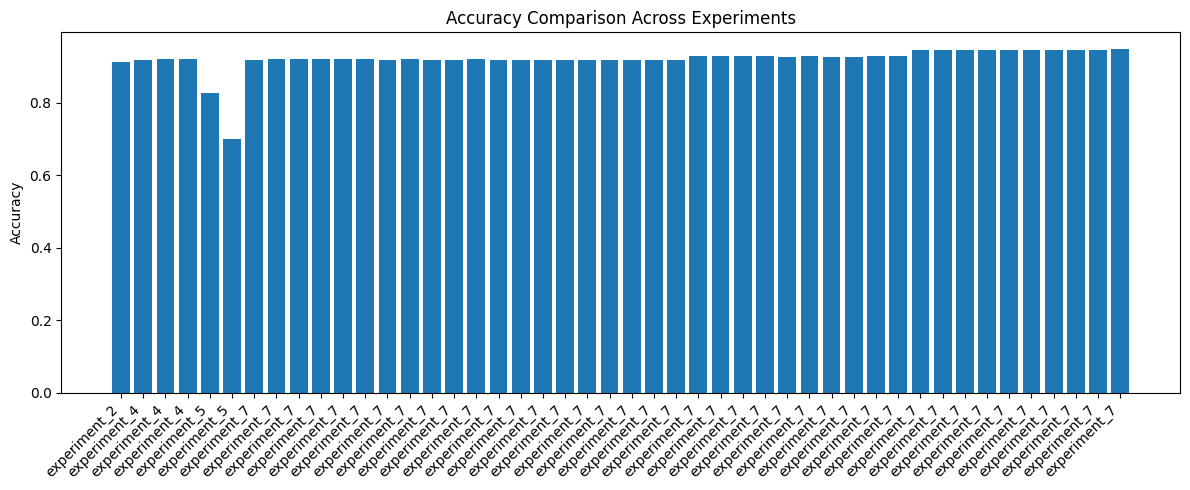

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_metric_comparison(exp_base_dir, metric='accuracy'):
    """Plot metric comparison across experiments."""
    if not os.path.exists(exp_base_dir):
        print("No experiments found")
        return
    
    experiments = []
    metrics_list = []
    
    for exp_name in sorted(os.listdir(exp_base_dir)):
        exp_dir = os.path.join(exp_base_dir, exp_name)
        if not os.path.isdir(exp_dir):
            continue
        
        for ratio_folder in os.listdir(exp_dir):
            ratio_path = os.path.join(exp_dir, ratio_folder)
            if not os.path.isdir(ratio_path) or ratio_folder in ['tensorboard']:
                continue
            
            for set_name in os.listdir(ratio_path):
                set_path = os.path.join(ratio_path, set_name)
                results_file = os.path.join(set_path, "results.json")
                
                if os.path.exists(results_file):
                    with open(results_file, "r") as f:
                        result_data = json.load(f)
                        metrics_val = result_data.get('best_metrics', {}).get(metric, None)
                        
                        if metrics_val is not None:
                            experiments.append(exp_name)
                            metrics_list.append(metrics_val)
    
    if metrics_list:
        plt.figure(figsize=(12, 5))
        plt.bar(range(len(experiments)), metrics_list)
        plt.xticks(range(len(experiments)), experiments, rotation=45, ha='right')
        plt.ylabel(metric.capitalize())
        plt.title(f"{metric.capitalize()} Comparison Across Experiments")
        plt.tight_layout()
        plt.show()
    else:
        print(f"No {metric} data found")

# Example: plot accuracy comparison
plot_metric_comparison(SAVE_ROOT, metric='accuracy')
